In [53]:
import os
import pickle
import random
import math
from collections import namedtuple, deque

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

import seaborn as sns

import torch

In [2]:
log = pd.read_csv("./data/log.csv")

# Code Snippets

## IQL_DATALOADER

In [155]:
training_data_rows = []

for (episode, agentIndex), group in log.groupby(["episode", "agentIndex"]):
    # 按照tick排序
    group = group.sort_values('tick')
    
    # 计算每个tick的流量总个数
    group['tick_volume'] = group.groupby('tick')['tick'].transform('size')
    
    # 计算每个tick的流量总和
    tick_volume_sum = group.groupby('tick')['tick_volume'].first()
    
    # 使用cumsum计算历史流量总个数（不包括当前tick）
    historical_volume = tick_volume_sum.cumsum().shift(1).fillna(0).astype(int)
    group['historical_volume'] = group['tick'].map(historical_volume)
    
    # 使用rolling和shift计算前三个tick的流量总个数（不包括当前tick）
    last_3_ticks_volume = tick_volume_sum.rolling(window=3, min_periods=1).sum().shift(1).fillna(0).astype(int)
    group['last_3_ticks_volume'] = group['tick'].map(last_3_ticks_volume)
    
    # 对每个tick内的数据进行聚合
    group_agg = group.groupby('tick').agg({
        'bid': 'mean',
        'marketPrice': 'mean',
        'Reward': 'mean',
        'status': 'mean',
        'pvValue': 'mean',
        'tick_volume': 'first'
    }).reset_index()
    
    # 计算历史所有tick的平均值，不包括当前tick
    for col in ['bid', 'marketPrice', 'Reward', 'status', 'pvValue']:
        group_agg[f'avg_{col}_all'] = group_agg[col].expanding().mean().shift(1)
        group_agg[f'avg_{col}_last_3'] = group_agg[col].rolling(window=3, min_periods=1).mean().shift(1)

    # 将聚合后的数据合并回原始group
    group = group.merge(group_agg, on='tick', suffixes=('', '_agg'))
    
    for tick in group['tick'].unique():
        current_tick_data = group[group['tick'] == tick]

        # 计算state
        budget = current_tick_data['budget'].iloc[0]
        remainingBudget = current_tick_data['remainingBudget'].iloc[0]
        timeleft = (24 - tick) / 24
        bgtleft = remainingBudget / budget if budget > 0 else 0

        # 从current_tick_data获取当前tick的特征
        current_tick_data.fillna(0, inplace=True)
        state_features = current_tick_data.iloc[0].to_dict()
    
        state = (
            timeleft, bgtleft,
            state_features['avg_bid_all'],
            state_features['avg_bid_last_3'],
            state_features['avg_marketPrice_all'],
            state_features['avg_pvValue_all'],
            state_features['avg_Reward_all'],
            state_features['avg_status_all'],
            state_features['avg_marketPrice_last_3'],
            state_features['avg_pvValue_last_3'],
            state_features['avg_Reward_last_3'],
            state_features['avg_status_last_3'],
            state_features['pvValue_agg'],
            state_features['tick_volume_agg'],
            state_features['last_3_ticks_volume'],
            state_features['historical_volume']
        )
        
        # 计算该tick的action
        total_bid = current_tick_data['bid'].sum()
        total_value = current_tick_data['pvValue'].sum()
        action = total_bid / total_value if total_value > 0 else 0
        
        # 计算该tick的reward
        reward = current_tick_data[current_tick_data['status'] == 1]['Reward'].sum()
        
        # 计算done
        tickNum = 23
        done = 1 if tick == tickNum or current_tick_data['done'].iloc[0] == 1 else 0
        
        # 添加到训练数据DataFrame
        training_data_rows.append({
            'episode': episode,
            'agentIndex': agentIndex,
            'tick': tick,
            'state': state,
            'action': action,
            'reward': reward,
            'done': done
        })
        
    # 将训练数据转换为DataFrame
    training_data = pd.DataFrame(training_data_rows)
    training_data = training_data.sort_values(by=['episode', 'agentIndex', 'tick'])
    
    # 计算next_state
    training_data['next_state'] = training_data.groupby(['episode', 'agentIndex'])['state'].shift(-1)
    training_data.loc[training_data['done'] == 1, 'next_state'] = None

/Users/rongzhimai/Library/Caches/pypoetry/virtualenvs/bidding-FwXjcHaf-py3.8/lib/python3.8/site-packages/pandas/core/frame.py:4144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## NORMALIZE_STATE

In [65]:
state_dim = 16
normalize_indices=[13, 14, 15]

state_columns = [f'state{i}' for i in range(state_dim)]
next_state_columns = [f'next_state{i}' for i in range(state_dim)]

for i, (state_col, next_state_col) in enumerate(zip(state_columns, next_state_columns)):
    training_data[state_col] = training_data['state'].apply(lambda x: x[i])
    training_data[next_state_col] = training_data['next_state'].apply(lambda x: x[i] if x is not None else 0.0)

In [67]:
stats = {
    i: {
        'min': training_data[state_columns[i]].min(),
        'max': training_data[state_columns[i]].max(),
        'mean': training_data[state_columns[i]].mean(),
        'std': training_data[state_columns[i]].std()
    }
    for i in normalize_indices
}

In [69]:
# 构建归一化后的'state'和'next_state'
for state_col, next_state_col in zip(state_columns, next_state_columns):
    if int(state_col.replace('state', '')) in normalize_indices:
        min_val = stats[int(state_col.replace('state', ''))]['min']
        max_val = stats[int(state_col.replace('state', ''))]['max']
        training_data[f'normalize_{state_col}'] = (training_data[state_col] - min_val) / (max_val - min_val)
        training_data[f'normalize_{next_state_col}'] = (training_data[next_state_col] - min_val) / (max_val - min_val)
    else:
        training_data[f'normalize_{state_col}'] = training_data[state_col]
        training_data[f'normalize_{next_state_col}'] = training_data[next_state_col]

In [71]:
# 重新组合归一化后的'state'和'next_state'列为元组
training_data['normalize_state'] = training_data.apply(
    lambda row: tuple(row[f'normalize_{state_col}'] for state_col in state_columns), axis=1)
training_data['normalize_nextstate'] = training_data.apply(
    lambda row: tuple(row[f'normalize_{next_state_col}'] for next_state_col in next_state_columns), axis=1)

## REPLAY_BUFFER

In [74]:
Experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

class ReplayBuffer:
    """
    强化学习储存训练数据的训练池
    """

    def __init__(self):
        self.memory = []

    def push(self, state, action, reward, next_state, done):
        """保存一个经验元组"""
        experience = Experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self, batch_size):
        """随机抽取一批经验"""
        tem = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*tem)
        states, actions, rewards, next_states, dones = np.stack(states), np.stack(actions), np.stack(rewards), np.stack(
            next_states), np.stack(dones)
        states, actions, rewards, next_states, dones = torch.FloatTensor(states), torch.FloatTensor(
            actions), torch.FloatTensor(rewards), torch.FloatTensor(next_states), torch.FloatTensor(dones)
        return states, actions, rewards, next_states, dones

    def __len__(self):
        """返回当前缓冲区的大小"""
        return len(self.memory)

In [79]:
buffer = ReplayBuffer()

for i in range(1000):
    buffer.push(np.array([1, 2, 3]), np.array(4), np.array(5), np.array([6, 7, 8]), np.array(0))

print(buffer.sample(20))

(tensor([[1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.],
        [1., 2., 3.]]), tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4.]), tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5.]), tensor([[6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [6., 7., 8.],
        [

## TEST_DATALOADER

In [118]:
class TestDataLoader:
    """
    离线评测数据加载器。
    """

    def __init__(self, file_path="./data/log.csv"):
        """
        初始化数据加载器。

        Args:
            file_path (str): 训练数据文件路径。
        """
        self.file_path = file_path
        self.raw_data_path = os.path.join(os.path.dirname(file_path), "raw_data.pickle")
        self.raw_data = self._get_raw_data()
        self.keys, self.test_dict = self._get_test_data_dict()

    def _get_raw_data(self):
        """
        从pickle文件中读取原始数据。

        Returns:
            pd.DataFrame: 原始数据。
        """
        with open(self.raw_data_path, 'rb') as file:
            return pickle.load(file)

    def _get_test_data_dict(self):
        """
        按照episode和agentIndex对原始数据进行分组并排序。

        Returns:
            list: 分组的键列表。
            dict: 分组的数据字典。
        """
        grouped_data = self.raw_data.sort_values('tick').groupby(['episode', 'agentIndex'])
        data_dict = {key: group for key, group in grouped_data}
        return list(data_dict.keys()), data_dict

    def mock_data(self, key):
        """
        根据episode和agentIndex获取训练数据，并构造测试数据。

        Args:
            key (tuple): 组合键，包含episode和agentIndex。

        Returns:
            int: tick数目。
            list: 每个tick的市场价格列表。
            list: 每个tick的pv值列表。
        """
        data = self.test_dict[key]
        pv_values = data.groupby('tick')['pvValue'].apply(list).apply(np.array).tolist()
        market_prices = data.groupby('tick')['marketPrice'].apply(list).apply(np.array).tolist()
        num_tick = len(pv_values)
        return num_tick, market_prices, pv_values

In [119]:
data_loader = TestDataLoader(file_path='./data/log.csv')

## OFFLINE_ENV

In [111]:
class OfflineEnv:
    """
    模拟广告竞价环境。
    """

    def __init__(self, min_remaining_budget: float = 0.01):
        """
        初始化模拟环境。

        :param min_remaining_budget: 出价智能体允许的最小剩余预算。
        """
        self.min_remaining_budget = min_remaining_budget

    def simulate_ad_bidding(self, pv_values: np.ndarray, bids: np.ndarray, market_prices: np.ndarray):
        """
        模拟广告竞价过程。

        :param pv_values: 各流量点的价值。
        :param bids: 出价智能体的出价。
        :param market_prices: 各流量点的市场价格。
        :return: 竞得的价值，花费，以及是否竞得的状态。
        """
        # 计算广告主是否竞得每个流量点
        tick_status = bids >= market_prices
        # 计算广告主的花费和获得的价值
        tick_cost = market_prices * tick_status
        tick_value = pv_values * tick_status

        return tick_value, tick_cost, tick_status

In [112]:
env = OfflineEnv()

## RUN_TEST

In [114]:
from bidding_train_env.agent import PlayerAgent

In [188]:
# 取一个（episode, agentIndex）的数据构建测试数据
keys, test_dict = data_loader.keys, data_loader.test_dict
total_rewards = 0

for key in keys:
    print(f'KEY: {key} Begin')
    # agent = PlayerAgent()

    num_tick, market_prices, pvalues = data_loader.mock_data(key)
    rewards = np.zeros(num_tick)
    history = {
        'bid': [],
        'status': [],
        'reward': [],
        'market_price': [],
        'pv_values': []
    }

    for tick_index in range(num_tick):
        # 1. 产生流量
        pv_value = pvalues[tick_index]
        market_price = market_prices[tick_index]

        # 2. 出价智能体出价
        if agent.remaining_budget < env.min_remaining_budget:
            bid = np.zeros(pv_value.shape[0])
        else:
            bid = agent.action(
                tick_index, agent.budget, agent.remaining_budget, pv_value,
                history['pv_values'], history['bid'], history['status'], history['reward'], history['market_price']
            )

        # 3. 模拟竞价
        tick_value, tick_cost, tick_status = env.simulate_ad_bidding(pv_value, bid, market_price)

        # 处理超投（一次tick的花费超过该出价智能体剩余预算）
        over_cost_ratio = max((np.sum(tick_cost) - agent.remaining_budget) / (np.sum(tick_cost) + 1e-4), 0)
        while over_cost_ratio > 0:
            pv_index = np.where(tick_status == 1)[0]
            dropped_pv_index = np.random.choice(pv_index, int(math.ceil(pv_index.shape[0] * over_cost_ratio)),
                                                replace=False)
            bid[dropped_pv_index] = 0
            tick_value, tick_cost, tick_status = env.simulate_ad_bidding(pv_value, bid, market_price)
            over_cost_ratio = max((np.sum(tick_cost) - agent.remaining_budget) / (np.sum(tick_cost) + 1e-4), 0)

        agent.remaining_budget -= np.sum(tick_cost)
        rewards[tick_index] = np.sum(tick_value)

        # 构建历史信息
        history['market_price'].append(market_price)
        history['bid'].append(bid)
        history['status'].append(tick_status)
        history['reward'].append(tick_value)
        history['pv_values'].append(pv_value)

    print(f'\nReward of key {key}: {np.sum(rewards)}\n')
    total_rewards += np.sum(rewards)
    
print(total_rewards)

KEY: (0.0, 0.0) Begin

Reward of key (0.0, 0.0): 0.0

KEY: (0.0, 1.0) Begin

Reward of key (0.0, 1.0): 0.0

KEY: (0.0, 2.0) Begin

Reward of key (0.0, 2.0): 0.0

KEY: (0.0, 3.0) Begin

Reward of key (0.0, 3.0): 0.0

KEY: (0.0, 4.0) Begin

Reward of key (0.0, 4.0): 0.0

KEY: (0.0, 5.0) Begin

Reward of key (0.0, 5.0): 0.0

KEY: (0.0, 6.0) Begin

Reward of key (0.0, 6.0): 0.4564579874277114

KEY: (0.0, 7.0) Begin

Reward of key (0.0, 7.0): 0.2314221709966659

KEY: (0.0, 8.0) Begin

Reward of key (0.0, 8.0): 0.0

KEY: (0.0, 9.0) Begin

Reward of key (0.0, 9.0): 0.0

KEY: (0.0, 10.0) Begin

Reward of key (0.0, 10.0): 0.0

KEY: (0.0, 11.0) Begin

Reward of key (0.0, 11.0): 0.0

KEY: (0.0, 12.0) Begin

Reward of key (0.0, 12.0): 0.0

KEY: (0.0, 13.0) Begin

Reward of key (0.0, 13.0): 0.0

KEY: (0.0, 14.0) Begin

Reward of key (0.0, 14.0): 0.0

KEY: (0.0, 15.0) Begin

Reward of key (0.0, 15.0): 0.0

KEY: (0.0, 16.0) Begin

Reward of key (0.0, 16.0): 0.0

KEY: (0.0, 17.0) Begin

Reward of key 

# Dataset Inspect

## ACF?

In [3]:
log.head(10)

episode  tick  agentIndex  agentCategory  budget  remainingBudget  Reward  \
0      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
1      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
2      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
3      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
4      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
5      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
6      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
7      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
8      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   
9      0.0   0.0         0.0            0.0  1500.0           1500.0     0.0   

   done  pvIndex   pvValue       bid  status  marketPrice  cost  
0   0.0      0.0  0.000010  0.000006     0.0     0.307123   0.0  
1   0.0      1.0  0.432514  0.245874     0.0     0.358711   0.0  
2   0.0      2.0  0.201910  0.114781     0.0     0.242880   0.0  
3   0.0      3.0  0.365158  0.207584     0.0     0.288583   0.0  
4   0.0      4.0  0.143416  0.081529     0.0     0.385997   0.0  
5   0.0      5.0  0.167203  0.095051     0.0     0.240738   0.0  
6   0.0      6.0  0.325585  0.185087     0.0     0.256251   0.0  
7   0.0      7.0  0.000010  0.000006     0.0     0.326242   0.0  
8   0.0      8.0  0.415607  0.236263     0.0     0.554185   0.0  
9   0.0      9.0  0.554829  0.315407     0.0     0.504284   0.0

In [128]:
def fill_agent_stats(df):
    agent_df_map = {}
    agent_stats = {
        "agentIndex": [],
        "agentCategory": [],
        "episode": [],
        "tick": [],
        "status": [],
        "reward": [],
        "pvValue": [],
        "bid": [],
        "marketPrice": [],
        "cost": []
    }
    
    for _agent in df["agentIndex"].unique():
        print(f"processing agent {int(_agent+1)}")
        
        curr_agent = df[df.agentIndex.eq(_agent)].reset_index(drop=True)
        agent_df_map[_agent] = curr_agent

        for _episode in range(7):
            for _tick in range(24):
                curr_df = curr_agent[
                    curr_agent.episode.eq(_episode) & curr_agent.tick.eq(_tick)
                ].reset_index(drop=True)
                
                agent_stats["agentIndex"].append(_agent)
                agent_stats["agentCategory"].append(curr_df.loc[0, "agentCategory"])
                agent_stats["episode"].append(_episode)
                agent_stats["tick"].append(_tick)
                agent_stats["status"].append(curr_df["status"].sum())
                agent_stats["reward"].append(curr_df["Reward"].sum())
                agent_stats["pvValue"].append(curr_df["pvValue"].sum())
                agent_stats["bid"].append(curr_df["bid"].sum())
                agent_stats["marketPrice"].append(curr_df["marketPrice"].sum())
                agent_stats["cost"].append(curr_df["cost"].sum())
        
    agent_stats_df = pd.DataFrame(agent_stats)
    agent_stats_df["timeIndex"] = agent_stats_df["episode"] * 24 + agent_stats_df["tick"]
    
    return agent_df_map, agent_stats_df

In [83]:
agent_df_map, agent_stats_df = fill_agent_stats(log)

processing agent 1
processing agent 2
processing agent 3
processing agent 4
processing agent 5
processing agent 6
processing agent 7
processing agent 8
processing agent 9
processing agent 10
processing agent 11
processing agent 12
processing agent 13
processing agent 14
processing agent 15
processing agent 16
processing agent 17
processing agent 18
processing agent 19
processing agent 20
processing agent 21
processing agent 22
processing agent 23
processing agent 24
processing agent 25
processing agent 26
processing agent 27
processing agent 28
processing agent 29
processing agent 30


plotting agent 0


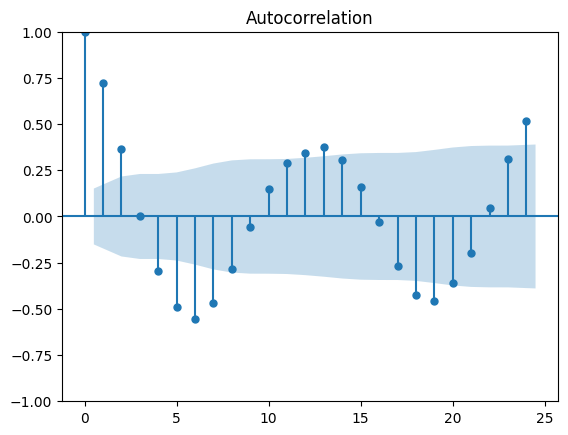

plotting agent 1


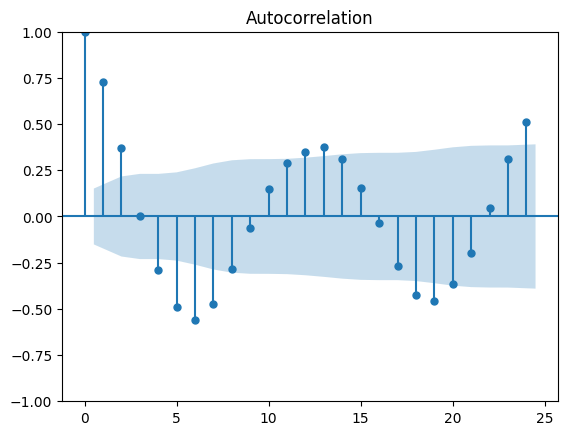

plotting agent 2


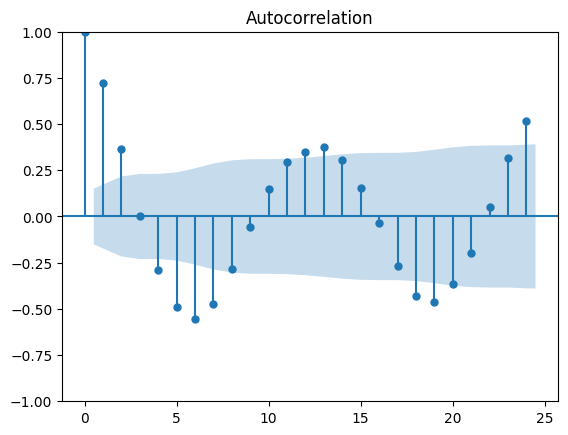

plotting agent 3


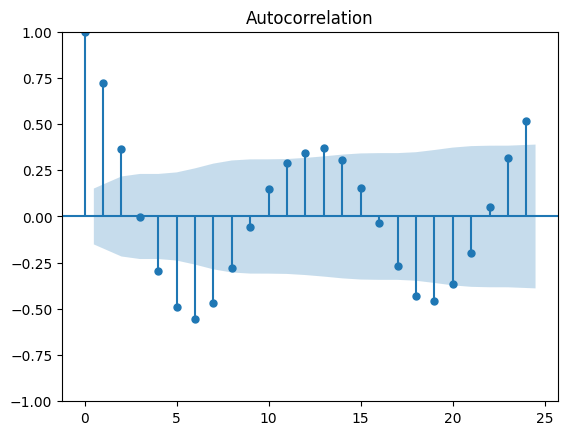

plotting agent 4


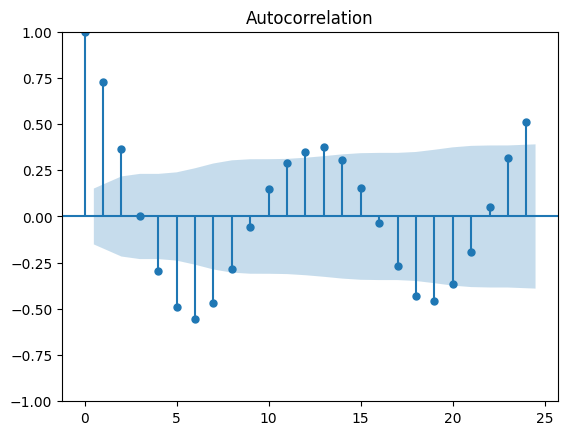

plotting agent 5


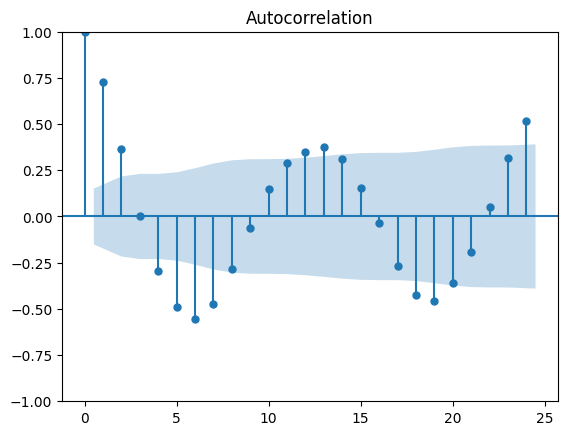

plotting agent 6


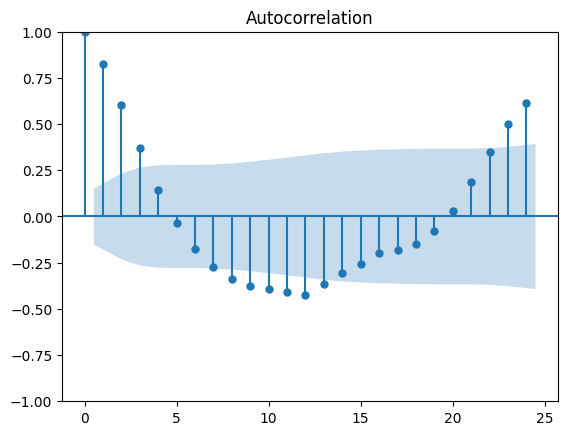

plotting agent 7


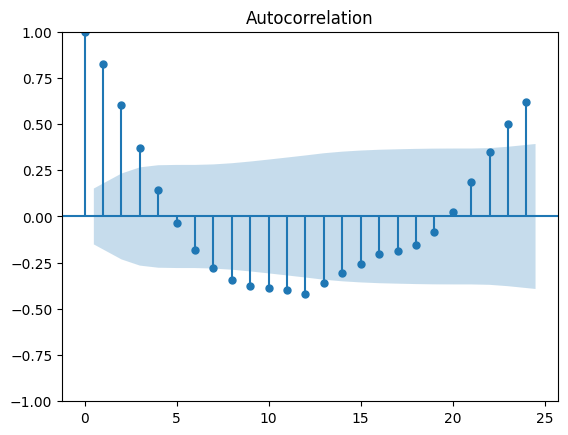

plotting agent 8


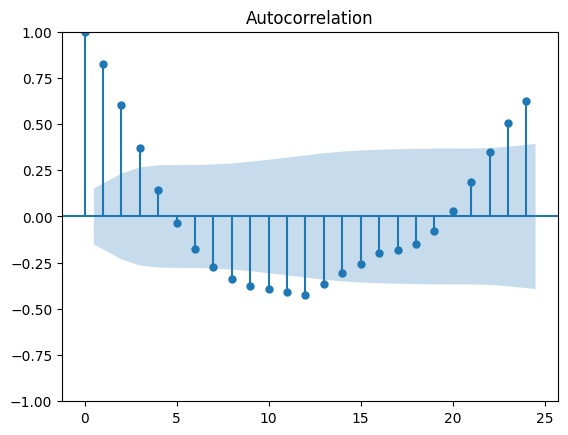

plotting agent 9


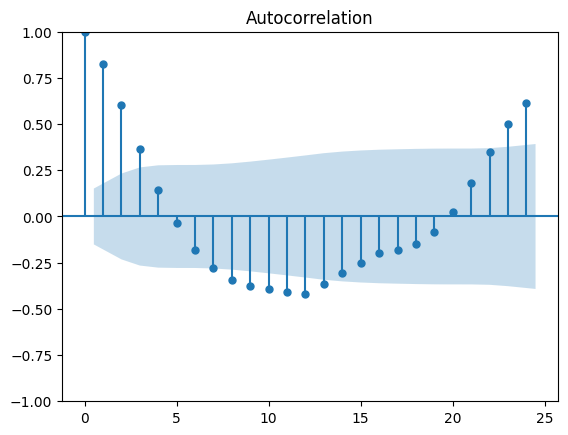

plotting agent 10


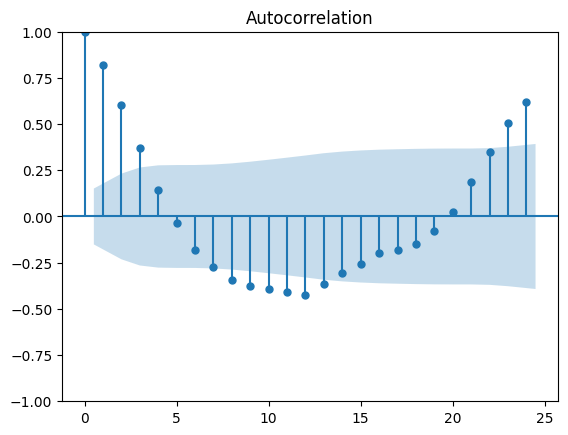

plotting agent 11


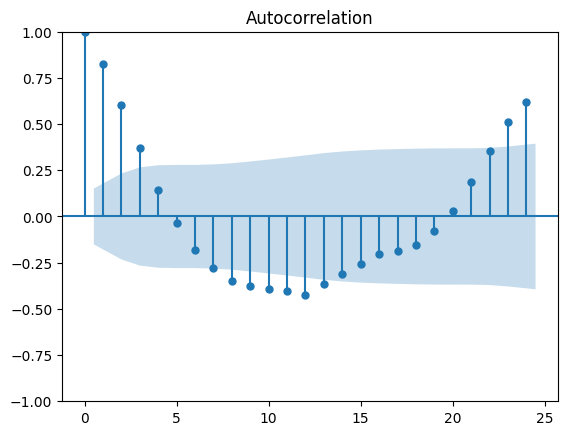

plotting agent 12


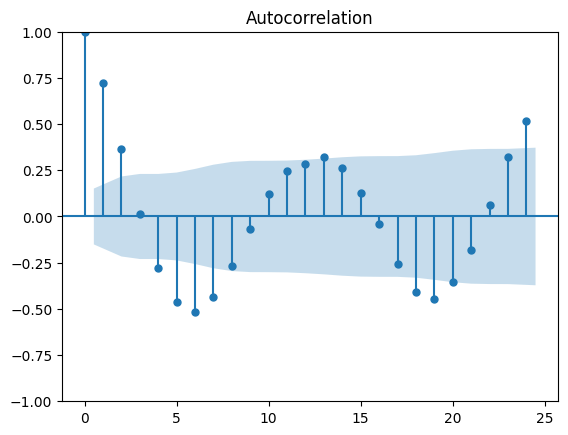

plotting agent 13


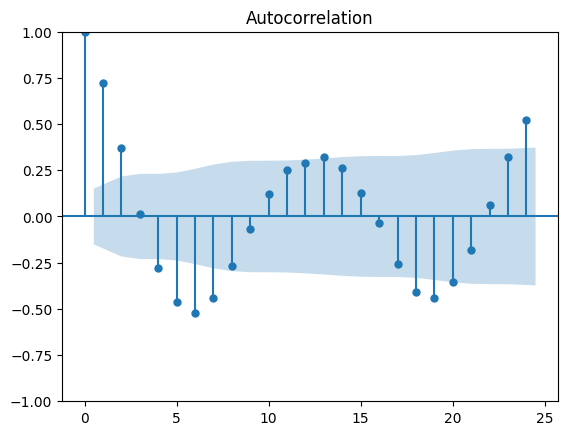

plotting agent 14


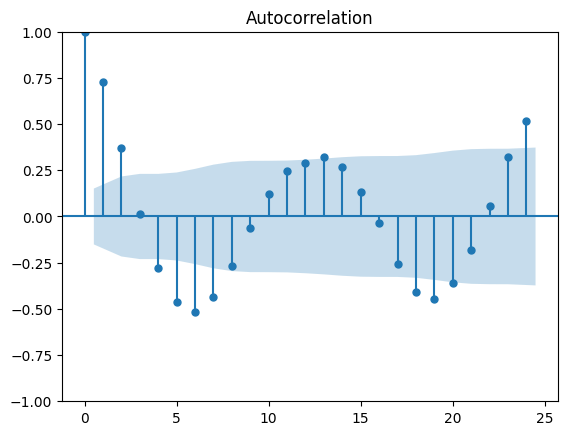

plotting agent 15


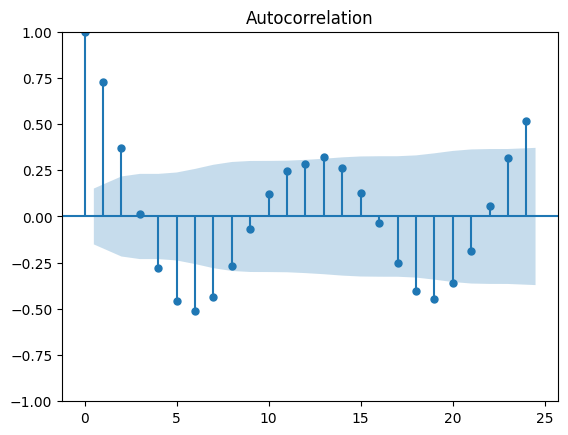

plotting agent 16


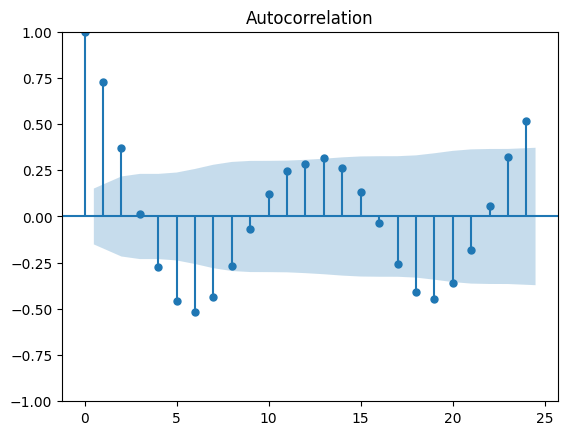

plotting agent 17


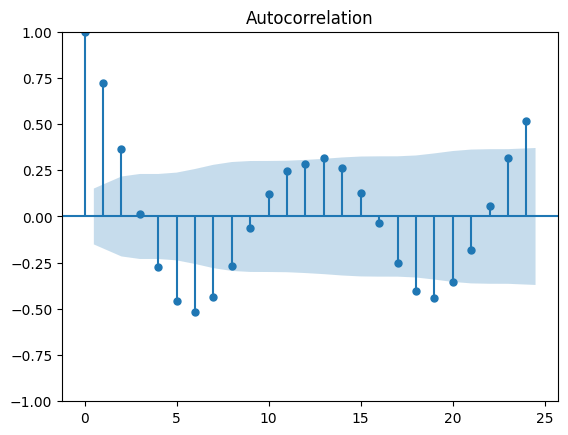

plotting agent 18


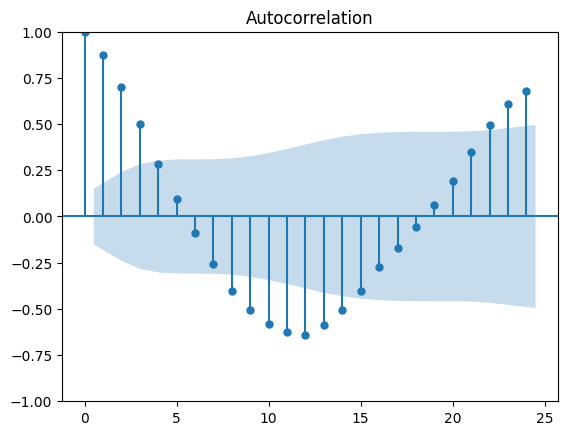

plotting agent 19


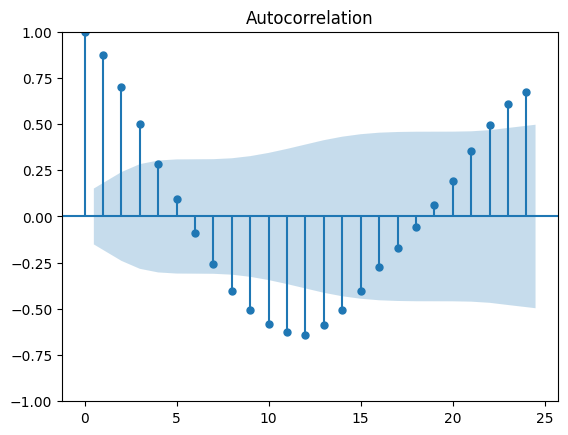

plotting agent 20


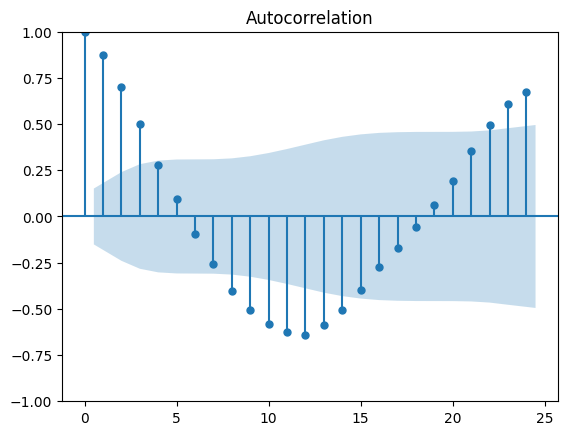

plotting agent 21


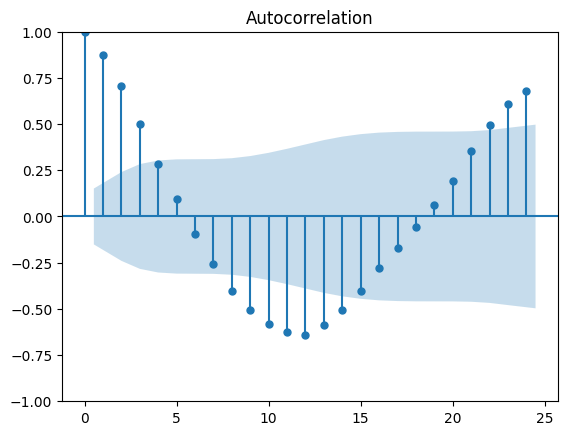

plotting agent 22


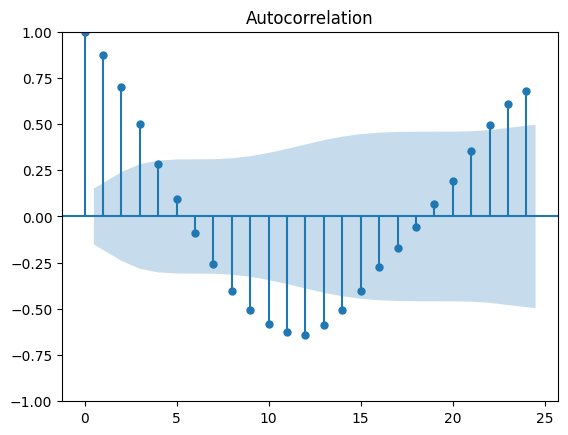

plotting agent 23


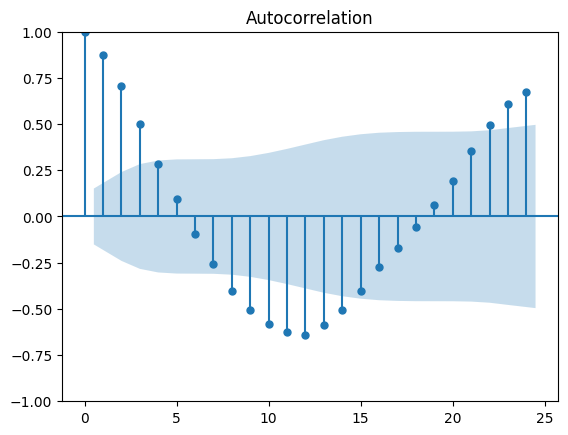

plotting agent 24


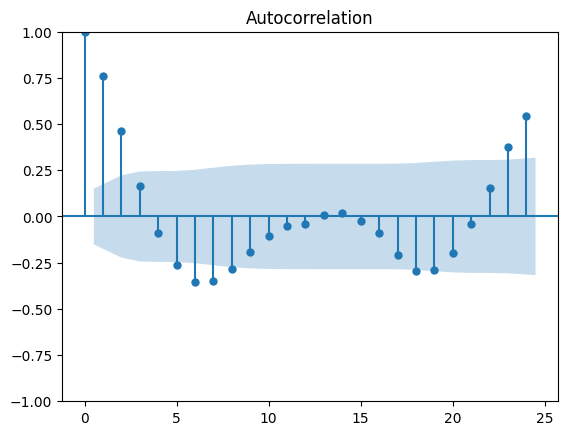

plotting agent 25


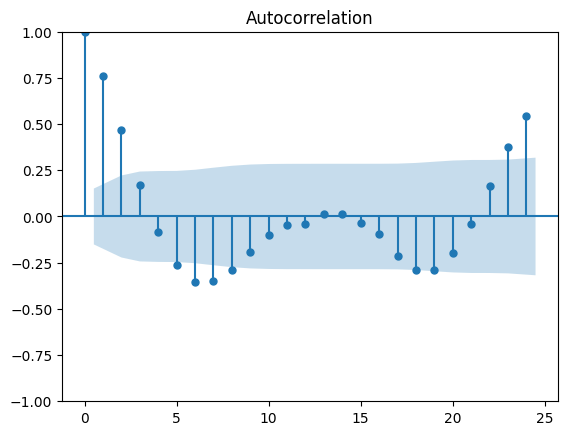

plotting agent 26


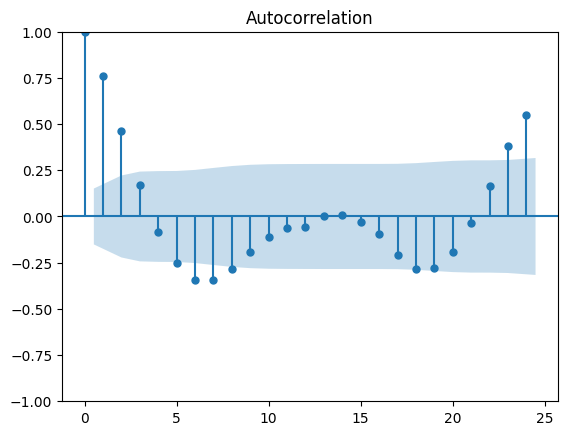

plotting agent 27


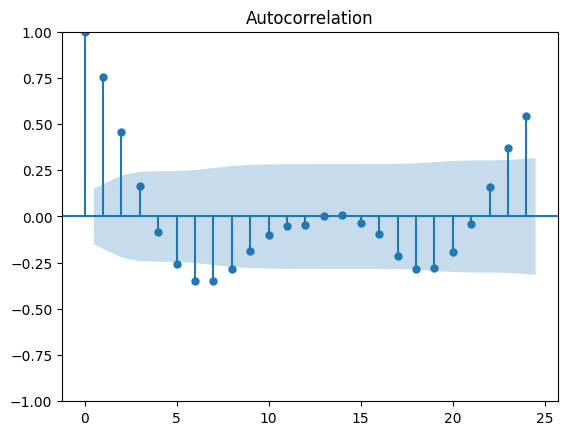

plotting agent 28


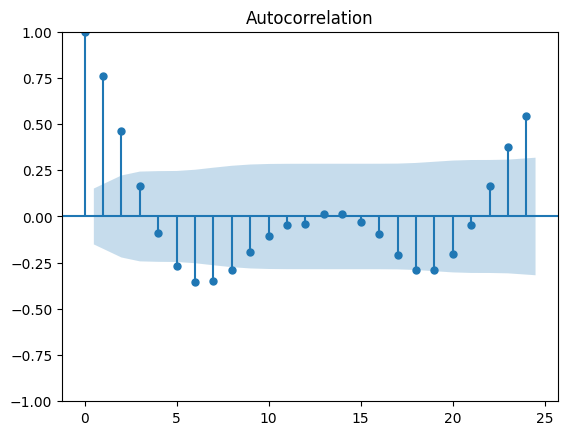

plotting agent 29


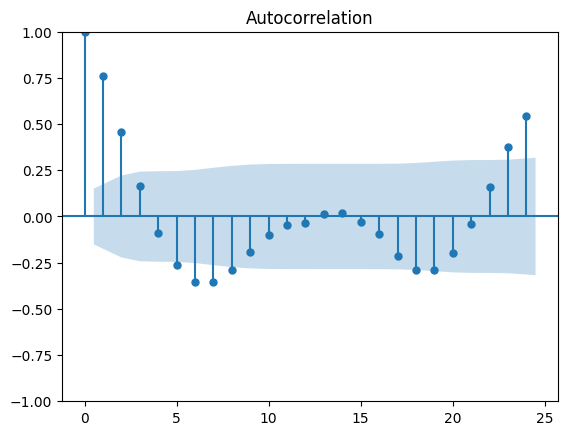

In [163]:
def plot1():
    for _agent in agent_stats_df.agentIndex.unique():
        print(f"plotting agent {int(_agent)}")
        curr_agent = agent_stats_df[agent_stats_df["agentIndex"].eq(_agent)].reset_index(drop=True)
        
        # sns.lineplot(x=curr_agent["timeIndex"], y=agent_stats_df["status"])
        plot_acf(curr_agent["pvValue"], lags=24)
        plt.show()

plot1()

## reward 可能大于 cost

In [214]:
log[log.agentIndex.eq(0) & log.status.eq(1) & log.Reward.le(log.cost)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
1182720       0.0  13.0         0.0            0.0  1500.0       854.045007   
1182724       0.0  13.0         0.0            0.0  1500.0       854.045007   
1182768       0.0  13.0         0.0            0.0  1500.0       854.045007   
1182770       0.0  13.0         0.0            0.0  1500.0       854.045007   
1182779       0.0  13.0         0.0            0.0  1500.0       854.045007   
...           ...   ...         ...            ...     ...              ...   
15448916      6.0  18.0         0.0            0.0  1500.0       522.666455   
15449015      6.0  18.0         0.0            0.0  1500.0       522.666455   
15449017      6.0  18.0         0.0            0.0  1500.0       522.666455   
15449032      6.0  18.0         0.0            0.0  1500.0       522.666455   
15449046      6.0  18.0         0.0            0.0  1500.0       522.666455   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
1182720   0.238650   0.0      0.0  0.238650  0.260831     1.0     0.214699   
1182724   0.365829   0.0      4.0  0.457286  0.499788     1.0     0.406271   
1182768   0.451214   0.0     48.0  0.451214  0.493152     1.0     0.400558   
1182770   0.183140   0.0     50.0  0.228925  0.250202     1.0     0.236655   
1182779   0.411147   0.0     59.0  0.411147  0.449361     1.0     0.317156   
...            ...   ...      ...       ...       ...     ...          ...   
15448916  0.253879   0.0   2696.0  0.317349  0.327397     1.0     0.311959   
15449015  0.279162   0.0   2795.0  0.279162  0.288001     1.0     0.222924   
15449017  0.345524   0.0   2797.0  0.345524  0.356464     1.0     0.302600   
15449032  0.140265   0.0   2812.0  0.233775  0.241177     1.0     0.237207   
15449046  0.182720   0.0   2826.0  0.304534  0.314176     1.0     0.307254   

              cost  remaining_pct  
1182720   0.239433       0.569363  
1182724   0.371272       0.569363  
1182768   0.491785       0.569363  
1182770   0.198931       0.569363  
1182779   0.416577       0.569363  
...            ...            ...  
15448916  0.258881       0.348444  
15449015  0.287037       0.348444  
15449017  0.349480       0.348444  
15449032  0.142324       0.348444  
15449046  0.184352       0.348444  

[4965 rows x 15 columns]

In [216]:
log[log.agentIndex.eq(29) & log.Reward.lt(log.cost)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
52515         0.0   1.0        29.0            4.0  3000.0      3000.000000   
52516         0.0   1.0        29.0            4.0  3000.0      3000.000000   
52517         0.0   1.0        29.0            4.0  3000.0      3000.000000   
52520         0.0   1.0        29.0            4.0  3000.0      3000.000000   
52521         0.0   1.0        29.0            4.0  3000.0      3000.000000   
...           ...   ...         ...            ...     ...              ...   
16163244      6.0  23.0        29.0            4.0  3000.0         0.576634   
16164044      6.0  23.0        29.0            4.0  3000.0         0.576634   
16164105      6.0  23.0        29.0            4.0  3000.0         0.576634   
16165483      6.0  23.0        29.0            4.0  3000.0         0.576634   
16165615      6.0  23.0        29.0            4.0  3000.0         0.576634   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
52515     0.032505   0.0      0.0  0.054175  0.317704     1.0     0.249702   
52516     0.207020   0.0      1.0  0.207020  1.214040     1.0     0.416958   
52517     0.098080   0.0      2.0  0.122600  0.718975     1.0     0.416116   
52520     0.096532   0.0      5.0  0.120665  0.707626     1.0     0.371218   
52521     0.158238   0.0      6.0  0.197797  1.159956     1.0     0.315382   
...            ...   ...      ...       ...       ...     ...          ...   
16163244  0.002665   0.0    236.0  0.004441  0.182044     1.0     0.166636   
16164044  0.002338   0.0   1036.0  0.003896  0.159711     1.0     0.105895   
16164105  0.002665   0.0   1097.0  0.004441  0.182044     1.0     0.166636   
16165483  0.005328   0.0   2475.0  0.006660  0.273023     1.0     0.186211   
16165615  0.002338   0.0   2607.0  0.003896  0.159711     1.0     0.105895   

              cost  remaining_pct  
52515     0.149821       1.000000  
52516     0.677249       1.000000  
52517     0.400902       1.000000  
52520     0.416928       1.000000  
52521     0.282335       1.000000  
...            ...            ...  
16163244  0.099982       0.000192  
16164044  0.063537       0.000192  
16164105  0.099982       0.000192  
16165483  0.159078       0.000192  
16165615  0.063537       0.000192  

[42434 rows x 15 columns]

<font size="5">网络中的alpha可能大于1，进而导致reward大于cost</font>

In [222]:
log[log.episode.eq(0) & log.tick.eq(1) & log.pvIndex.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
24240      0.0   1.0         0.0            0.0  1500.0      1500.000000   
25215      0.0   1.0         1.0            0.0  1800.0      1790.557733   
26190      0.0   1.0         2.0            0.0  2100.0      1989.053931   
27165      0.0   1.0         3.0            0.0  2400.0      2330.748123   
28140      0.0   1.0         4.0            0.0  2700.0      2466.523948   
29115      0.0   1.0         5.0            0.0  3000.0      3000.000000   
30090      0.0   1.0         6.0            1.0  1500.0      1497.675377   
31065      0.0   1.0         7.0            1.0  1800.0      1791.022427   
32040      0.0   1.0         8.0            1.0  2100.0      2095.720371   
33015      0.0   1.0         9.0            1.0  2400.0      2400.000000   
33990      0.0   1.0        10.0            1.0  2700.0      2694.131027   
34965      0.0   1.0        11.0            1.0  3000.0      2964.941117   
35940      0.0   1.0        12.0            2.0  1500.0      1498.524355   
36915      0.0   1.0        13.0            2.0  1800.0      1798.369404   
37890      0.0   1.0        14.0            2.0  2100.0      2100.000000   
38865      0.0   1.0        15.0            2.0  2400.0      2399.218195   
39840      0.0   1.0        16.0            2.0  2700.0      2675.267461   
40815      0.0   1.0        17.0            2.0  3000.0      2997.238678   
41790      0.0   1.0        18.0            3.0  1500.0      1498.650464   
42765      0.0   1.0        19.0            3.0  1800.0      1791.484406   
43740      0.0   1.0        20.0            3.0  2100.0      2068.588482   
44715      0.0   1.0        21.0            3.0  2400.0      2313.008650   
45690      0.0   1.0        22.0            3.0  2700.0      2656.584658   
46665      0.0   1.0        23.0            3.0  3000.0      2999.775289   
47640      0.0   1.0        24.0            4.0  1500.0      1498.342484   
48615      0.0   1.0        25.0            4.0  1800.0      1798.701426   
49590      0.0   1.0        26.0            4.0  2100.0      2099.615669   
50565      0.0   1.0        27.0            4.0  2400.0      2399.467421   
51540      0.0   1.0        28.0            4.0  2700.0      2696.597088   
52515      0.0   1.0        29.0            4.0  3000.0      3000.000000   

         Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
24240  0.000000   0.0      0.0  0.218806  0.140556     0.0     0.249702   
25215  0.000000   0.0      0.0  0.265529  0.226123     0.0     0.249702   
26190  0.341959   0.0      0.0  0.341959  0.439434     1.0     0.249702   
27165  0.283097   0.0      0.0  0.353872  0.407704     1.0     0.249702   
28140  0.000000   0.0      0.0  0.321711  0.000000     0.0     0.249702   
29115  0.000000   0.0      0.0  0.327801  0.219131     0.0     0.249702   
30090  0.000000   0.0      0.0  0.050133  0.041689     0.0     0.249702   
31065  0.000000   0.0      0.0  0.143206  0.140656     0.0     0.249702   
32040  0.000000   0.0      0.0  0.073897  0.113190     0.0     0.249702   
33015  0.000000   0.0      0.0  0.012916  0.101811     0.0     0.249702   
33990  0.000000   0.0      0.0  0.122936  0.126353     0.0     0.249702   
34965  0.000000   0.0      0.0  0.000010  0.249702     0.0     0.249702   
35940  0.000000   0.0      0.0  0.282318  0.196031     0.0     0.249702   
36915  0.000000   0.0      0.0  0.243102  0.202386     0.0     0.249702   
37890  0.000000   0.0      0.0  0.200129  0.120078     0.0     0.249702   
38865  0.000000   0.0      0.0  0.224462  0.156645     0.0     0.249702   
39840  0.000000   0.0      0.0  0.250990  0.228247     0.0     0.249702   
40815  0.000000   0.0      0.0  0.219561  0.153136     0.0     0.249702   
41790  0.000000   0.0      0.0  0.069153  0.064180     0.0     0.249702   
42765  0.000000   0.0      0.0  0.097698  0.053734     0.0     0.249702   
43740  0.000000   0.0      0.0  0.000010  0.000007     0.0     0.249702   


In [220]:
log[log.pvValue.le(log.bid)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
1616          0.0   0.0         2.0            0.0  2100.0      2100.000000   
1617          0.0   0.0         2.0            0.0  2100.0      2100.000000   
1618          0.0   0.0         2.0            0.0  2100.0      2100.000000   
1619          0.0   0.0         2.0            0.0  2100.0      2100.000000   
1620          0.0   0.0         2.0            0.0  2100.0      2100.000000   
...           ...   ...         ...            ...     ...              ...   
16167086      6.0  23.0        29.0            4.0  3000.0         0.576634   
16167130      6.0  23.0        29.0            4.0  3000.0         0.576634   
16167231      6.0  23.0        29.0            4.0  3000.0         0.576634   
16167235      6.0  23.0        29.0            4.0  3000.0         0.576634   
16167350      6.0  23.0        29.0            4.0  3000.0         0.576634   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
1616      0.000000   0.0      0.0  0.000010  0.000012     0.0     0.307123   
1617      0.262051   0.0      1.0  0.327564  0.404276     1.0     0.358711   
1618      0.176232   0.0      2.0  0.220290  0.271880     1.0     0.242880   
1619      0.272788   0.0      3.0  0.340985  0.420840     1.0     0.288583   
1620      0.000000   0.0      4.0  0.146946  0.181359     0.0     0.385997   
...            ...   ...      ...       ...       ...     ...          ...   
16167086  0.000000   0.0   4078.0  0.000010  0.000410     0.0     0.074741   
16167130  0.000000   0.0   4122.0  0.000010  0.000410     0.0     0.218504   
16167231  0.000000   0.0   4223.0  0.000010  0.000410     0.0     0.186389   
16167235  0.000000   0.0   4227.0  0.003743  0.153424     0.0     0.153424   
16167350  0.000000   0.0   4342.0  0.000010  0.000410     0.0     0.186541   

              cost  remaining_pct  
1616      0.000000       1.000000  
1617      0.293125       1.000000  
1618      0.195698       1.000000  
1619      0.297357       1.000000  
1620      0.000000       1.000000  
...            ...            ...  
16167086  0.000000       0.000192  
16167130  0.000000       0.000192  
16167231  0.000000       0.000192  
16167235  0.000000       0.000192  
16167350  0.000000       0.000192  

[5937328 rows x 15 columns]

## 同一个流量对于同一个category的agent，pvValue相近

In [168]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(0) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
0             0.0   0.0         0.0            0.0  1500.0           1500.0   
2309610       1.0   0.0         0.0            0.0  1500.0           1500.0   
4619220       2.0   0.0         0.0            0.0  1500.0           1500.0   
6928860       3.0   0.0         0.0            0.0  1500.0           1500.0   
9238500       4.0   0.0         0.0            0.0  1500.0           1500.0   
11548110      5.0   0.0         0.0            0.0  1500.0           1500.0   
13857750      6.0   0.0         0.0            0.0  1500.0           1500.0   

          Reward  done  pvIndex   pvValue       bid  status  marketPrice  cost  
0            0.0   0.0      0.0  0.000010  0.000006     0.0     0.307123   0.0  
2309610      0.0   0.0      0.0  0.385272  0.232347     0.0     0.301463   0.0  
4619220      0.0   0.0      0.0  0.000010  0.000006     0.0     0.213716   0.0  
6928860      0.0   0.0      0.0  0.000010  0.000006     0.0     0.275920   0.0  
9238500      0.0   0.0      0.0  0.240876  0.137519     0.0     0.238489   0.0  
11548110     0.0   0.0      0.0  0.000010  0.000006     0.0     0.321791   0.0  
13857750     0.0   0.0      0.0  0.048582  0.031900     0.0     0.146005   0.0

In [169]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(1) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
808           0.0   0.0         1.0            0.0  1800.0           1800.0   
2310319       1.0   0.0         1.0            0.0  1800.0           1800.0   
4619851       2.0   0.0         1.0            0.0  1800.0           1800.0   
6929972       3.0   0.0         1.0            0.0  1800.0           1800.0   
9239249       4.0   0.0         1.0            0.0  1800.0           1800.0   
11549080      5.0   0.0         1.0            0.0  1800.0           1800.0   
13858686      6.0   0.0         1.0            0.0  1800.0           1800.0   

          Reward  done  pvIndex   pvValue       bid  status  marketPrice  cost  
808          0.0   0.0      0.0  0.000010  0.000009     0.0     0.307123   0.0  
2310319      0.0   0.0      0.0  0.354370  0.301463     0.0     0.301463   0.0  
4619851      0.0   0.0      0.0  0.000010  0.000009     0.0     0.213716   0.0  
6929972      0.0   0.0      0.0  0.000010  0.000009     0.0     0.275920   0.0  
9239249      0.0   0.0      0.0  0.227055  0.193156     0.0     0.238489   0.0  
11549080     0.0   0.0      0.0  0.000010  0.000009     0.0     0.321791   0.0  
13858686     0.0   0.0      0.0  0.156296  0.132961     0.0     0.146005   0.0

In [174]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(2) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
1616          0.0   0.0         2.0            0.0  2100.0           2100.0   
2311028       1.0   0.0         2.0            0.0  2100.0           2100.0   
4620482       2.0   0.0         2.0            0.0  2100.0           2100.0   
6931084       3.0   0.0         2.0            0.0  2100.0           2100.0   
9239998       4.0   0.0         2.0            0.0  2100.0           2100.0   
11550050      5.0   0.0         2.0            0.0  2100.0           2100.0   
13859622      6.0   0.0         2.0            0.0  2100.0           2100.0   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
1616      0.000000   0.0      0.0  0.000010  0.000012     0.0     0.307123   
2311028   0.330715   0.0      0.0  0.413394  0.537771     1.0     0.301463   
4620482   0.000000   0.0      0.0  0.000010  0.000013     0.0     0.213716   
6931084   0.000000   0.0      0.0  0.000010  0.000012     0.0     0.275920   
9239998   0.250398   0.0      0.0  0.312998  0.374799     1.0     0.238489   
11550050  0.000000   0.0      0.0  0.000010  0.000012     0.0     0.321791   
13859622  0.068428   0.0      0.0  0.114047  0.163703     1.0     0.146005   

              cost  
1616      0.000000  
2311028   0.347275  
4620482   0.000000  
6931084   0.000000  
9239998   0.215541  
11550050  0.000000  
13859622  0.087603

In [175]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(3) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
2424          0.0   0.0         3.0            0.0  2400.0           2400.0   
2311737       1.0   0.0         3.0            0.0  2400.0           2400.0   
4621113       2.0   0.0         3.0            0.0  2400.0           2400.0   
6932196       3.0   0.0         3.0            0.0  2400.0           2400.0   
9240747       4.0   0.0         3.0            0.0  2400.0           2400.0   
11551020      5.0   0.0         3.0            0.0  2400.0           2400.0   
13860558      6.0   0.0         3.0            0.0  2400.0           2400.0   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
2424      0.000000   0.0      0.0  0.000010  0.000011     0.0     0.307123   
2311737   0.248065   0.0      0.0  0.413442  0.434094     1.0     0.301463   
4621113   0.000000   0.0      0.0  0.000010  0.000010     0.0     0.213716   
6932196   0.000000   0.0      0.0  0.000010  0.000011     0.0     0.275920   
9240747   0.153581   0.0      0.0  0.255969  0.269426     1.0     0.238489   
11551020  0.000000   0.0      0.0  0.000010  0.000011     0.0     0.321791   
13860558  0.000000   0.0      0.0  0.138923  0.146005     0.0     0.146005   

              cost  
2424      0.000000  
2311737   0.180878  
4621113   0.000000  
6932196   0.000000  
9240747   0.143093  
11551020  0.000000  
13860558  0.000000

In [176]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(4) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
3232          0.0   0.0         4.0            0.0  2700.0           2700.0   
2312446       1.0   0.0         4.0            0.0  2700.0           2700.0   
4621744       2.0   0.0         4.0            0.0  2700.0           2700.0   
6933308       3.0   0.0         4.0            0.0  2700.0           2700.0   
9241496       4.0   0.0         4.0            0.0  2700.0           2700.0   
11551990      5.0   0.0         4.0            0.0  2700.0           2700.0   
13861494      6.0   0.0         4.0            0.0  2700.0           2700.0   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
3232      0.000000   0.0      0.0  0.000010  0.000049     0.0     0.307123   
2312446   0.429100   0.0      0.0  0.429100  1.649421     1.0     0.301463   
4621744   0.000000   0.0      0.0  0.002240  0.008778     0.0     0.213716   
6933308   0.000000   0.0      0.0  0.000010  0.000061     0.0     0.275920   
9241496   0.226682   0.0      0.0  0.226682  1.195499     1.0     0.238489   
11551990  0.000000   0.0      0.0  0.000010  0.000057     0.0     0.321791   
13861494  0.000000   0.0      0.0  0.026320  0.069422     0.0     0.146005   

              cost  
3232      0.000000  
2312446   0.537771  
4621744   0.000000  
6933308   0.000000  
9241496   0.374799  
11551990  0.000000  
13861494  0.000000

In [177]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(5) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
4040          0.0   0.0         5.0            0.0  3000.0           3000.0   
2313155       1.0   0.0         5.0            0.0  3000.0           3000.0   
4622375       2.0   0.0         5.0            0.0  3000.0           3000.0   
6934420       3.0   0.0         5.0            0.0  3000.0           3000.0   
9242245       4.0   0.0         5.0            0.0  3000.0           3000.0   
11552960      5.0   0.0         5.0            0.0  3000.0           3000.0   
13862430      6.0   0.0         5.0            0.0  3000.0           3000.0   

          Reward  done  pvIndex   pvValue       bid  status  marketPrice  cost  
4040         0.0   0.0      0.0  0.000010  0.000006     0.0     0.307123   0.0  
2313155      0.0   0.0      0.0  0.430236  0.257956     0.0     0.301463   0.0  
4622375      0.0   0.0      0.0  0.000010  0.000006     0.0     0.213716   0.0  
6934420      0.0   0.0      0.0  0.000010  0.000006     0.0     0.275920   0.0  
9242245      0.0   0.0      0.0  0.184702  0.104725     0.0     0.238489   0.0  
11552960     0.0   0.0      0.0  0.000010  0.000006     0.0     0.321791   0.0  
13862430     0.0   0.0      0.0  0.167238  0.108510     0.0     0.146005   0.0

In [178]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(6) & log.tick.eq(0)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
4848          0.0   0.0         6.0            1.0  1500.0           1500.0   
2313864       1.0   0.0         6.0            1.0  1500.0           1500.0   
4623006       2.0   0.0         6.0            1.0  1500.0           1500.0   
6935532       3.0   0.0         6.0            1.0  1500.0           1500.0   
9242994       4.0   0.0         6.0            1.0  1500.0           1500.0   
11553930      5.0   0.0         6.0            1.0  1500.0           1500.0   
13863366      6.0   0.0         6.0            1.0  1500.0           1500.0   

            Reward  done  pvIndex   pvValue       bid  status  marketPrice  \
4848      0.000000   0.0      0.0  0.118086  0.098111     0.0     0.307123   
2313864   0.000000   0.0      0.0  0.153462  0.127502     0.0     0.301463   
4623006   0.170484   0.0      0.0  0.284140  0.236075     1.0     0.213716   
6935532   0.000000   0.0      0.0  0.332098  0.275920     0.0     0.275920   
9242994   0.000000   0.0      0.0  0.074080  0.061549     0.0     0.238489   
11553930  0.000000   0.0      0.0  0.299809  0.249094     0.0     0.321791   
13863366  0.000000   0.0      0.0  0.104684  0.086975     0.0     0.146005   

              cost  
4848      0.000000  
2313864   0.000000  
4623006   0.128229  
6935532   0.000000  
9242994   0.000000  
11553930  0.000000  
13863366  0.000000

In [179]:
log[log.pvIndex.eq(0) & log.agentIndex.eq(6) & log.tick.eq(1)]

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
30090         0.0   1.0         6.0            1.0  1500.0      1497.675377   
2335764       1.0   1.0         6.0            1.0  1500.0      1497.614087   
4642440       2.0   1.0         6.0            1.0  1500.0      1497.792872   
6969402       3.0   1.0         6.0            1.0  1500.0      1497.096442   
9265758       4.0   1.0         6.0            1.0  1500.0      1497.536318   
11583372      5.0   1.0         6.0            1.0  1500.0      1498.422666   
13892466      6.0   1.0         6.0            1.0  1500.0      1493.738323   

          Reward  done  pvIndex   pvValue       bid  status  marketPrice  cost  
30090        0.0   0.0      0.0  0.050133  0.041689     0.0     0.249702   0.0  
2335764      0.0   0.0      0.0  0.111455  0.092682     0.0     0.531277   0.0  
4642440      0.0   0.0      0.0  0.107333  0.089254     0.0     0.262473   0.0  
6969402      0.0   0.0      0.0  0.377791  0.314148     0.0     0.385896   0.0  
9265758      0.0   0.0      0.0  0.075047  0.062406     0.0     0.328487   0.0  
11583372     0.0   0.0      0.0  0.384597  0.319862     0.0     0.421756   0.0  
13892466     0.0   0.0      0.0  0.071643  0.059553     0.0     0.297499   0.0

## budget每天重新计算

In [180]:
log["remaining_pct"] = log["remainingBudget"] / log["budget"]

In [227]:
log["timeIndex"] = log["episode"] * 24 + log["tick"]

In [234]:
selected_agent_budget_ratio = (
    log
    .loc[log.agentIndex.eq(0)].drop_duplicates(["episode", "tick" , "timeIndex"])
    .reset_index(drop=True)
)

selected_agent_budget_ratio

episode  tick  agentIndex  agentCategory  budget  remainingBudget  \
0        0.0   0.0         0.0            0.0  1500.0      1500.000000   
1        0.0   1.0         0.0            0.0  1500.0      1500.000000   
2        0.0   2.0         0.0            0.0  1500.0      1500.000000   
3        0.0   3.0         0.0            0.0  1500.0      1489.193750   
4        0.0   4.0         0.0            0.0  1500.0      1460.079552   
..       ...   ...         ...            ...     ...              ...   
163      6.0  19.0         0.0            0.0  1500.0       386.561591   
164      6.0  20.0         0.0            0.0  1500.0       348.742469   
165      6.0  21.0         0.0            0.0  1500.0        82.232870   
166      6.0  22.0         0.0            0.0  1500.0         0.546059   
167      6.0  23.0         0.0            0.0  1500.0         0.070037   

     Reward  done  pvIndex   pvValue       bid  status  marketPrice  cost  \
0       0.0   0.0      0.0  0.000010  0.000006     0.0     0.307123   0.0   
1       0.0   0.0      0.0  0.218806  0.140556     0.0     0.249702   0.0   
2       0.0   0.0      0.0  0.436255  0.316672     0.0     0.316672   0.0   
3       0.0   0.0      0.0  0.220809  0.181119     0.0     0.241570   0.0   
4       0.0   0.0      0.0  0.236893  0.219573     0.0     0.258918   0.0   
..      ...   ...      ...       ...       ...     ...          ...   ...   
163     0.0   0.0      0.0  0.140924  0.116309     0.0     0.233004   0.0   
164     0.0   0.0      0.0  0.039776  0.037096     0.0     0.173708   0.0   
165     0.0   0.0      0.0  0.320230  0.238923     0.0     0.261702   0.0   
166     0.0   0.0      0.0  0.260015  0.155197     0.0     0.208014   0.0   
167     0.0   1.0      0.0  0.306830  0.000000     0.0     0.212076   0.0   

     remaining_pct  timeIndex  
0         1.000000        0.0  
1         1.000000        1.0  
2         1.000000        2.0  
3         0.992796        3.0  
4         0.973386        4.0  
..             ...        ...  
163       0.257708      163.0  
164       0.232495      164.0  
165       0.054822      165.0  
166       0.000364      166.0  
167       0.000047      167.0  

[168 rows x 16 columns]

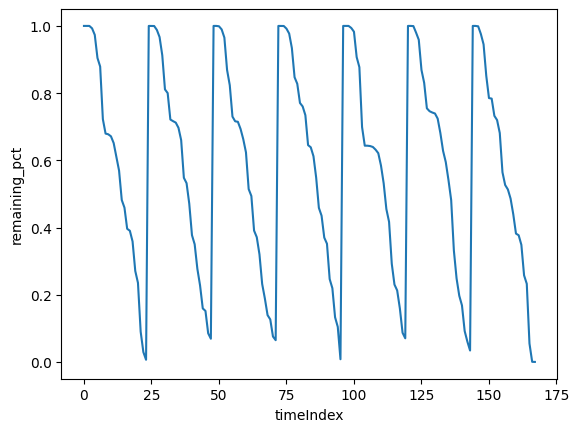

In [237]:
sns.lineplot(x=selected_agent_budget_ratio.timeIndex, y=selected_agent_budget_ratio.remaining_pct);

## tick aggregation

In [276]:
timeIndexStats = (
    log
    .groupby(["agentIndex", "timeIndex"])
    .agg({
        "pvIndex": "nunique",
        "marketPrice": "mean",
        "pvValue": "mean"
    })
    .reset_index(drop=False)
)

timeIndexStats

agentIndex  timeIndex  pvIndex  marketPrice   pvValue
0            0.0        0.0      808     0.299351  0.211091
1            0.0        1.0      975     0.333291  0.193823
2            0.0        2.0     1532     0.293731  0.212604
3            0.0        3.0     2314     0.318646  0.230228
4            0.0        4.0     3195     0.374454  0.223509
...          ...        ...      ...          ...       ...
5035        29.0      163.0     3034     0.269417  0.111323
5036        29.0      164.0     4592     0.248783  0.108970
5037        29.0      165.0     4660     0.233384  0.110091
5038        29.0      166.0     4481     0.214995  0.110498
5039        29.0      167.0     4352     0.176043  0.111013

[5040 rows x 5 columns]

In [297]:
def plot2(field):
    for i in range(30):
        print(f"plot for agent {i}")
        for j in range(7):
            print(f"plot for day {j}")
            sns.lineplot(
                x=timeIndexStats.loc[timeIndexStats.agentIndex.eq(i) & (timeIndexStats.timeIndex // 24 == j), "timeIndex"], 
                y=timeIndexStats.loc[timeIndexStats.agentIndex.eq(i) & (timeIndexStats.timeIndex // 24 == j), field]
            )
            plt.show()
        
        if field == "pvIndex" or field == "marketPrice":
            break

<font size="5">每一天中，agent在每小时能够bid的流量数目存在差异</font>

plot for agent 0
plot for day 0


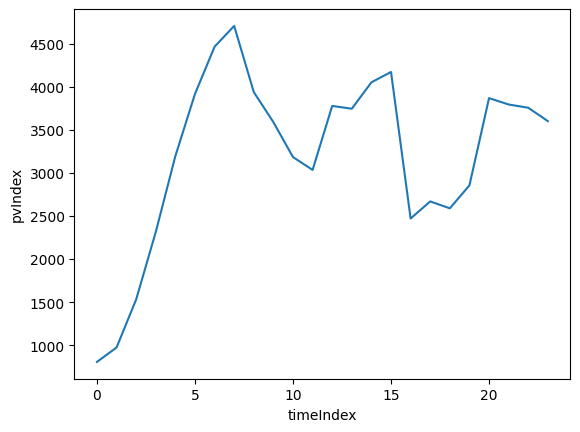

plot for day 1


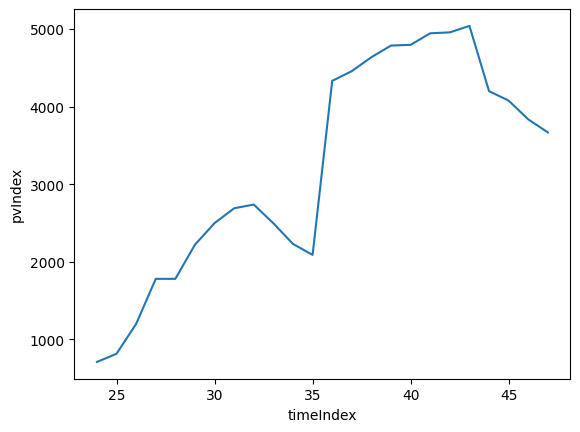

plot for day 2


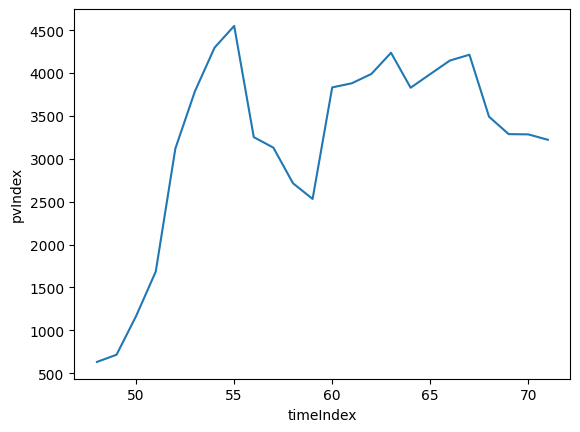

plot for day 3


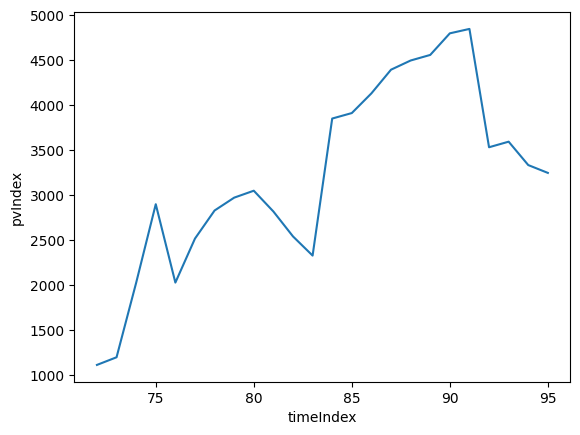

plot for day 4


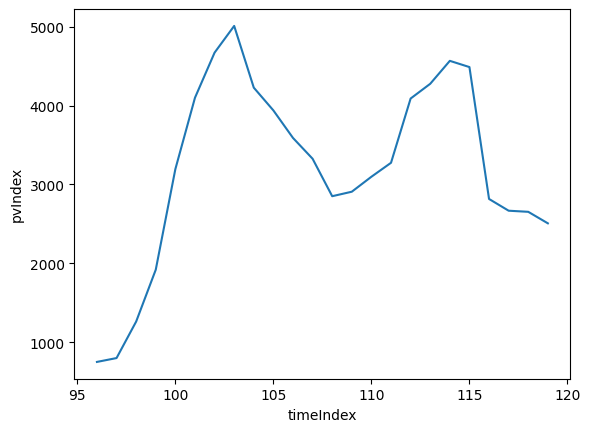

plot for day 5


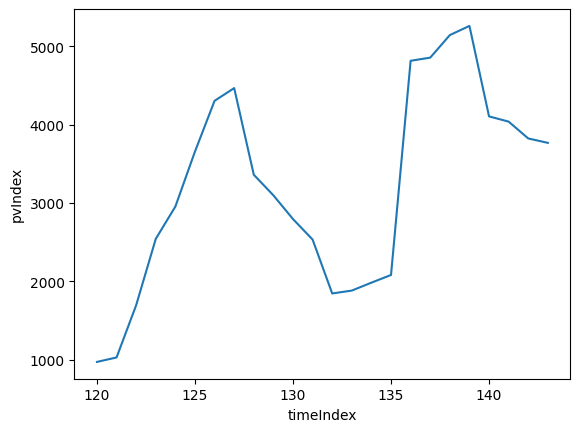

plot for day 6


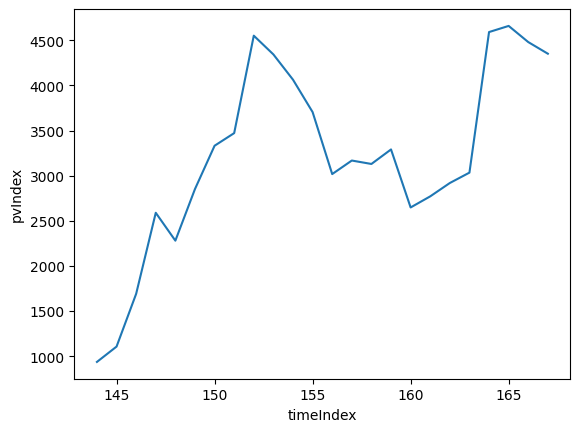

In [298]:
plot2(field="pvIndex")

<font size="5">每一天中，agent在每小时内marketprice变化递减</font>

plot for agent 0
plot for day 0


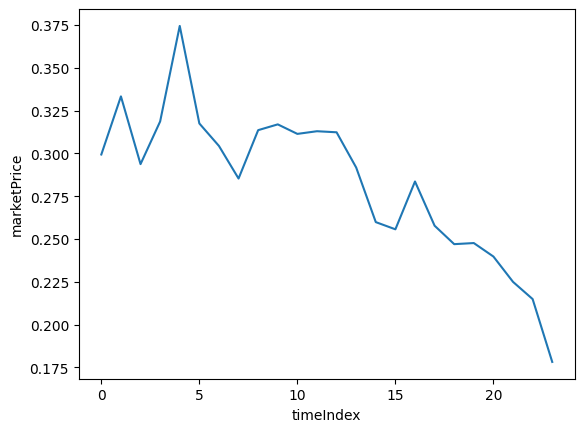

plot for day 1


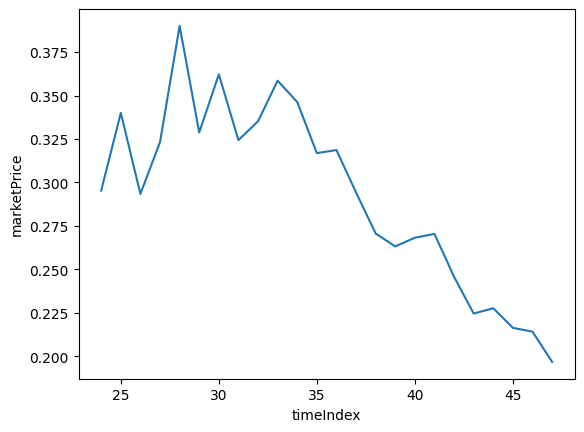

plot for day 2


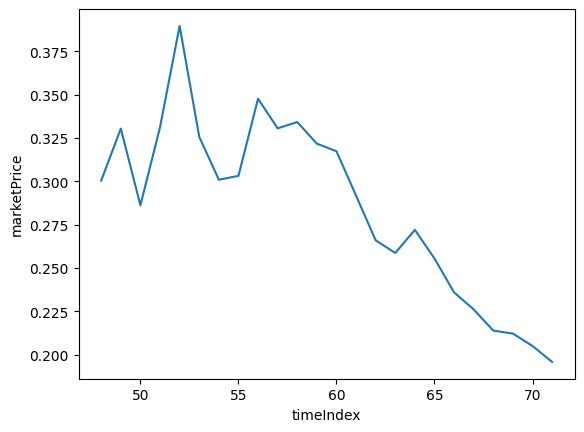

plot for day 3


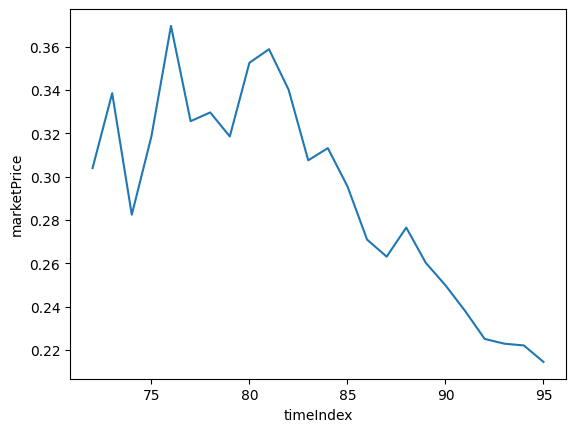

plot for day 4


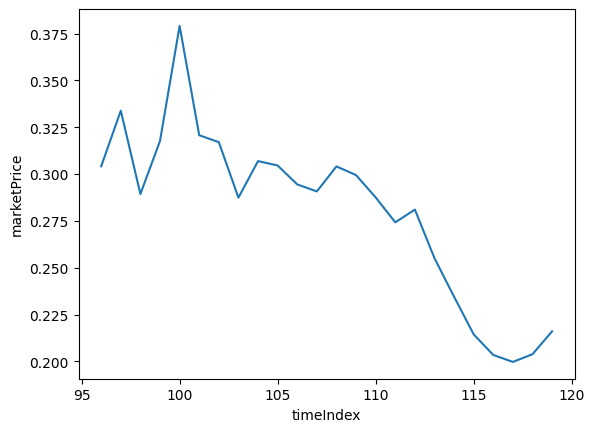

plot for day 5


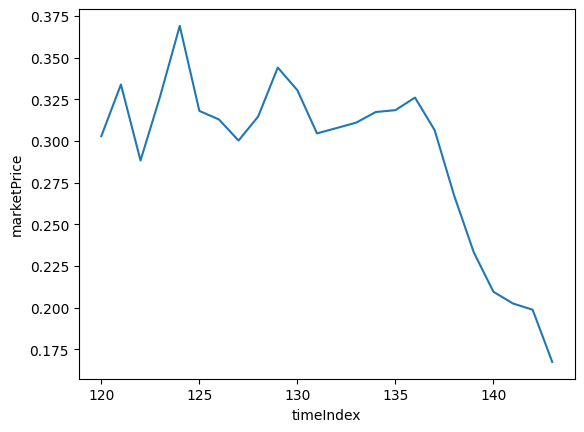

plot for day 6


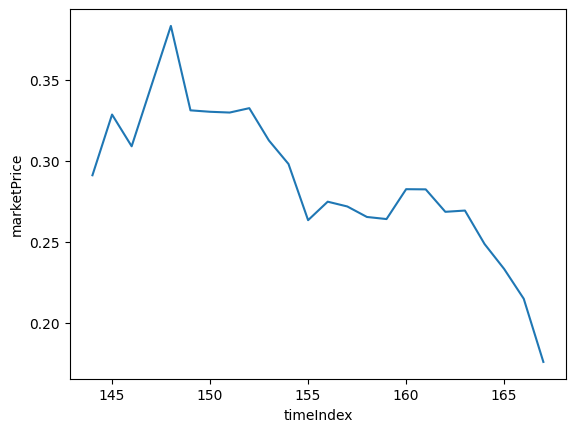

In [299]:
plot2(field="marketPrice")

<font size="5">每一天中，每一category的agent在每小时pvvalue变化趋势有差异 —— cat0,2先减后增，cat1,3先增后减，cat4全天波动较大</font>

plot for agent 0
plot for day 0


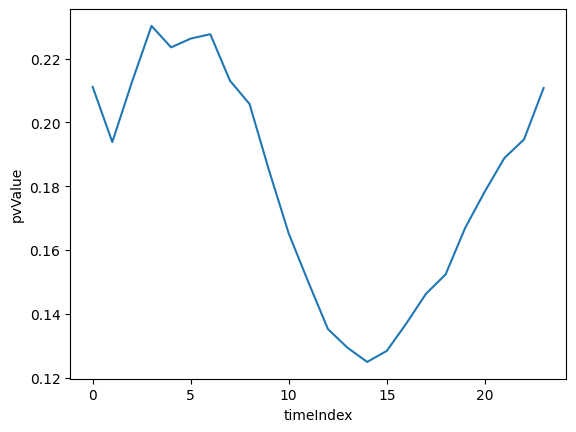

plot for day 1


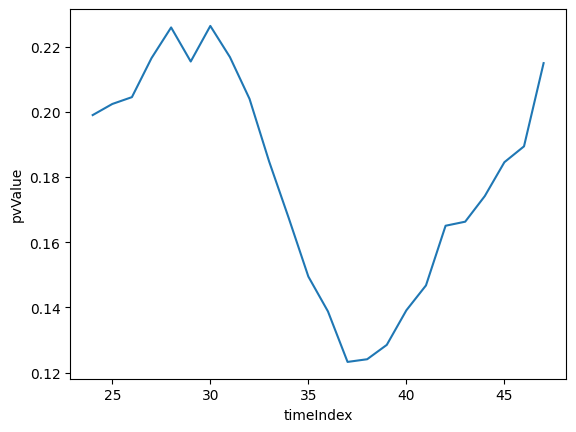

plot for day 2


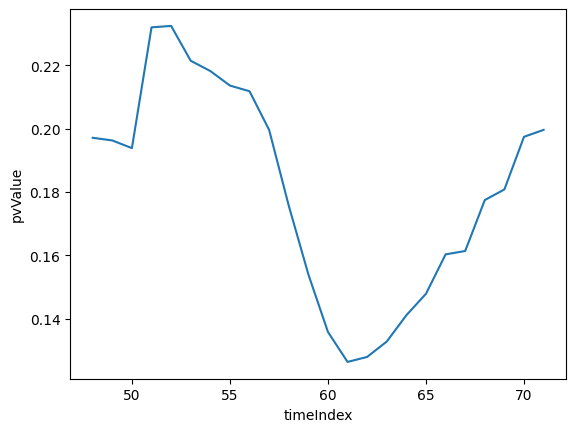

plot for day 3


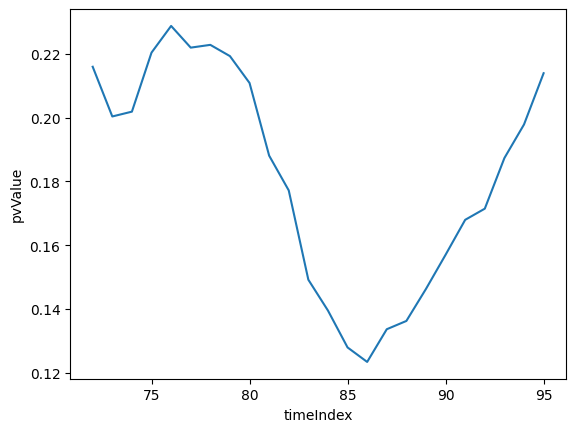

plot for day 4


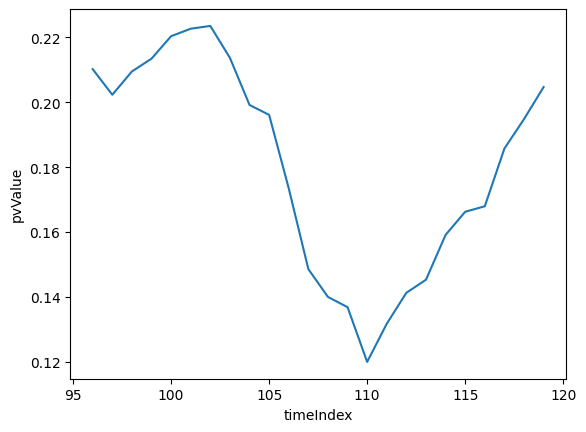

plot for day 5


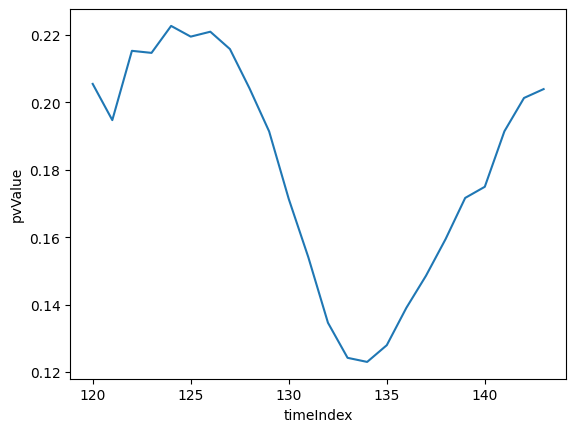

plot for day 6


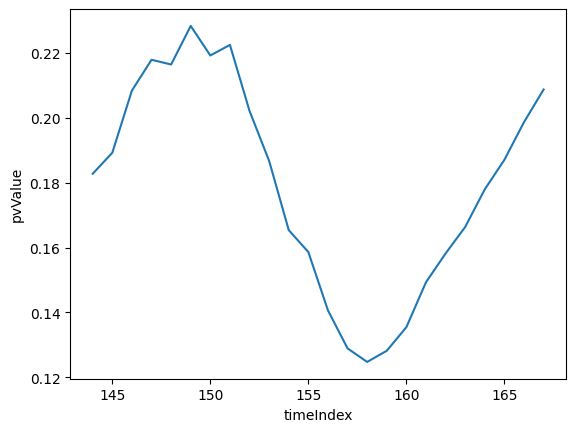

plot for agent 1
plot for day 0


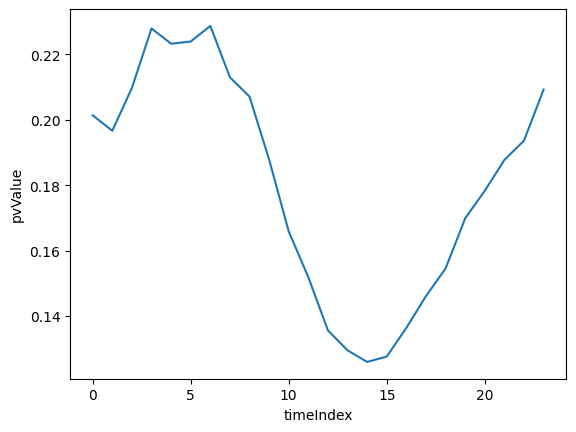

plot for day 1


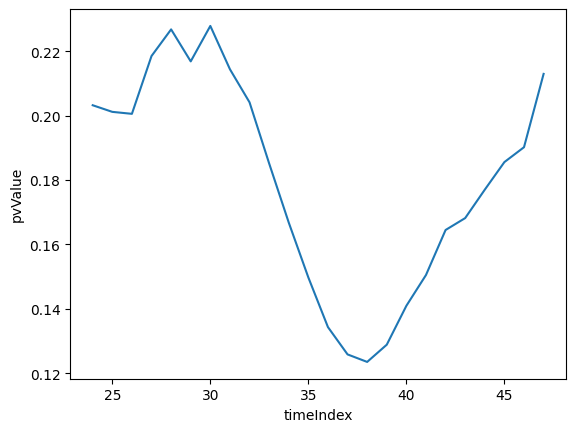

plot for day 2


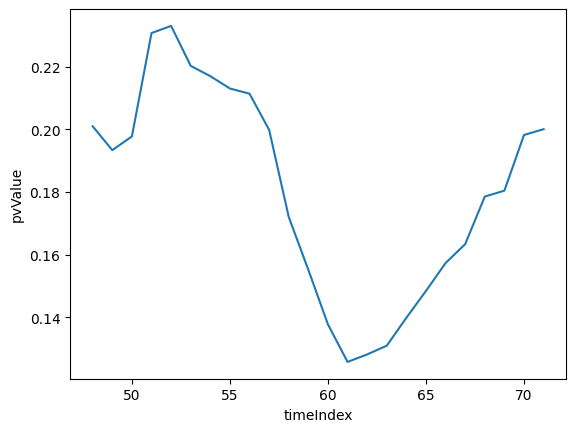

plot for day 3


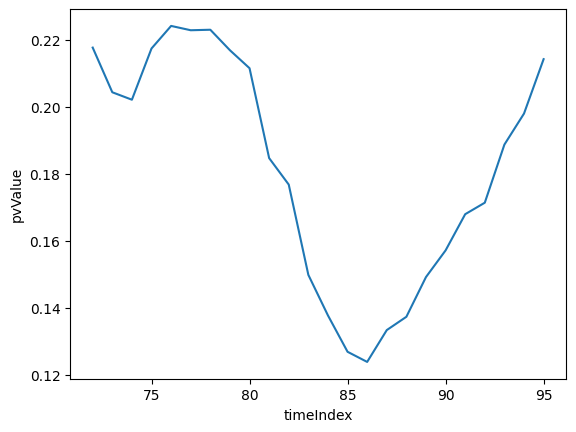

plot for day 4


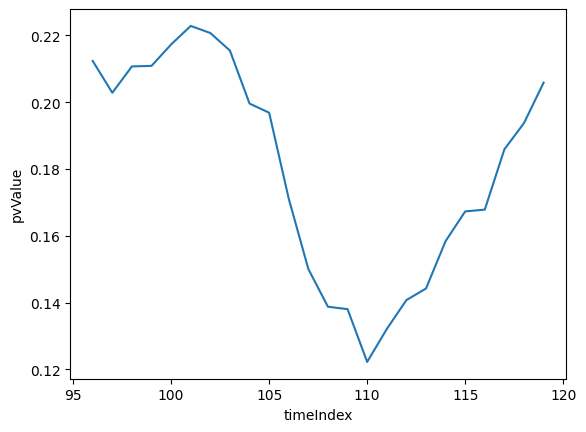

plot for day 5


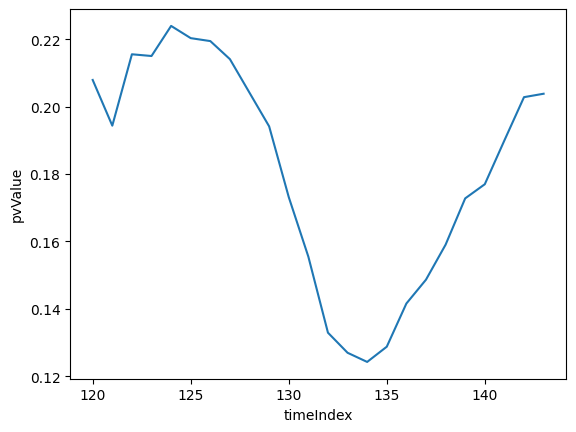

plot for day 6


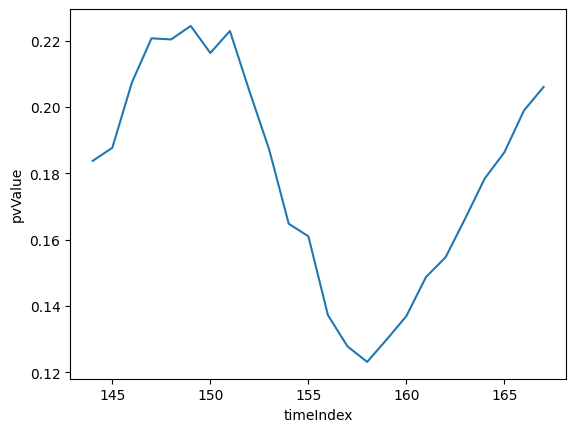

plot for agent 2
plot for day 0


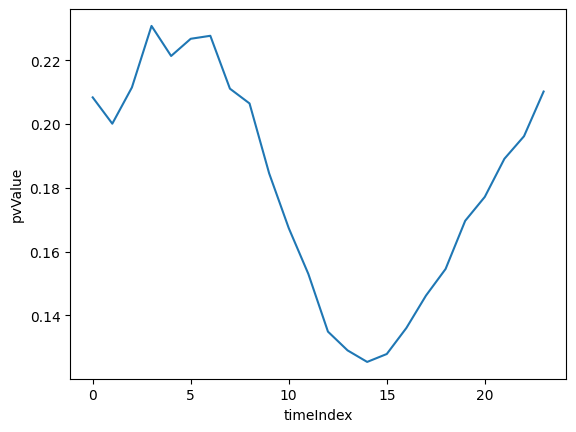

plot for day 1


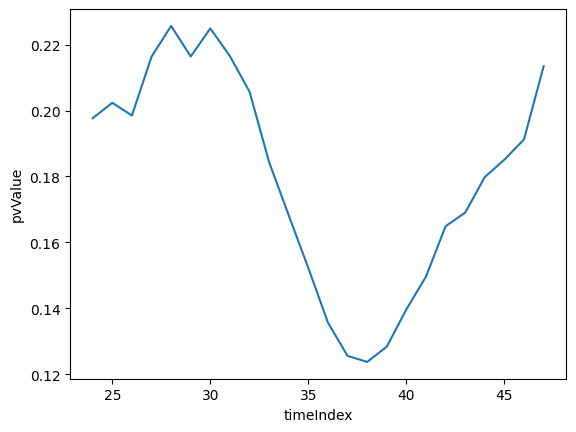

plot for day 2


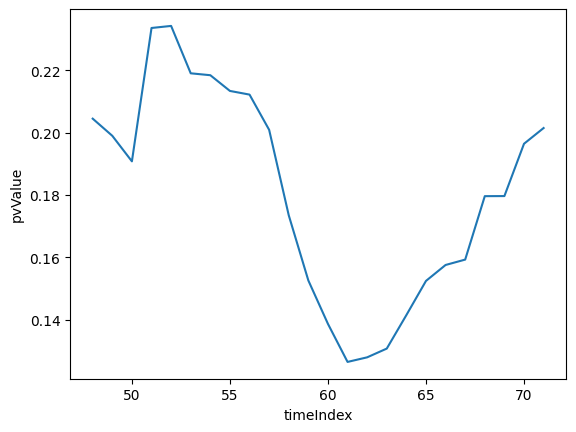

plot for day 3


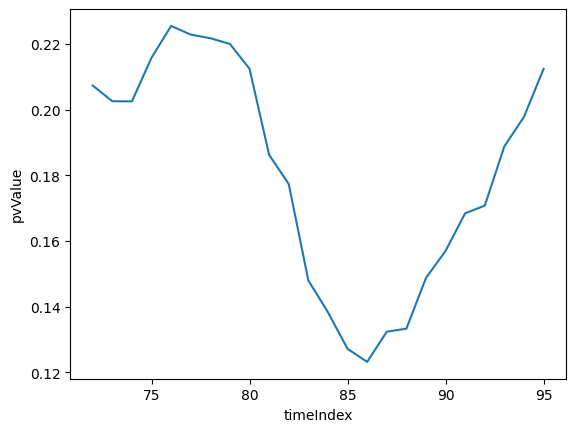

plot for day 4


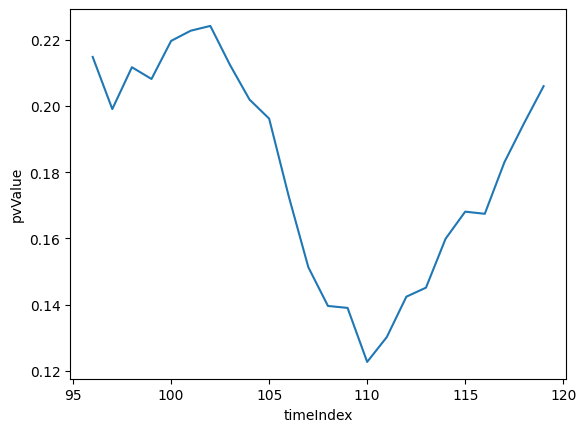

plot for day 5


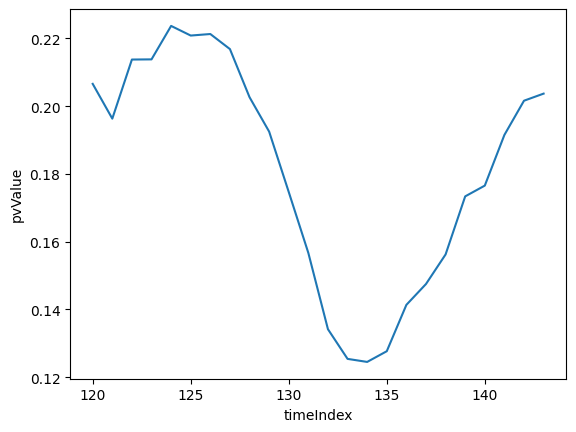

plot for day 6


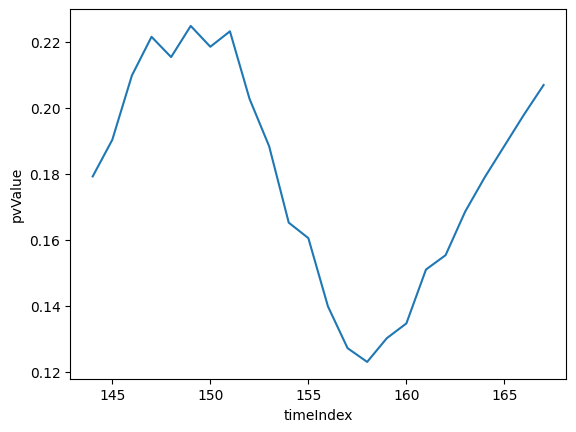

plot for agent 3
plot for day 0


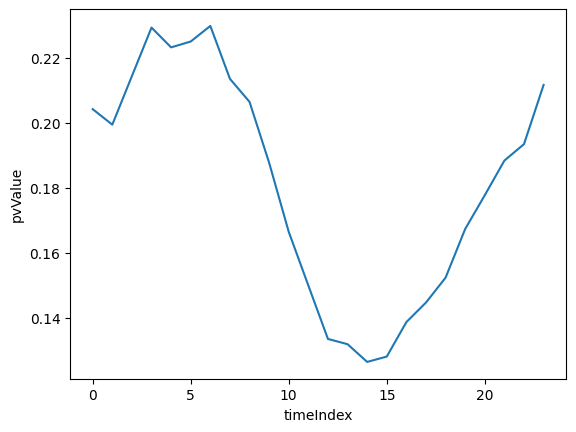

plot for day 1


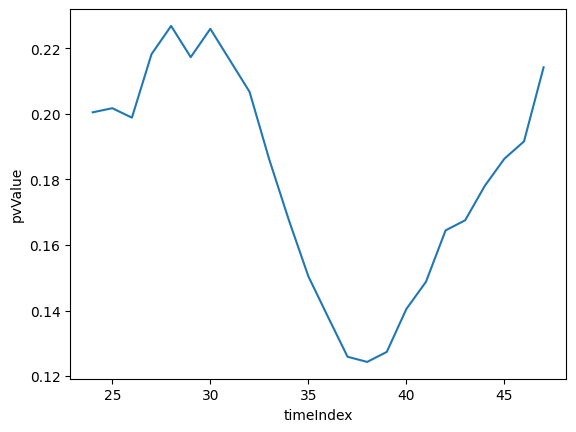

plot for day 2


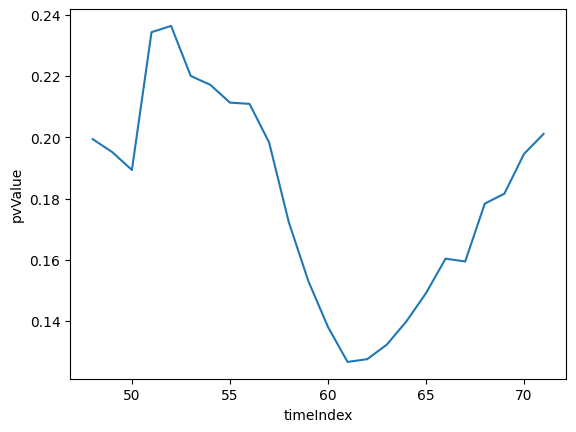

plot for day 3


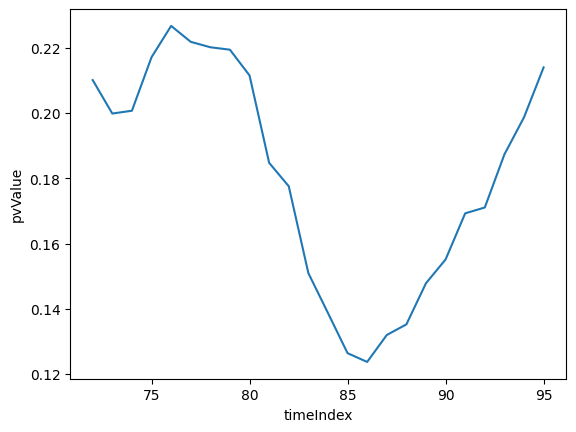

plot for day 4


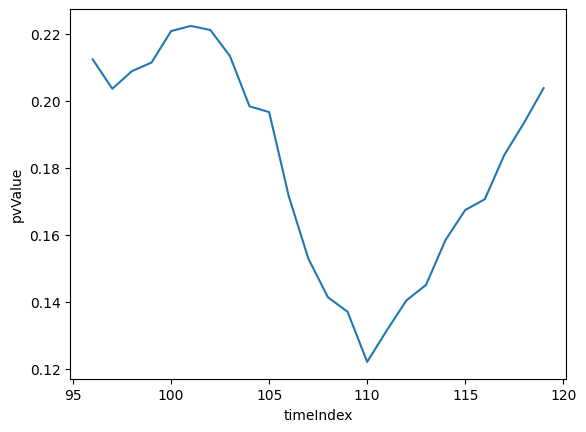

plot for day 5


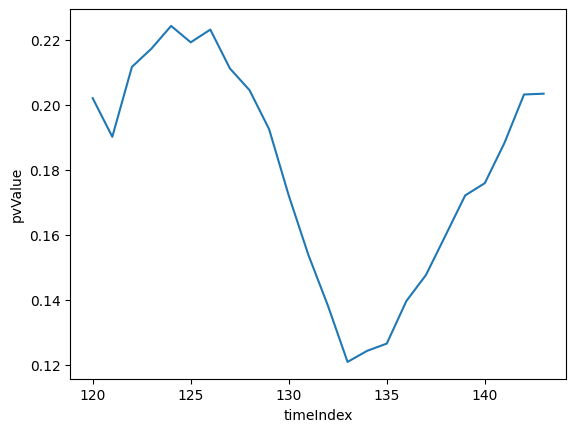

plot for day 6


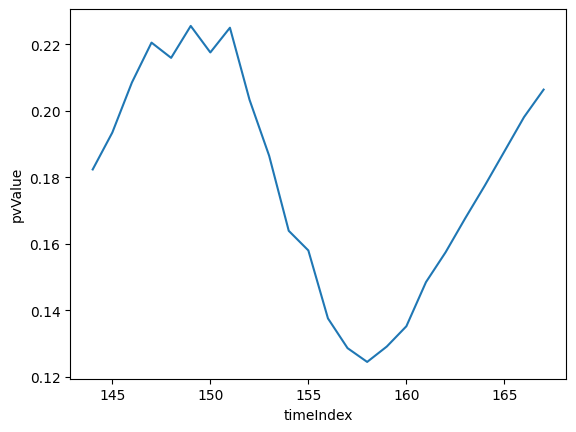

plot for agent 4
plot for day 0


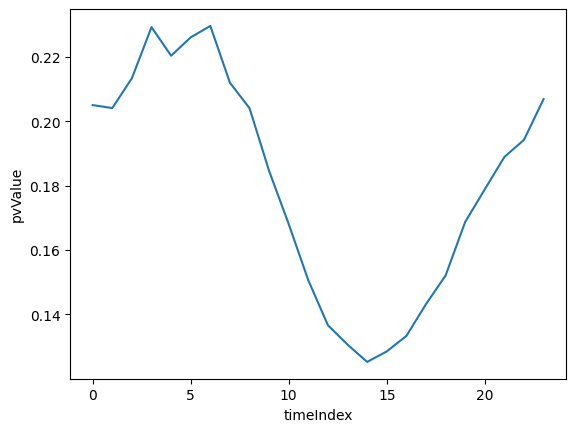

plot for day 1


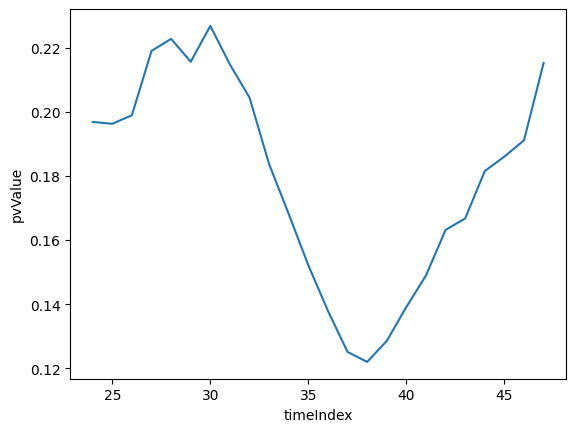

plot for day 2


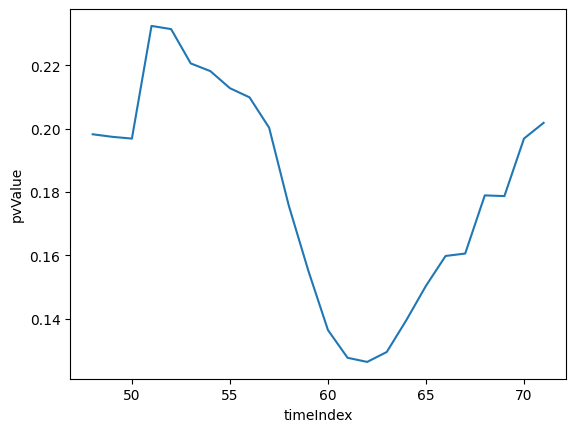

plot for day 3


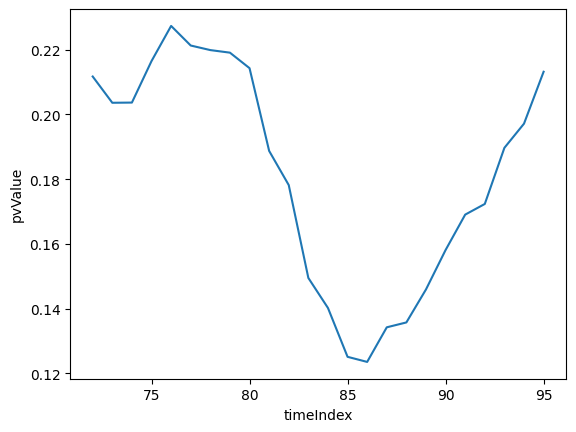

plot for day 4


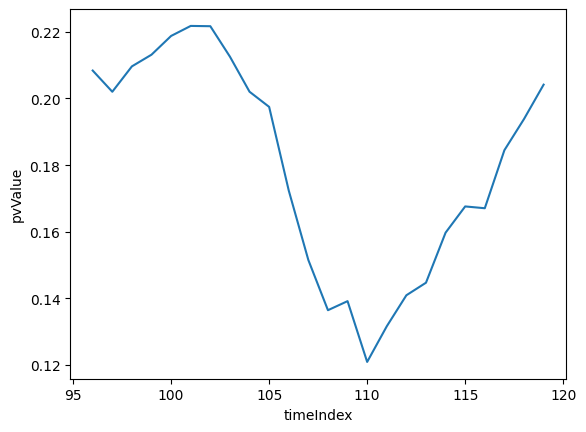

plot for day 5


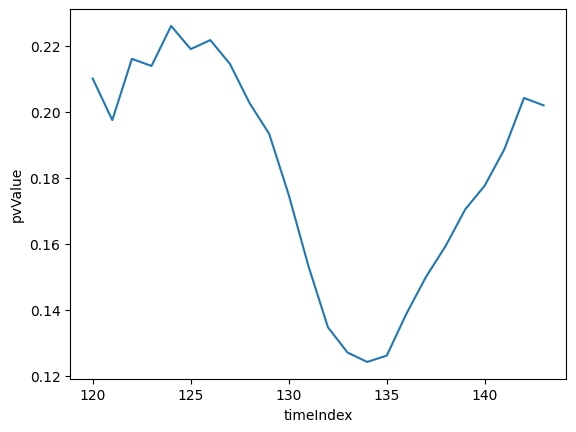

plot for day 6


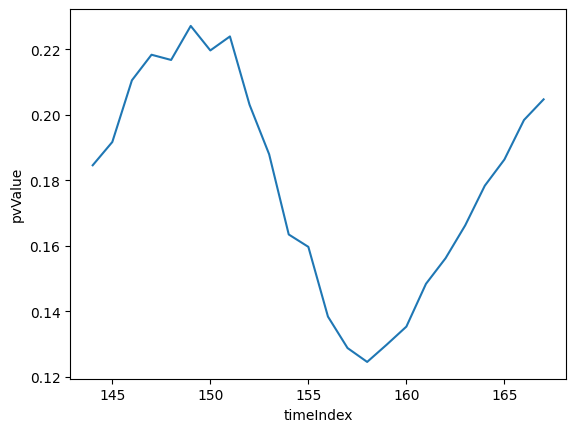

plot for agent 5
plot for day 0


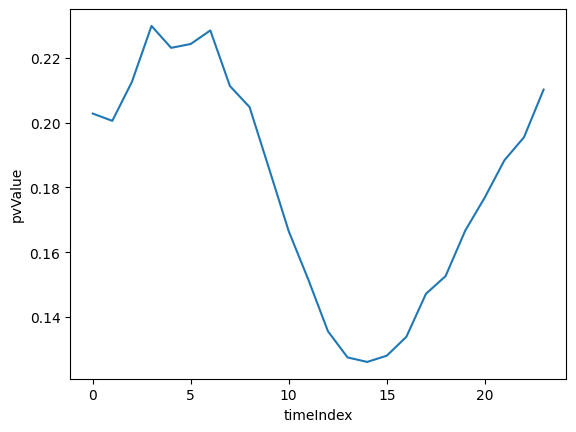

plot for day 1


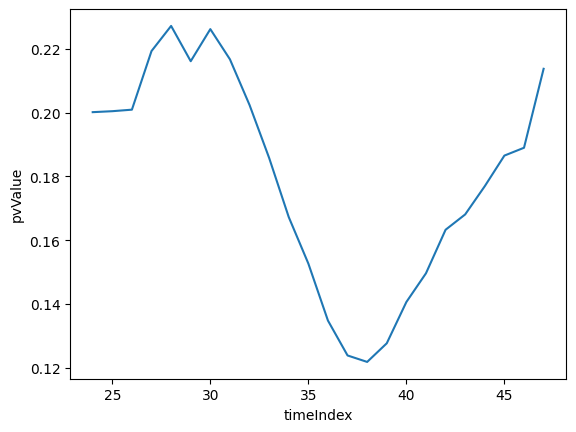

plot for day 2


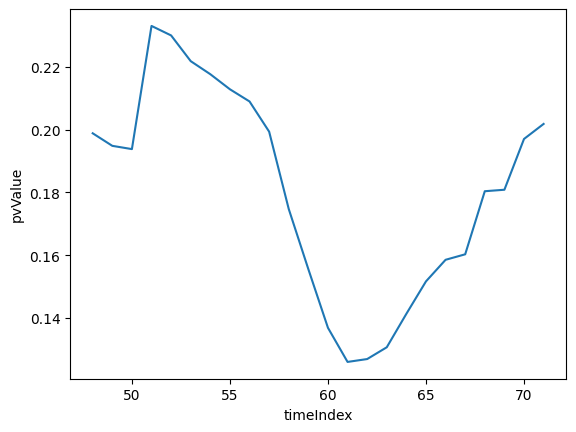

plot for day 3


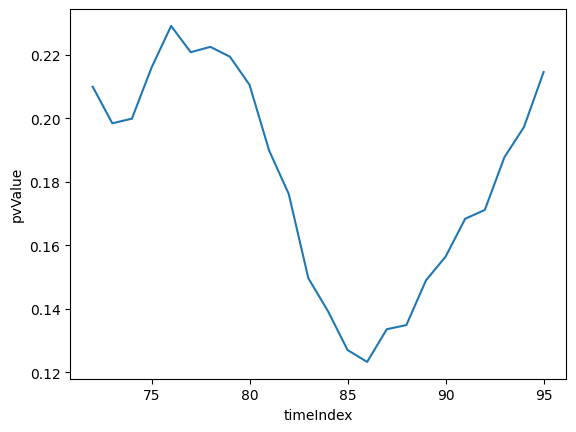

plot for day 4


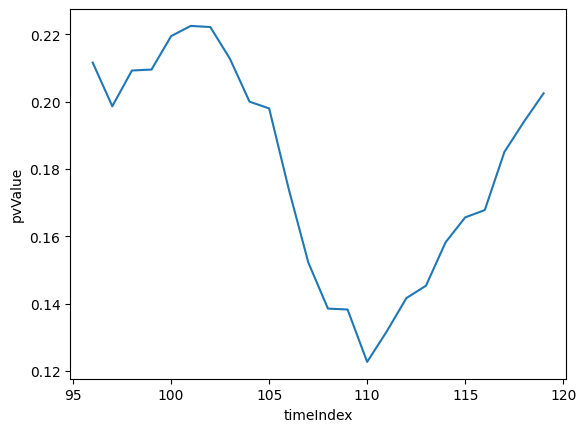

plot for day 5


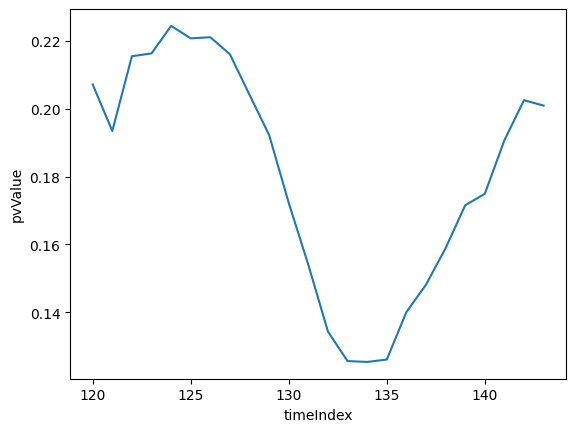

plot for day 6


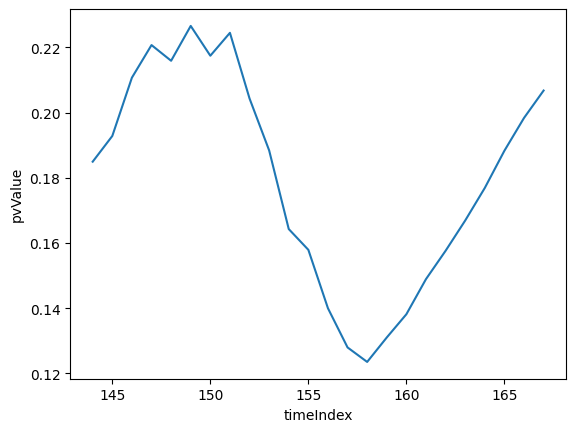

plot for agent 6
plot for day 0


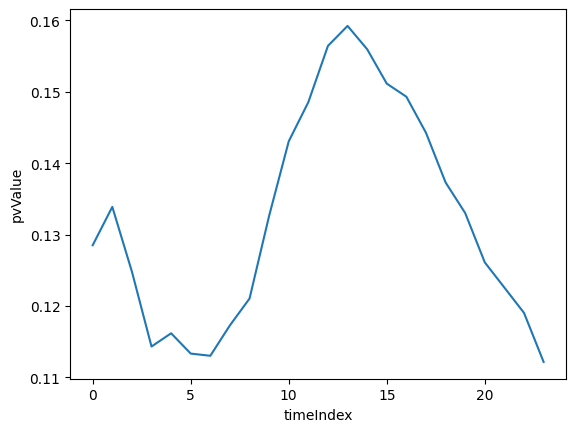

plot for day 1


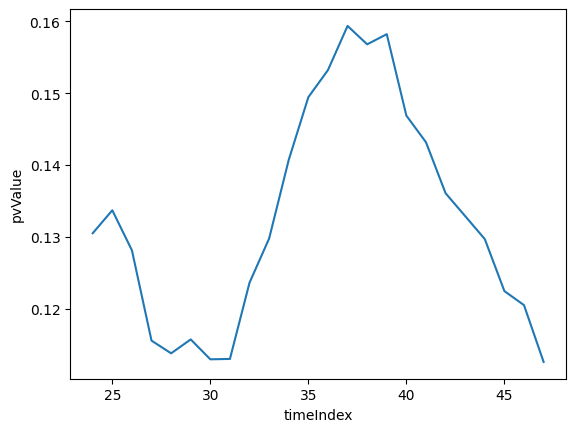

plot for day 2


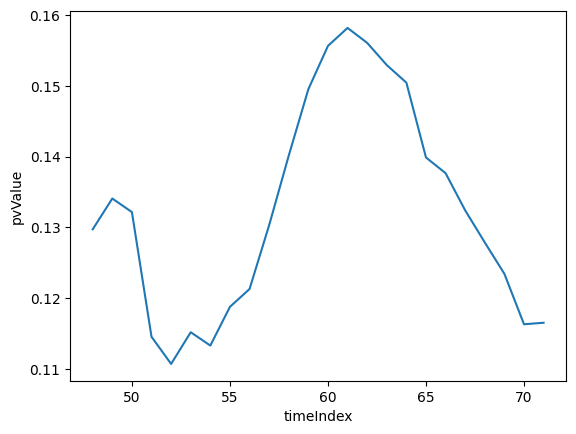

plot for day 3


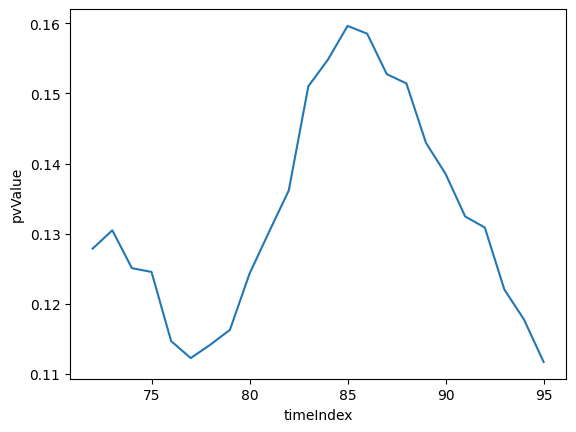

plot for day 4


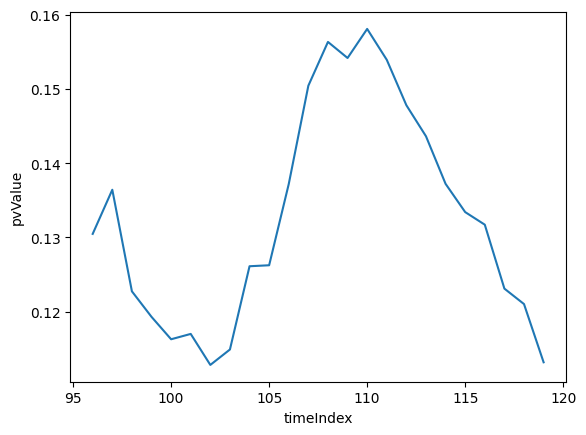

plot for day 5


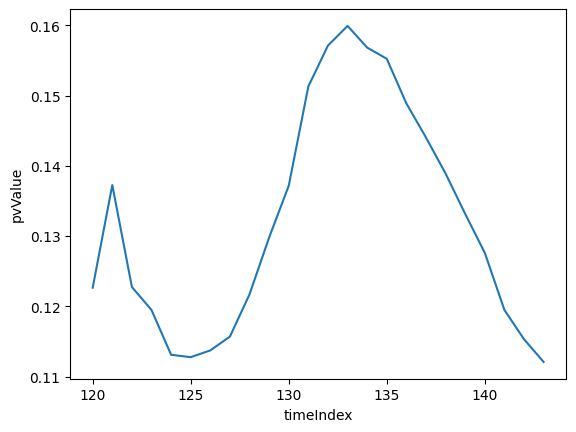

plot for day 6


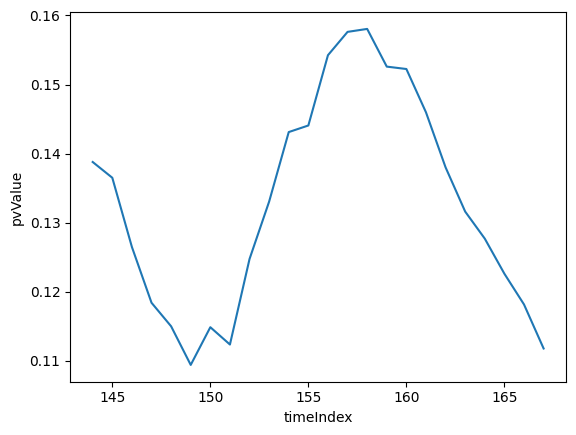

plot for agent 7
plot for day 0


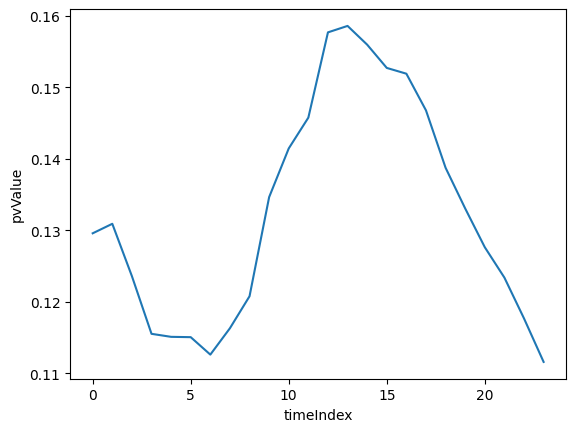

plot for day 1


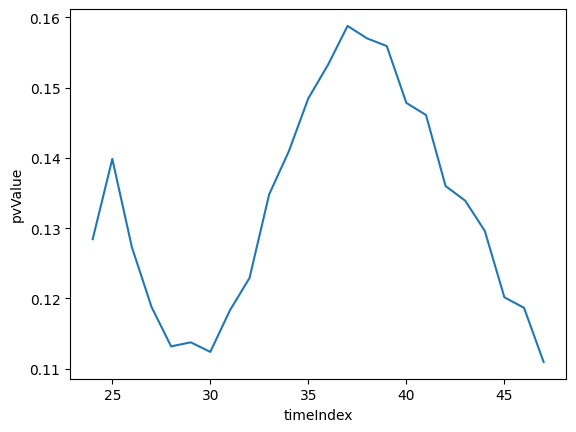

plot for day 2


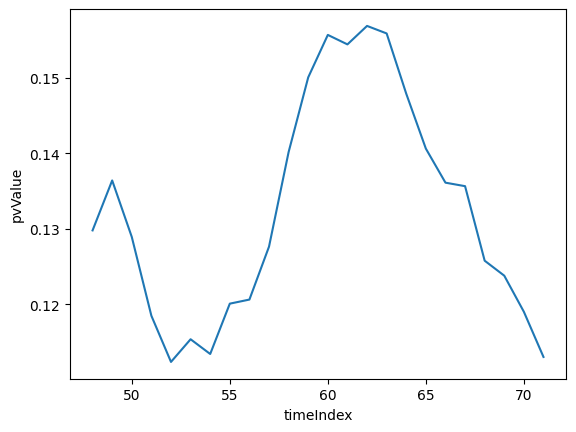

plot for day 3


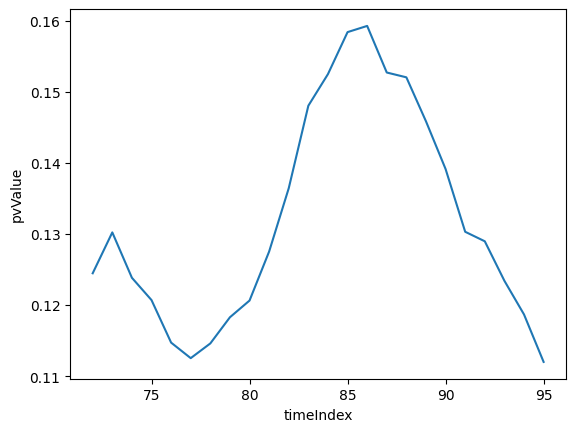

plot for day 4


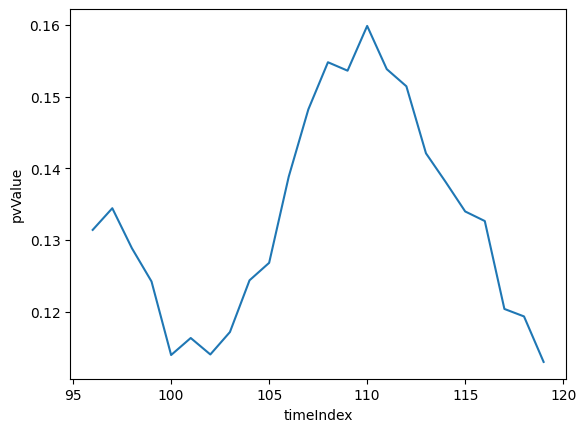

plot for day 5


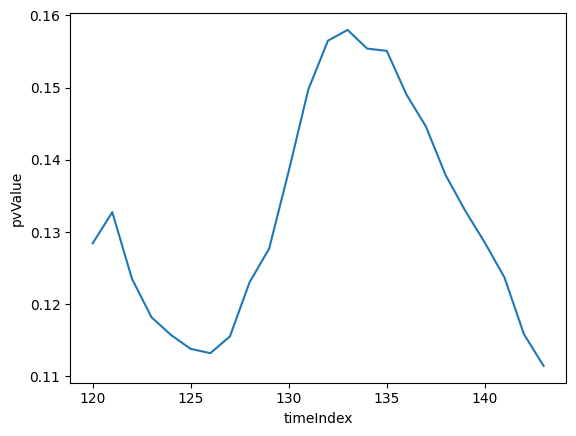

plot for day 6


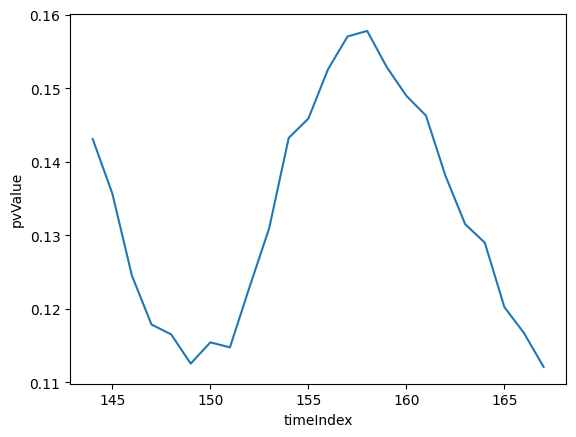

plot for agent 8
plot for day 0


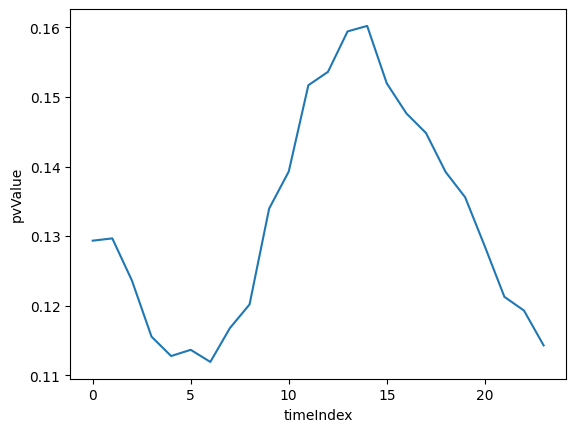

plot for day 1


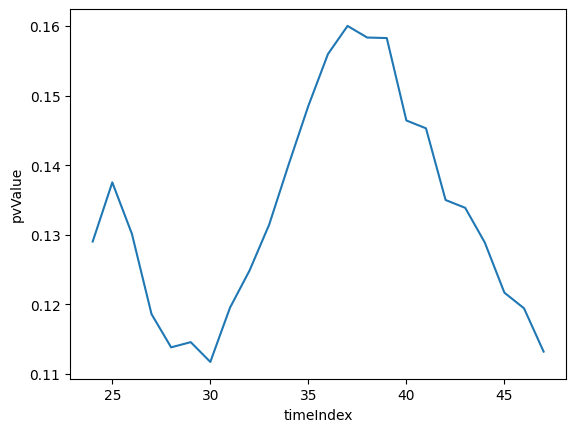

plot for day 2


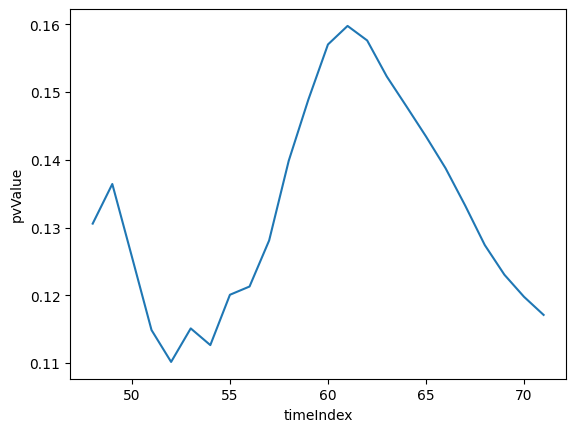

plot for day 3


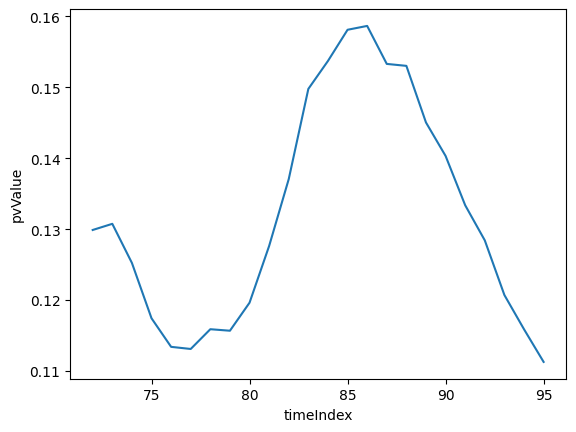

plot for day 4


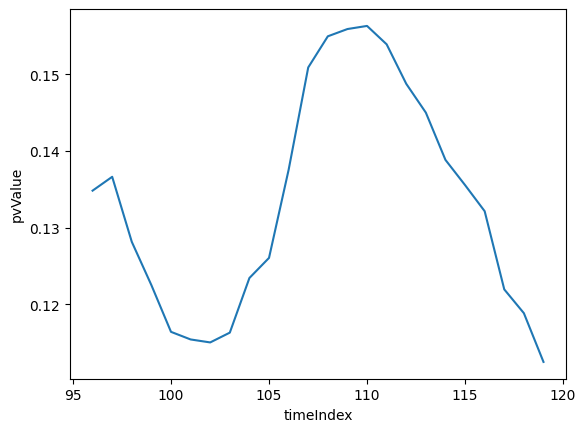

plot for day 5


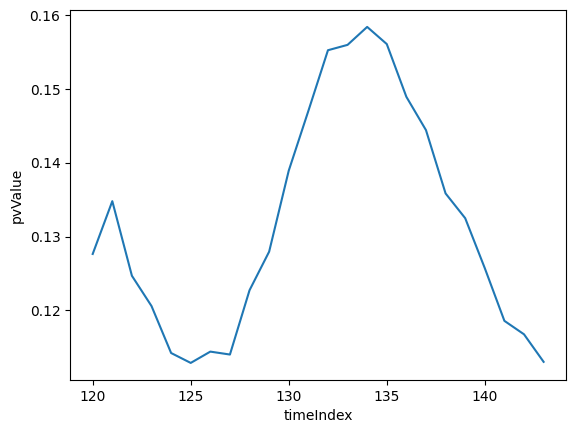

plot for day 6


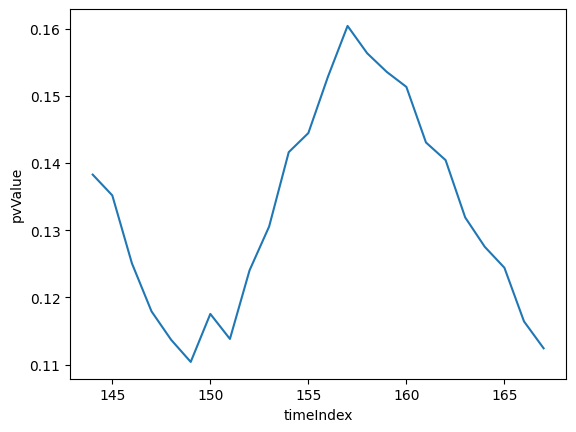

plot for agent 9
plot for day 0


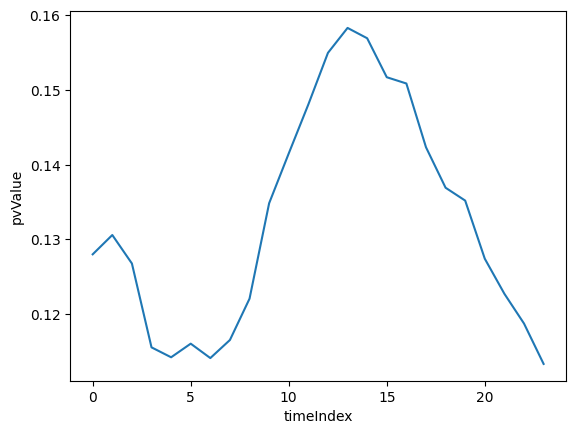

plot for day 1


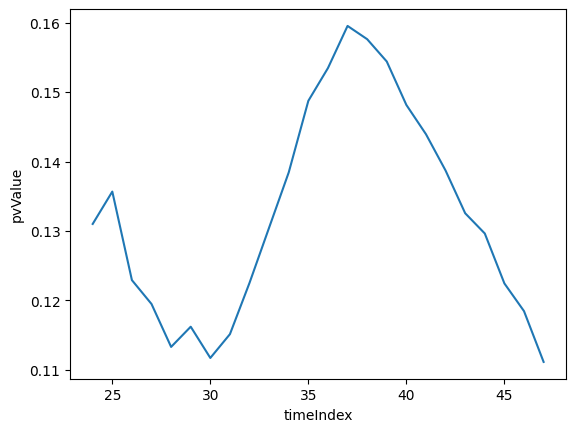

plot for day 2


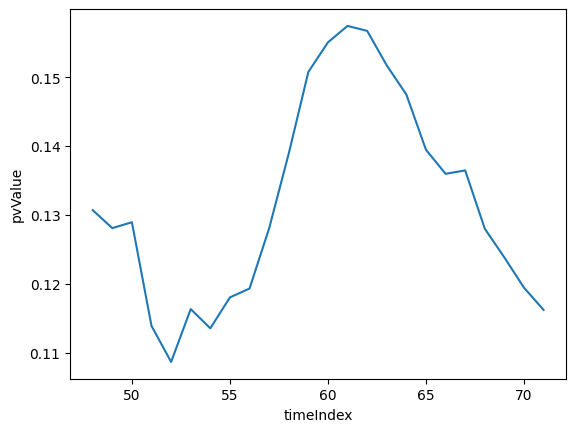

plot for day 3


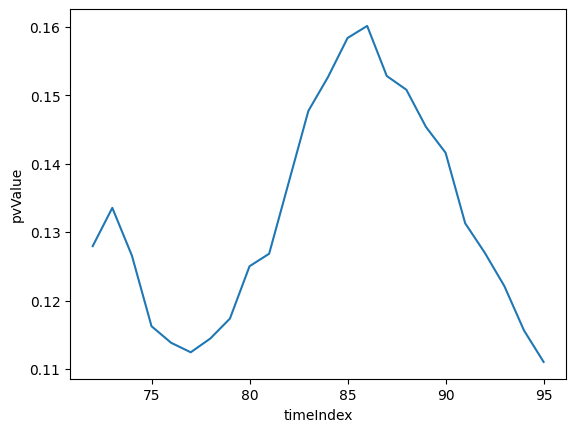

plot for day 4


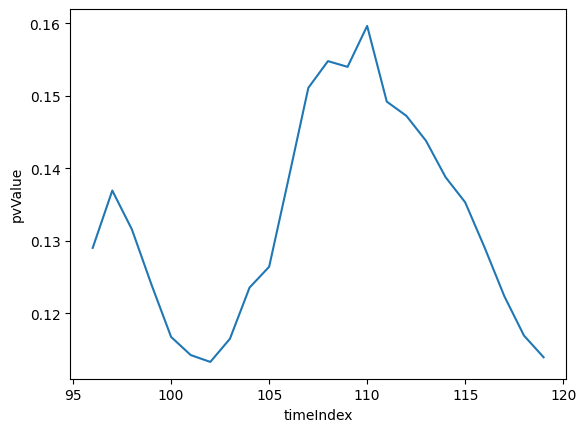

plot for day 5


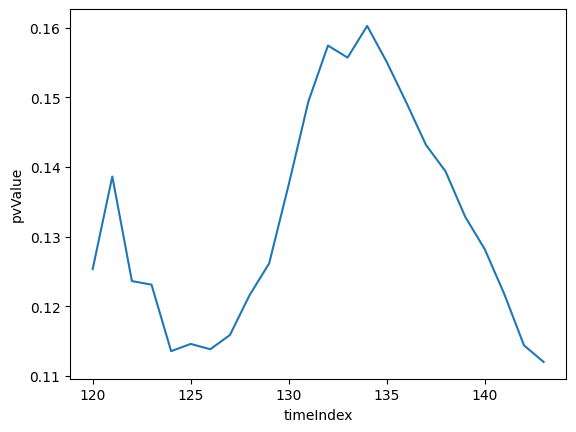

plot for day 6


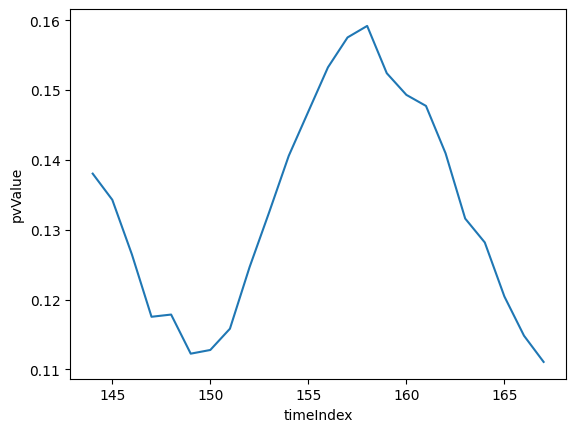

plot for agent 10
plot for day 0


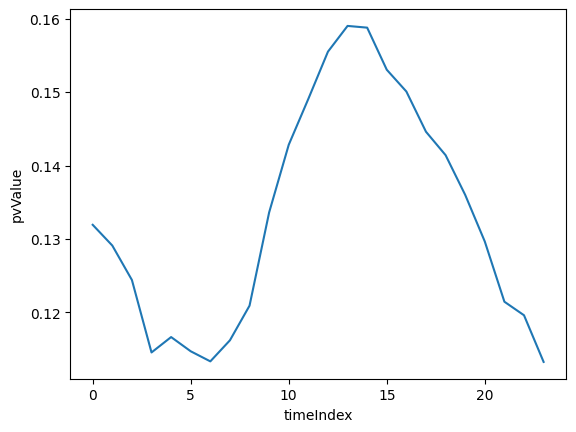

plot for day 1


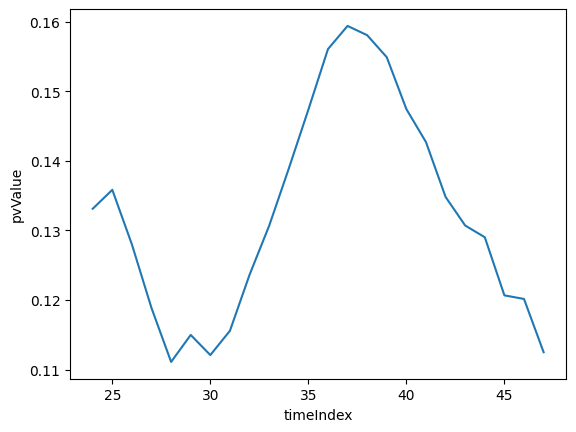

plot for day 2


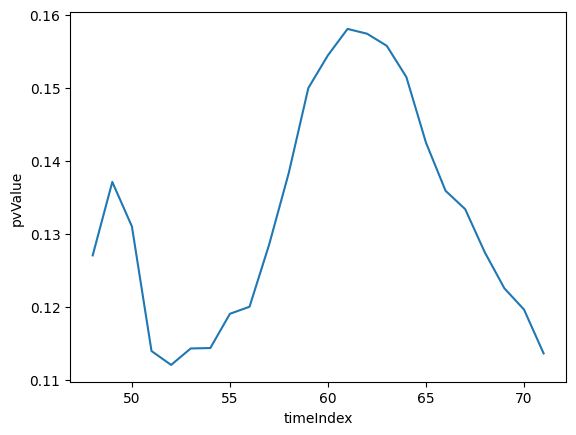

plot for day 3


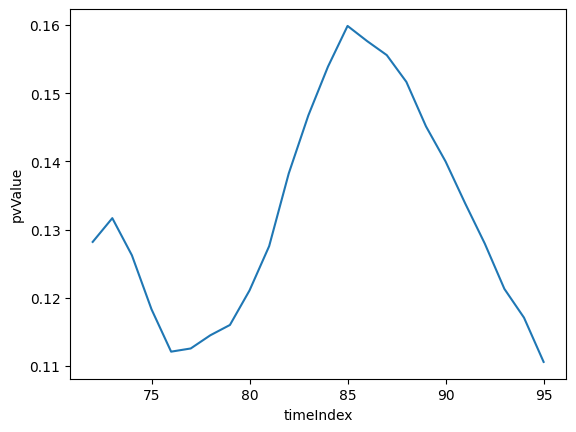

plot for day 4


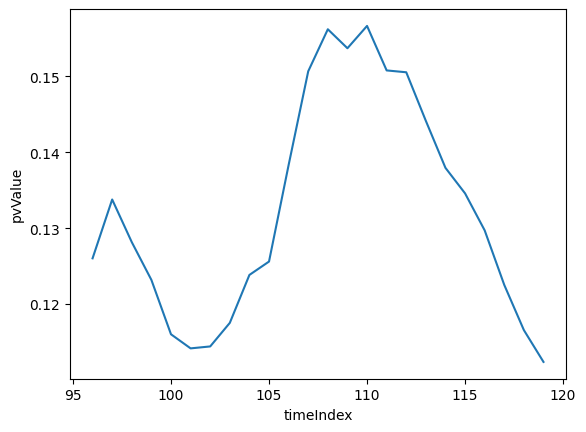

plot for day 5


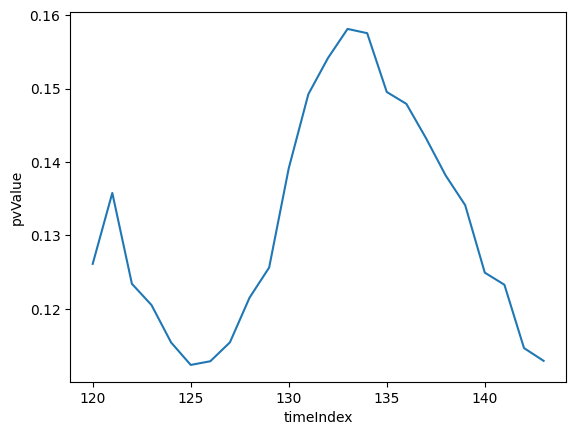

plot for day 6


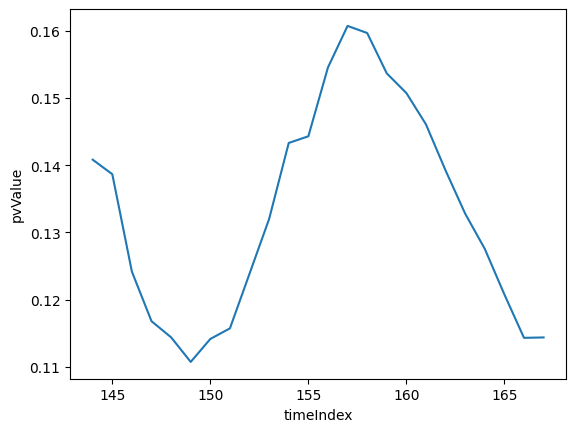

plot for agent 11
plot for day 0


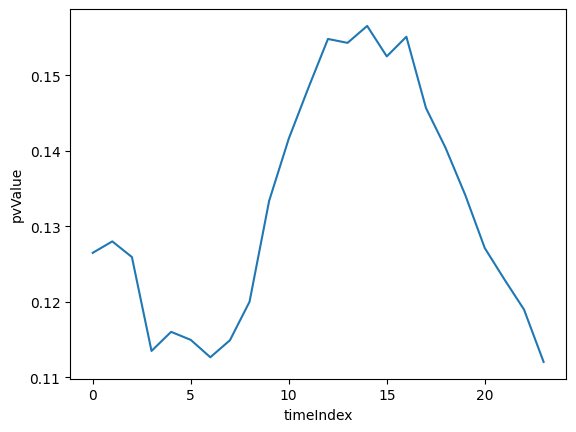

plot for day 1


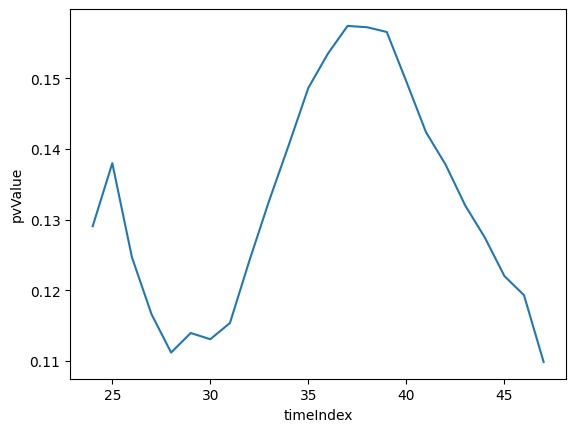

plot for day 2


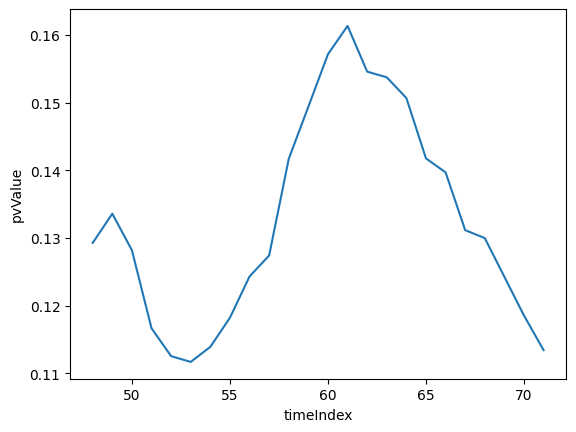

plot for day 3


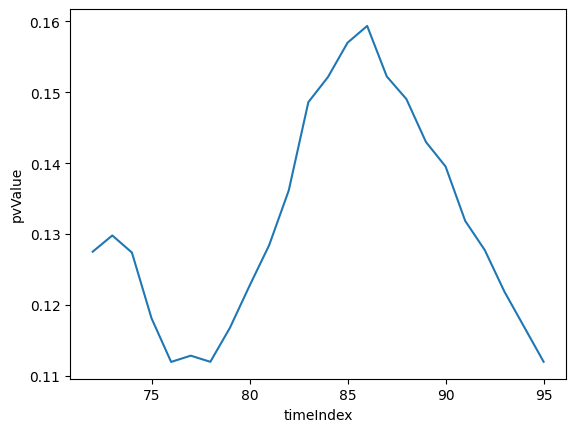

plot for day 4


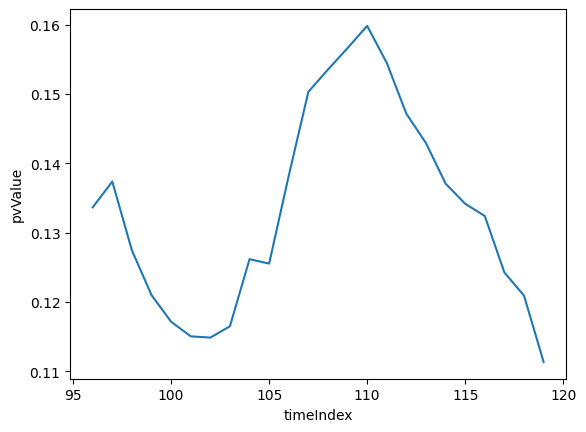

plot for day 5


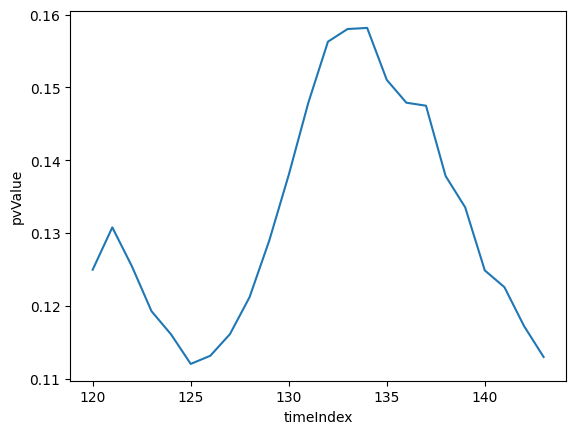

plot for day 6


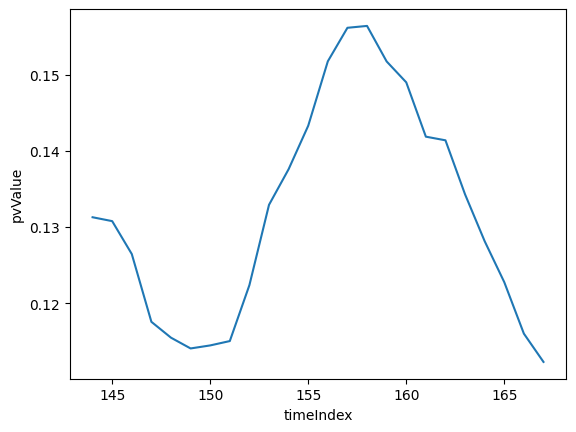

plot for agent 12
plot for day 0


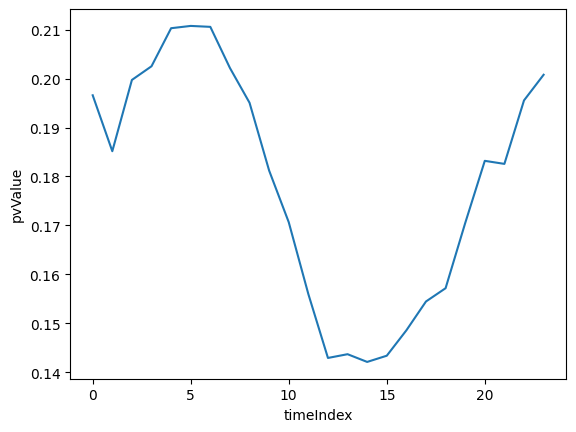

plot for day 1


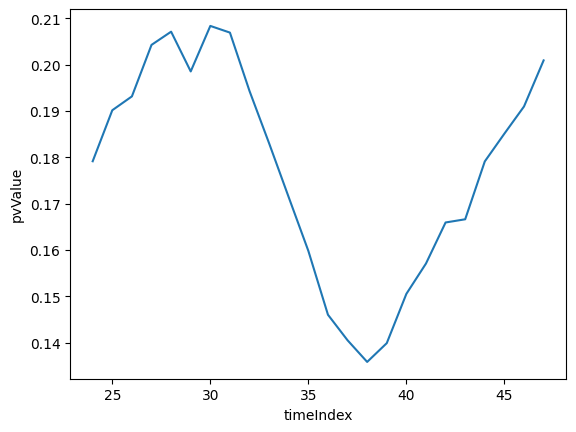

plot for day 2


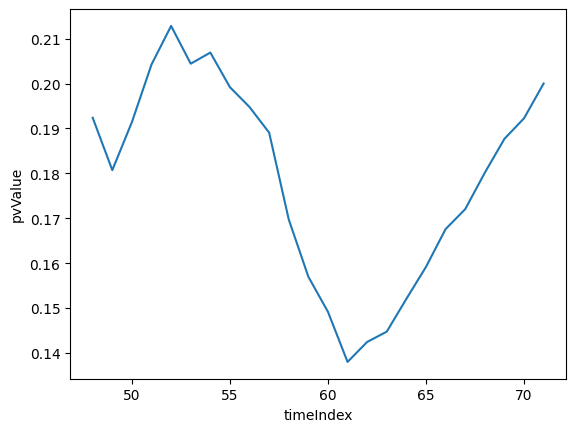

plot for day 3


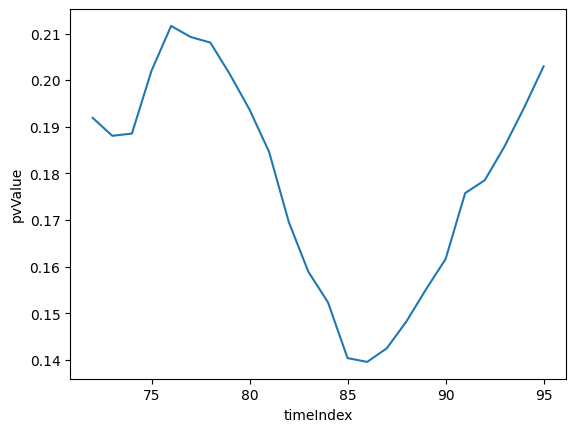

plot for day 4


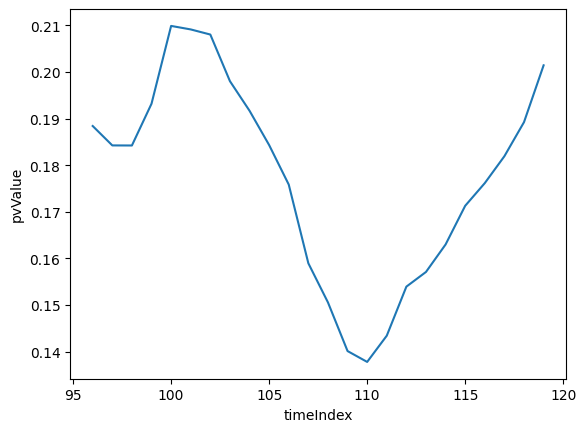

plot for day 5


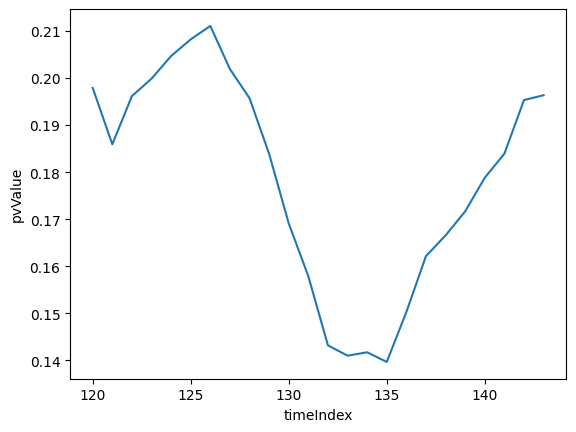

plot for day 6


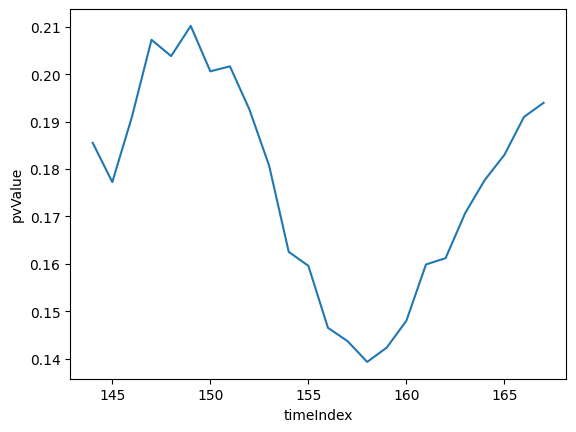

plot for agent 13
plot for day 0


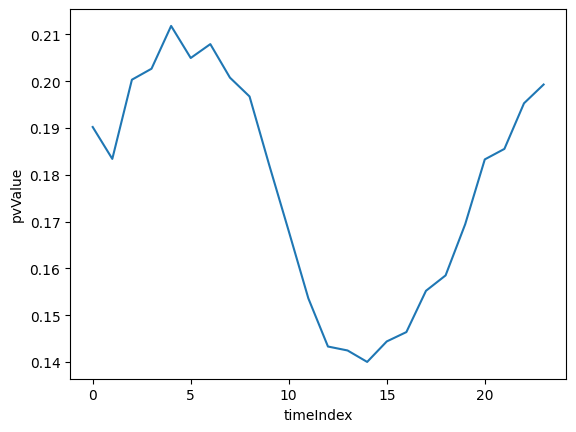

plot for day 1


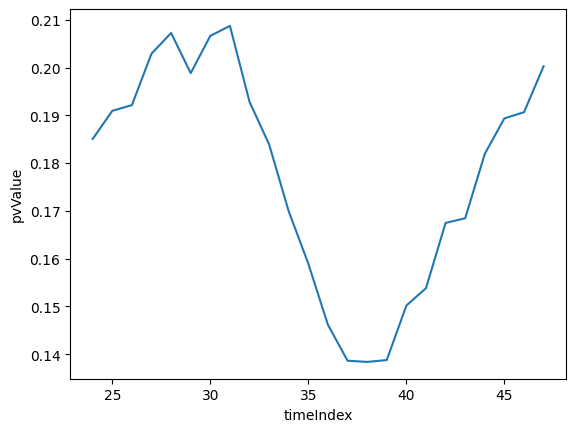

plot for day 2


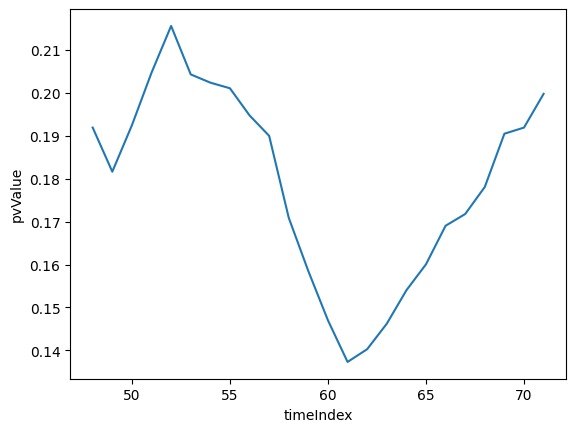

plot for day 3


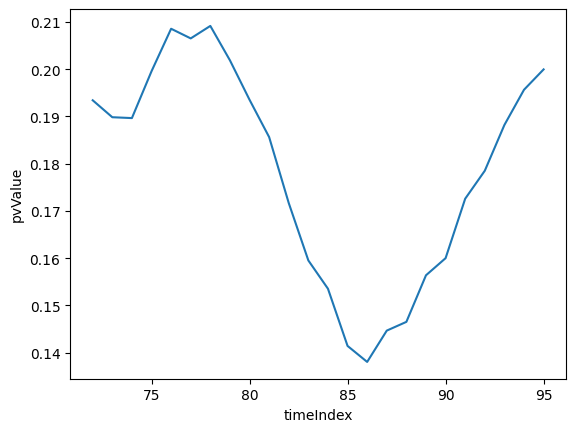

plot for day 4


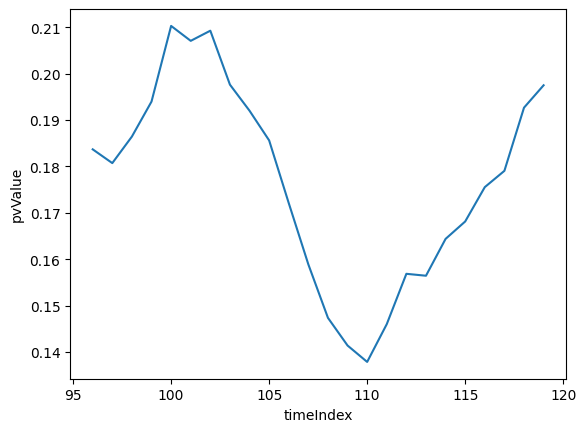

plot for day 5


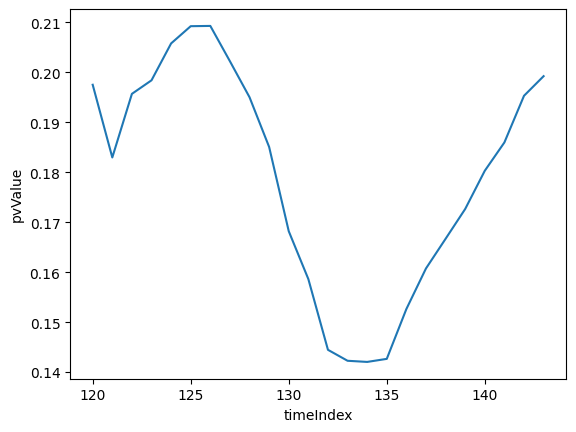

plot for day 6


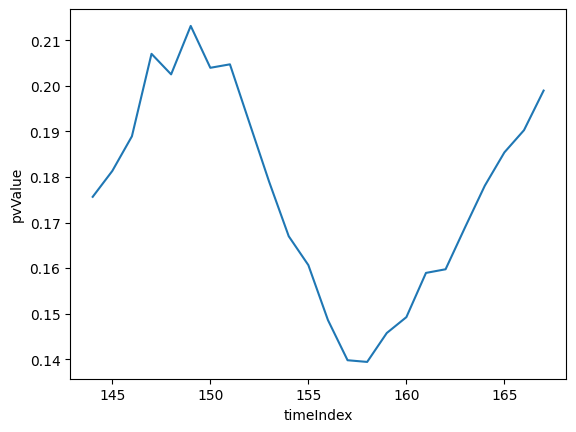

plot for agent 14
plot for day 0


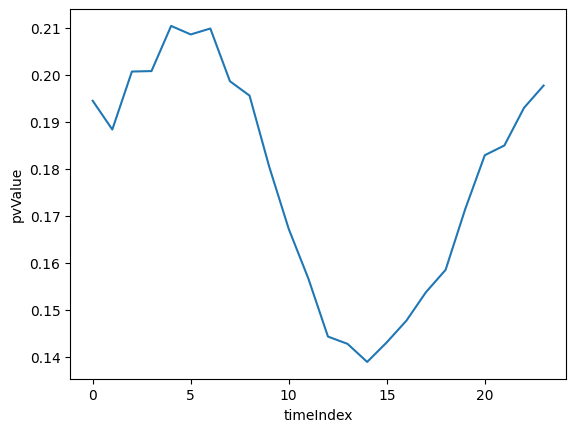

plot for day 1


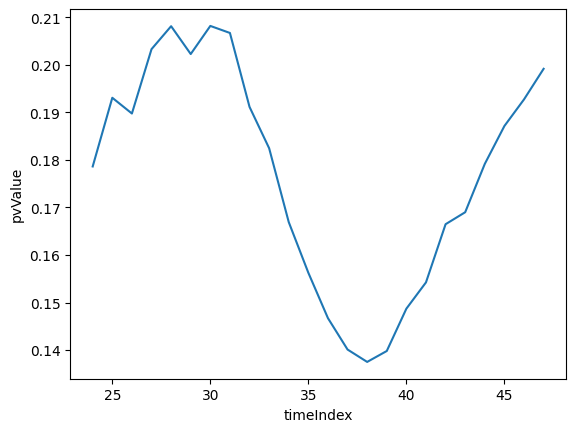

plot for day 2


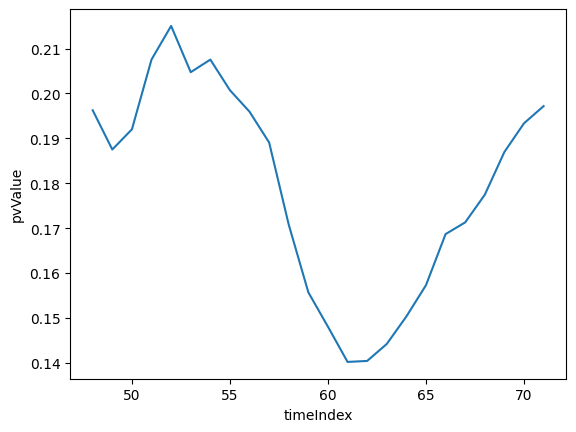

plot for day 3


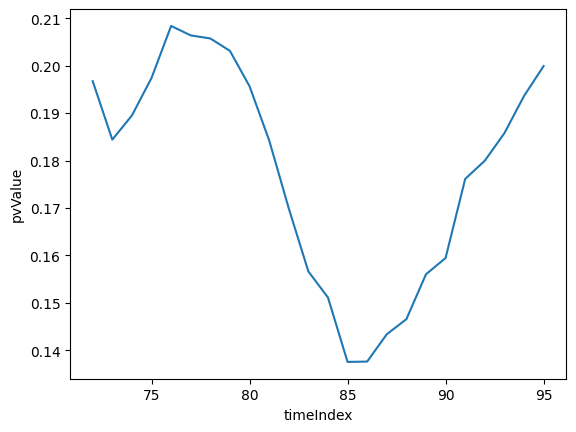

plot for day 4


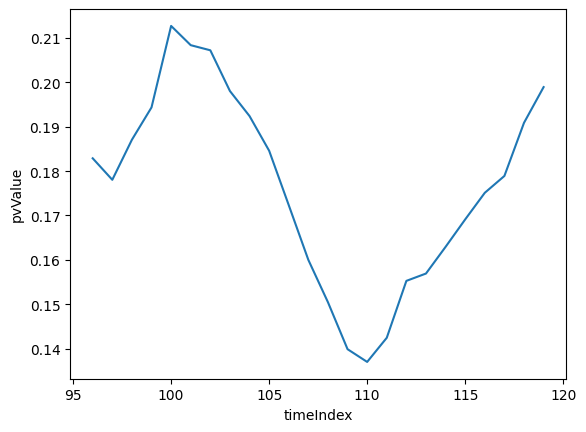

plot for day 5


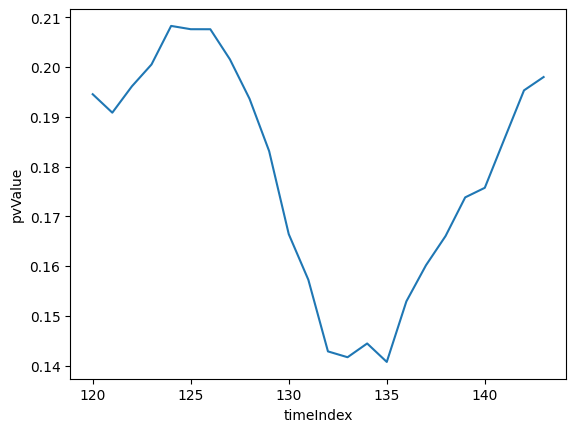

plot for day 6


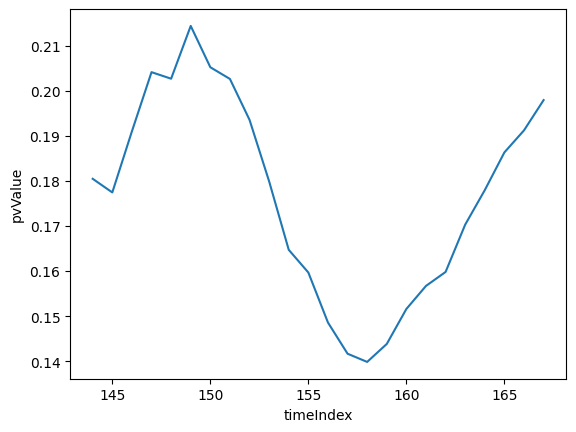

plot for agent 15
plot for day 0


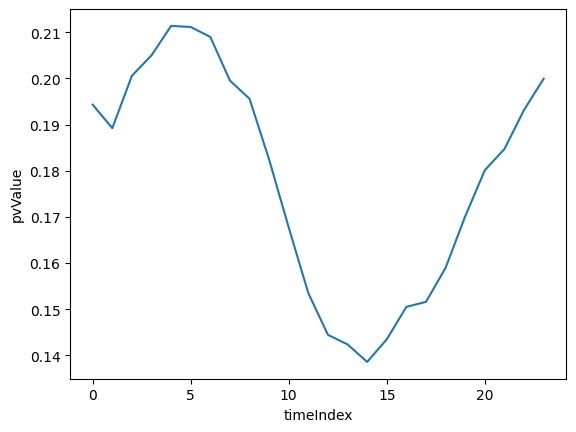

plot for day 1


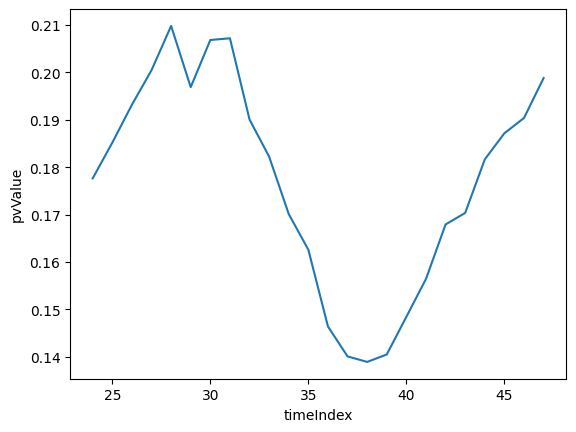

plot for day 2


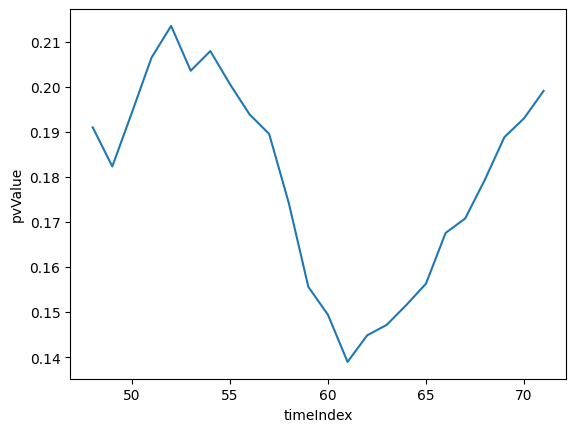

plot for day 3


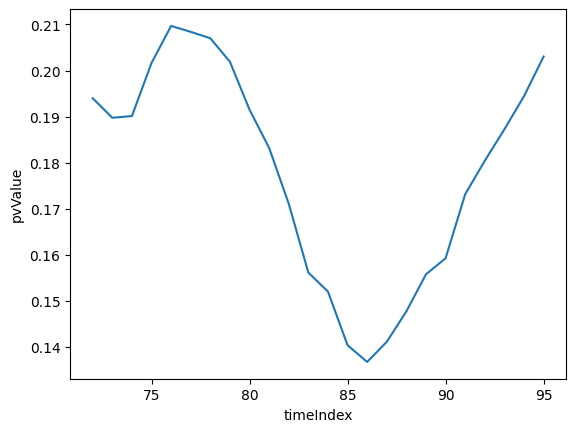

plot for day 4


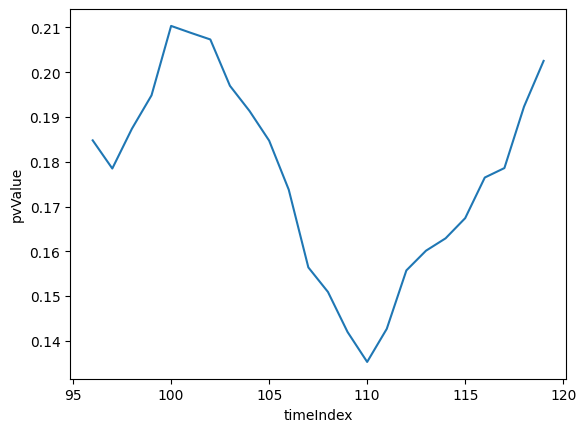

plot for day 5


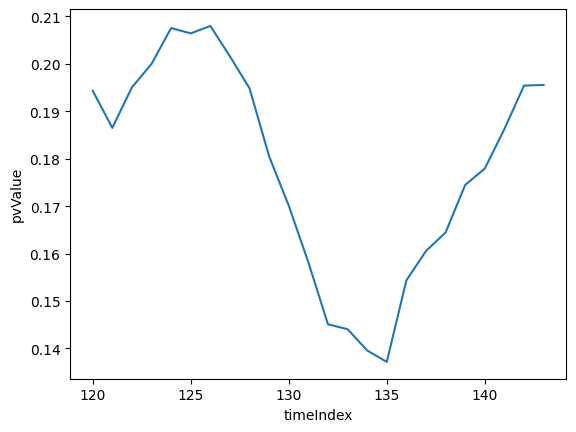

plot for day 6


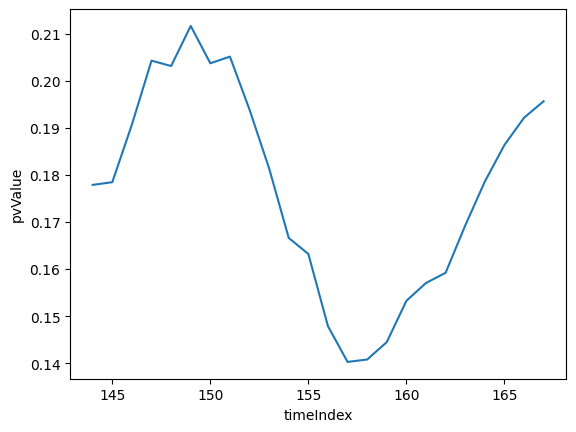

plot for agent 16
plot for day 0


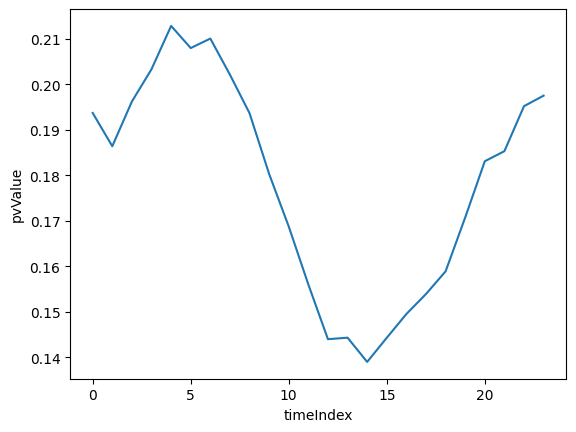

plot for day 1


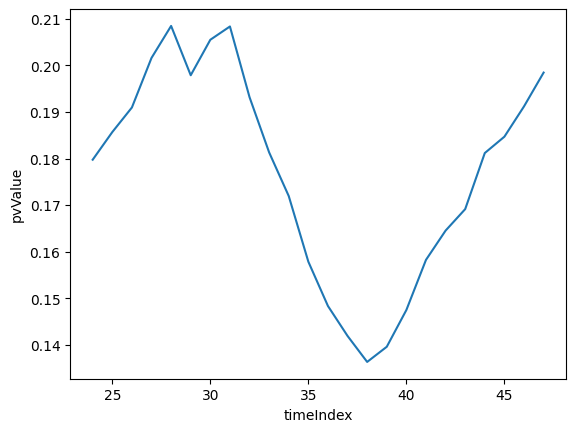

plot for day 2


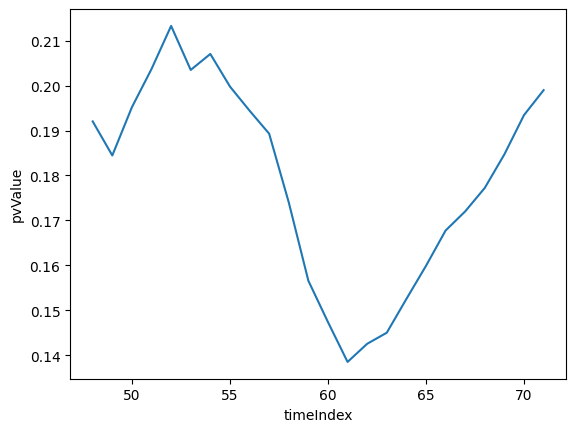

plot for day 3


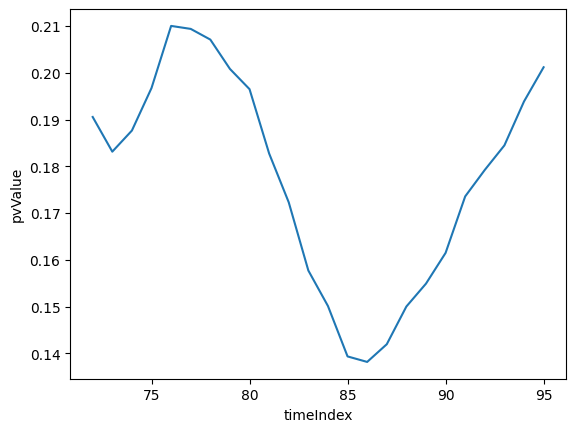

plot for day 4


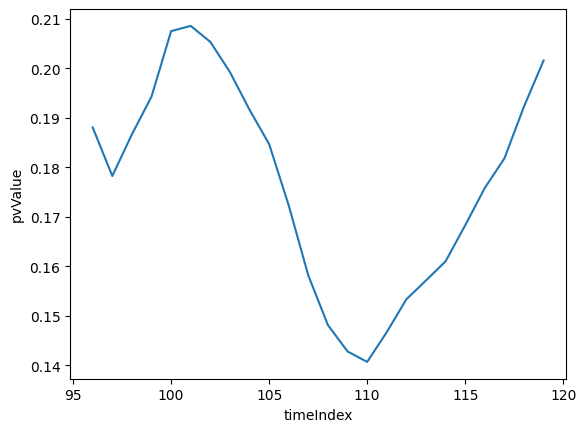

plot for day 5


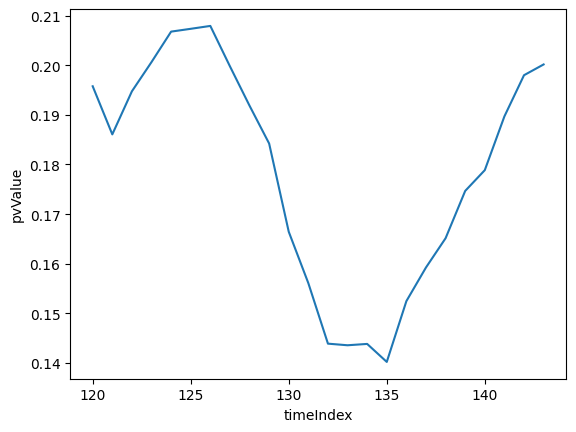

plot for day 6


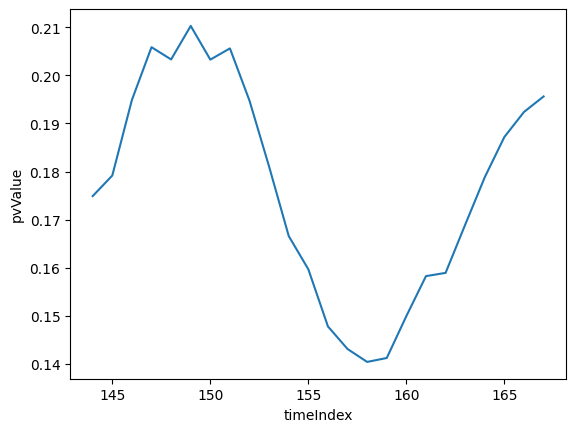

plot for agent 17
plot for day 0


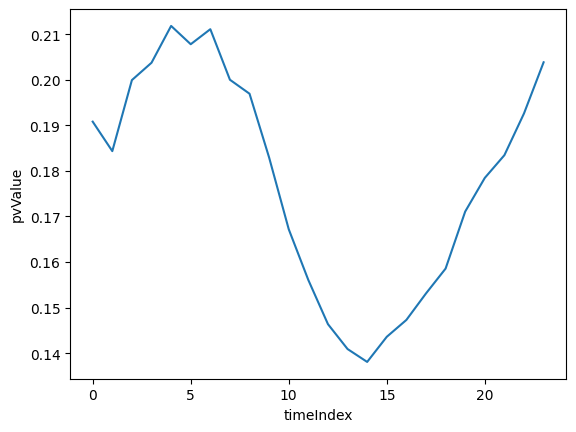

plot for day 1


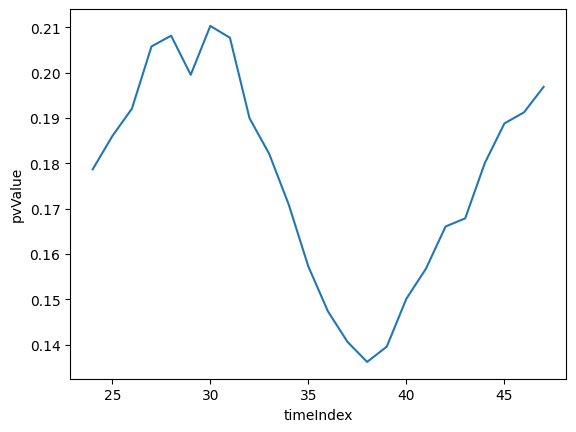

plot for day 2


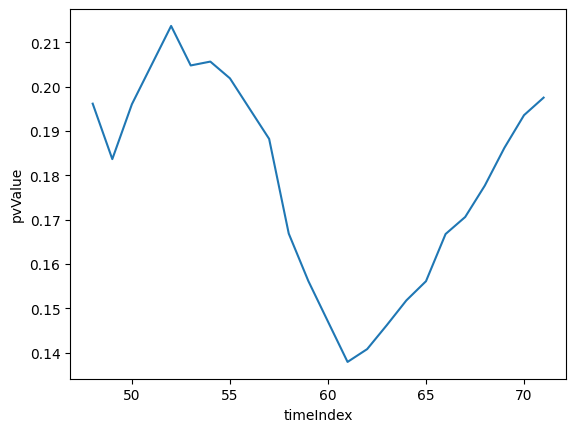

plot for day 3


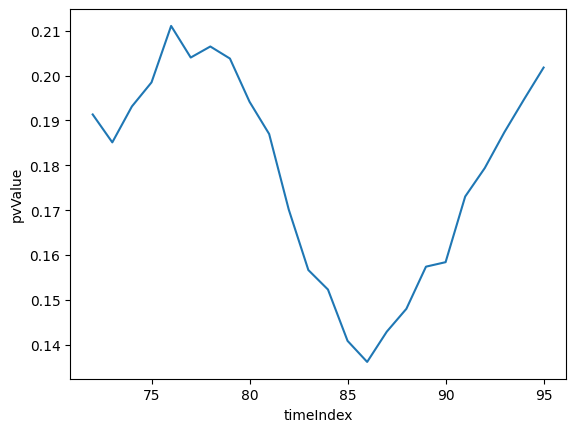

plot for day 4


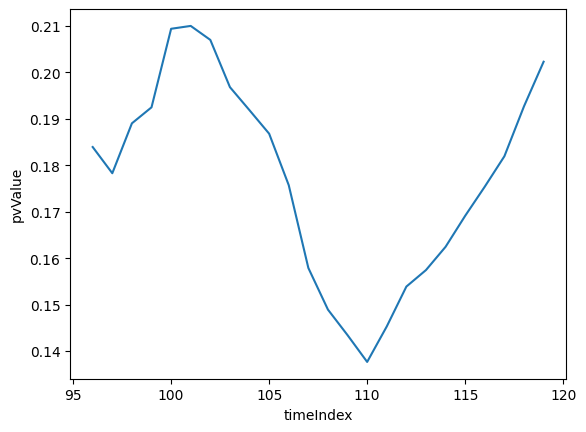

plot for day 5


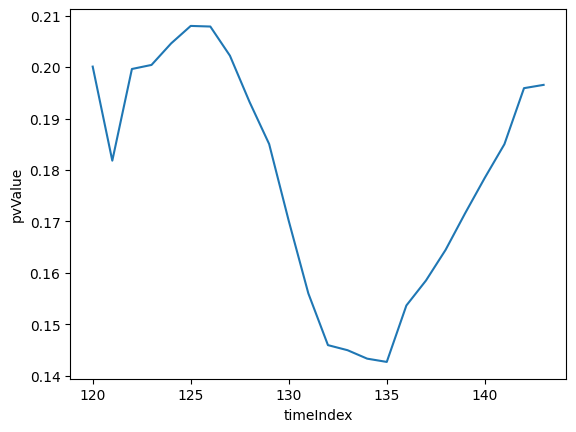

plot for day 6


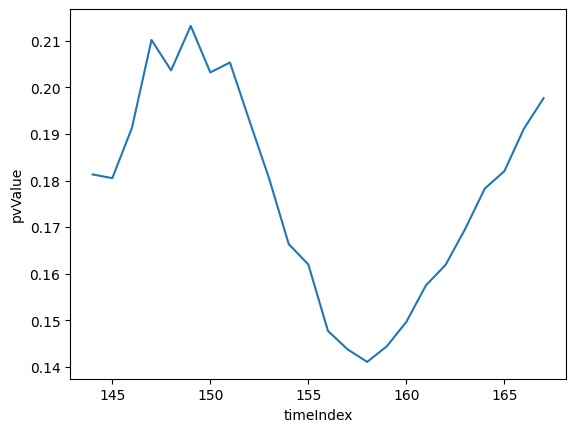

plot for agent 18
plot for day 0


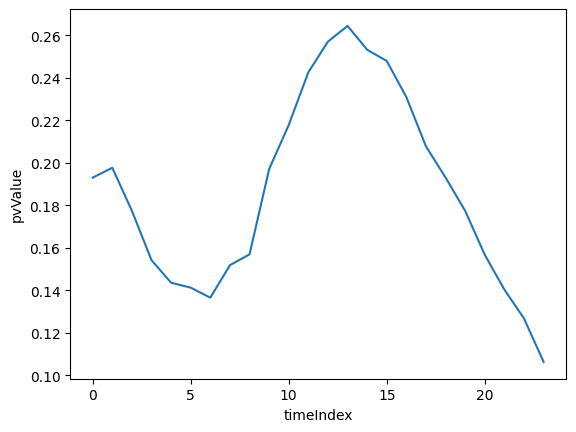

plot for day 1


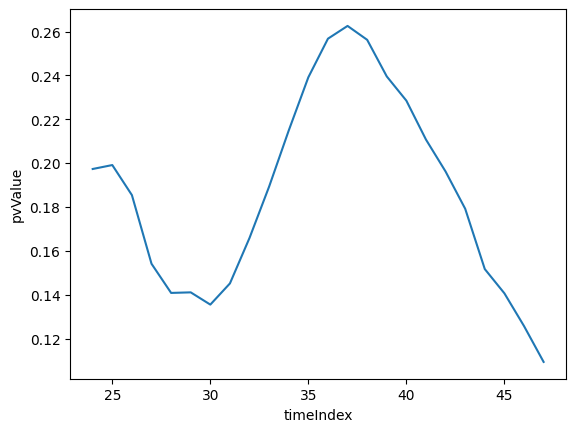

plot for day 2


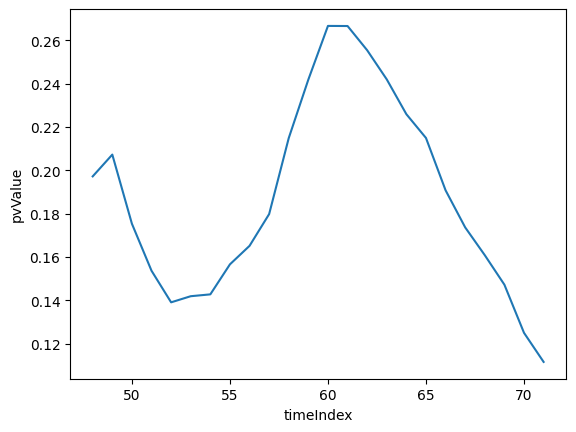

plot for day 3


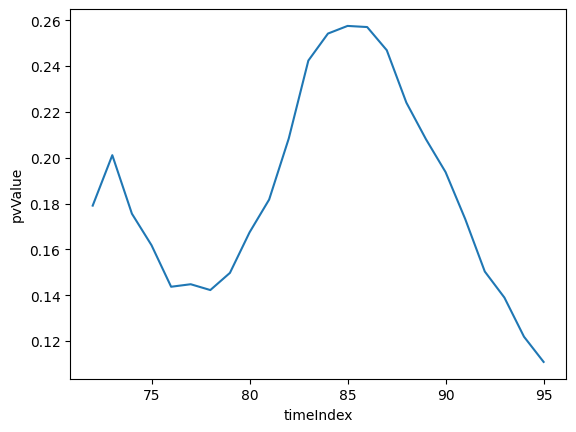

plot for day 4


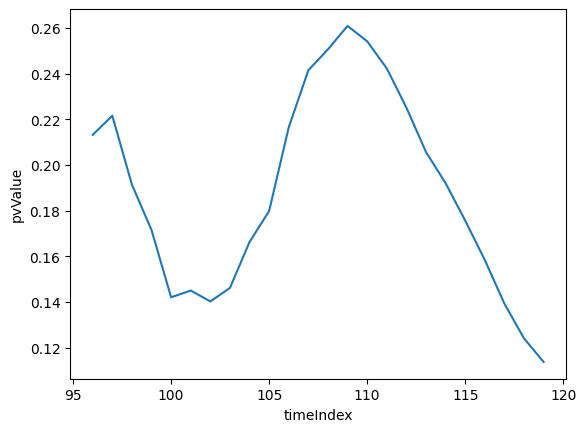

plot for day 5


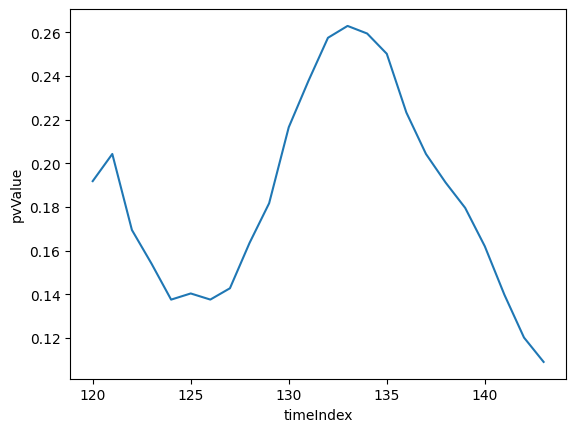

plot for day 6


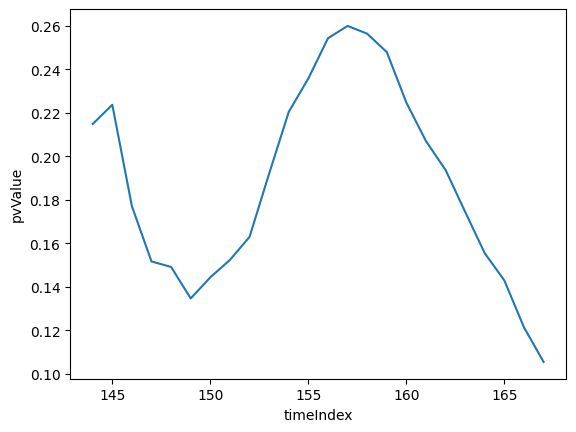

plot for agent 19
plot for day 0


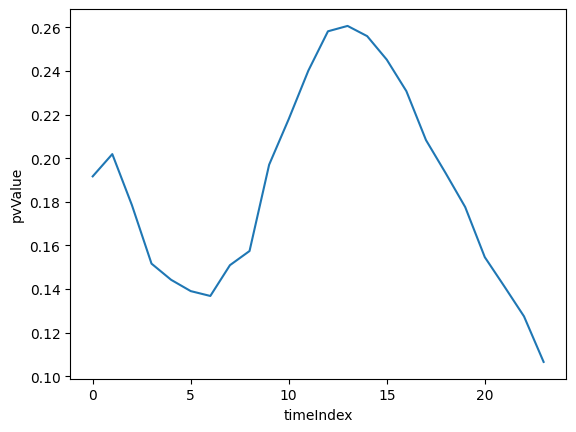

plot for day 1


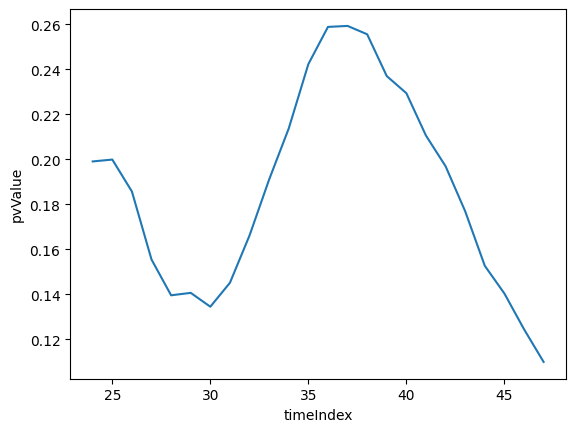

plot for day 2


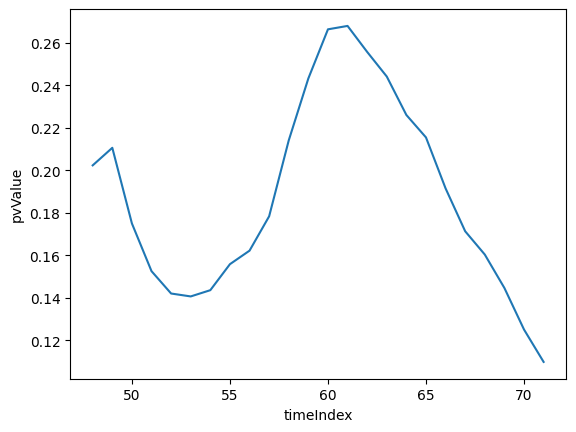

plot for day 3


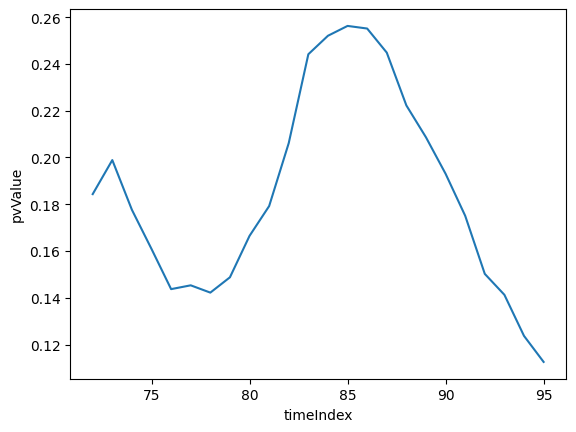

plot for day 4


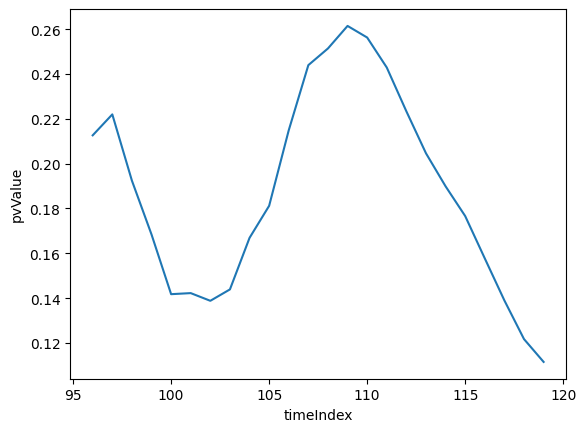

plot for day 5


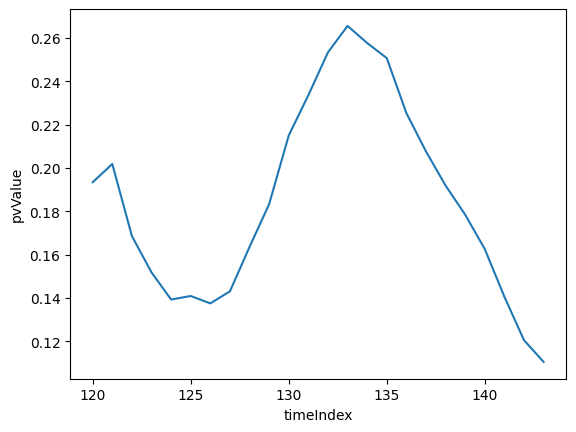

plot for day 6


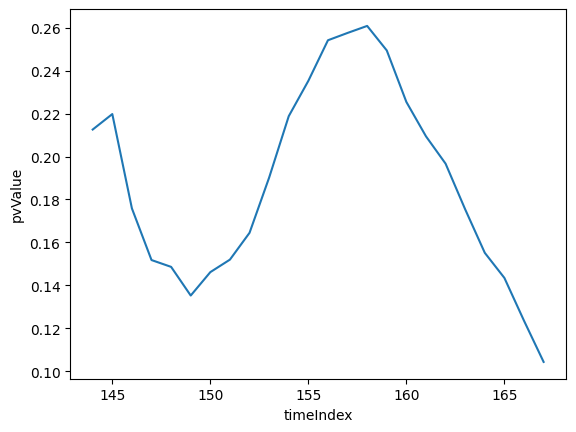

plot for agent 20
plot for day 0


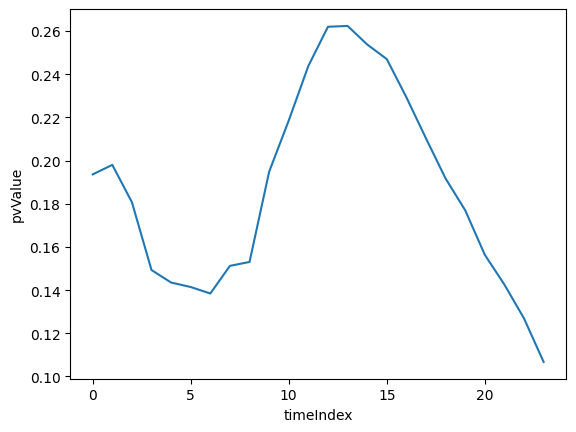

plot for day 1


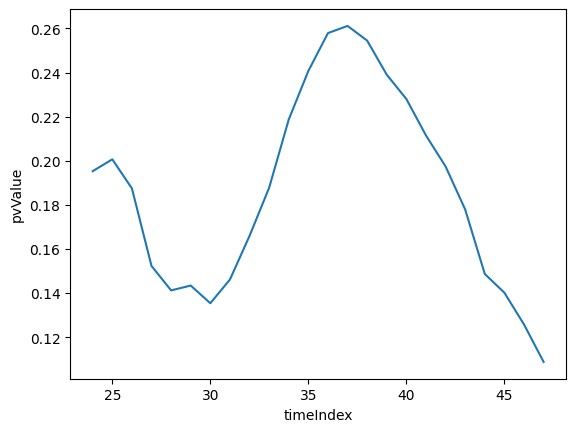

plot for day 2


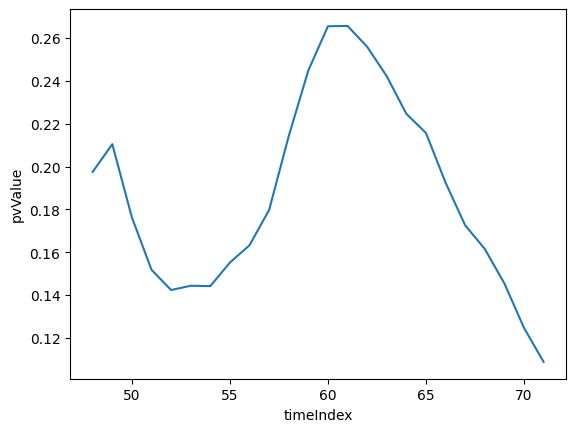

plot for day 3


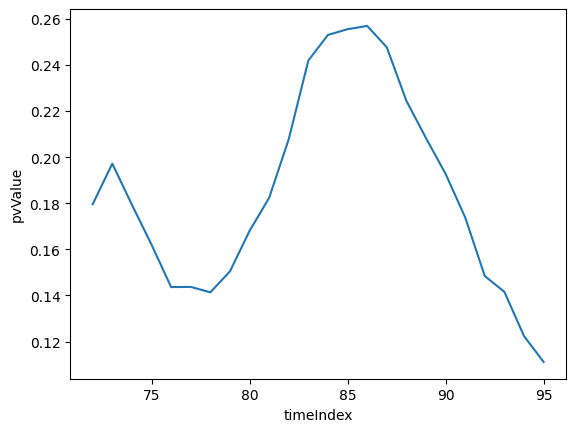

plot for day 4


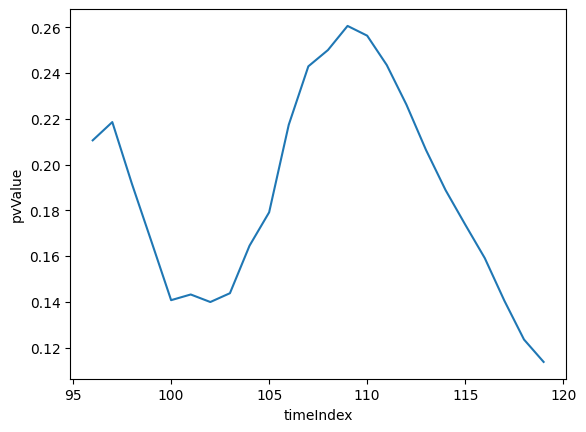

plot for day 5


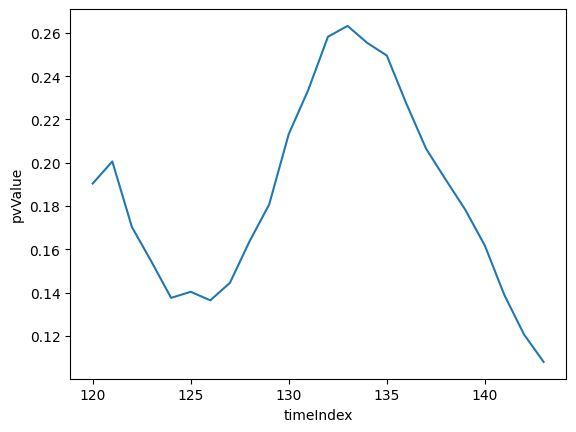

plot for day 6


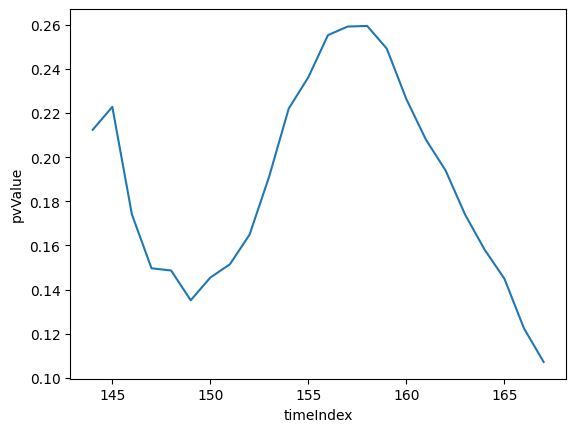

plot for agent 21
plot for day 0


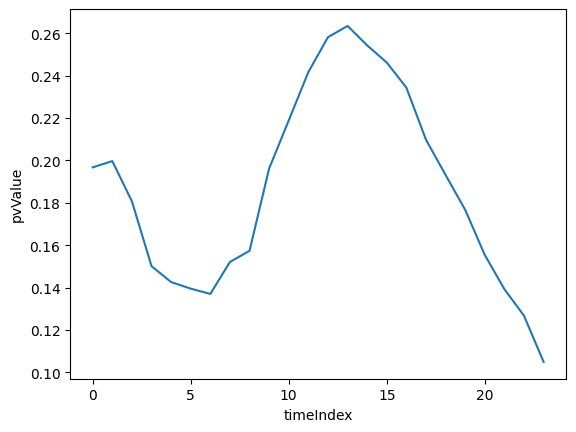

plot for day 1


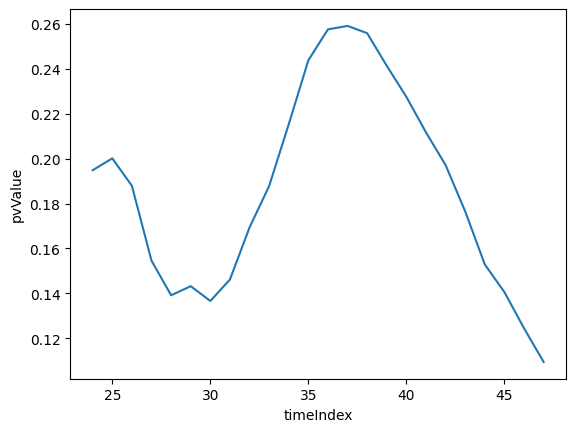

plot for day 2


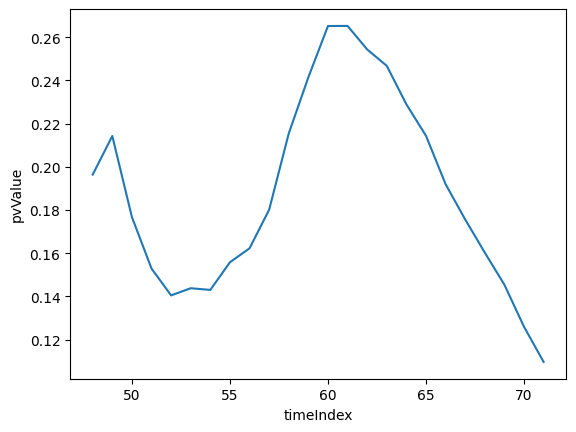

plot for day 3


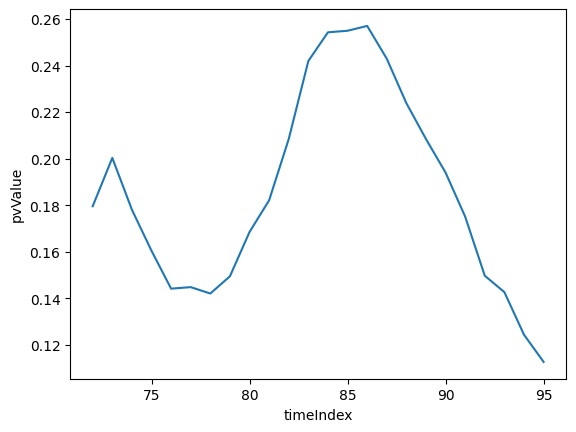

plot for day 4


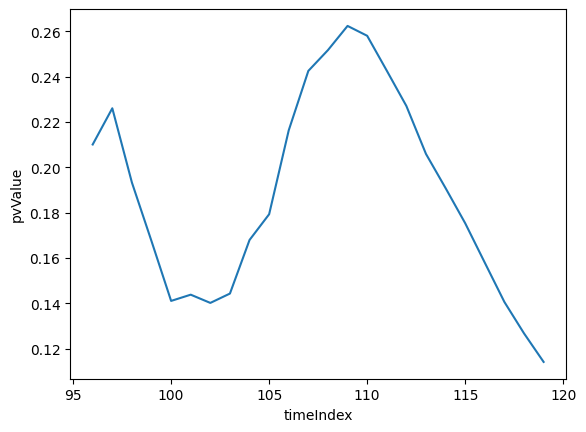

plot for day 5


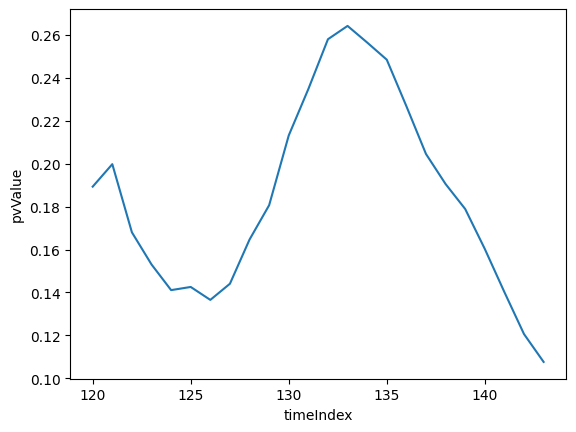

plot for day 6


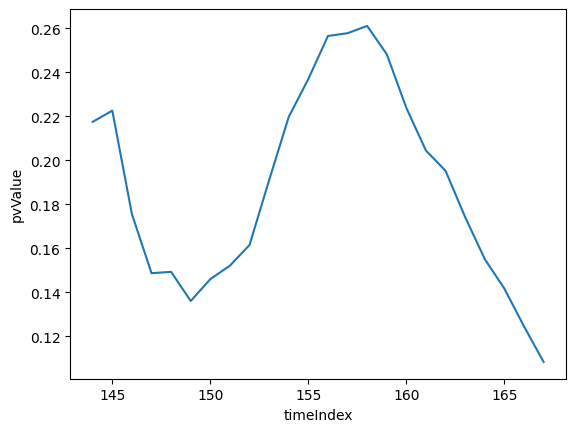

plot for agent 22
plot for day 0


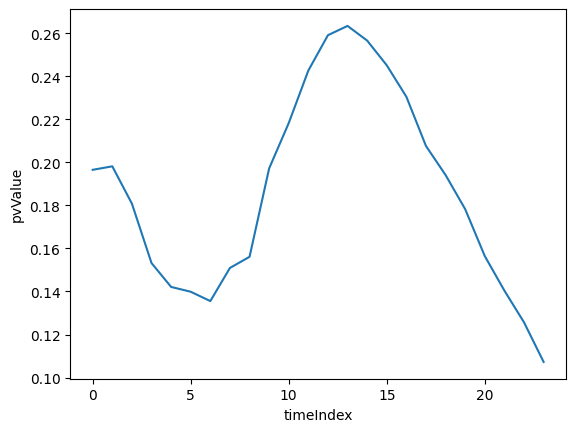

plot for day 1


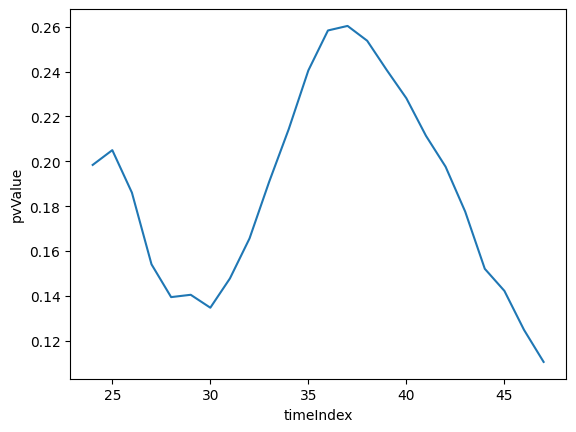

plot for day 2


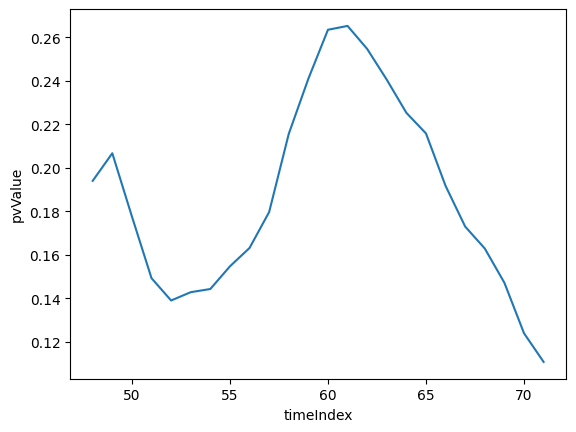

plot for day 3


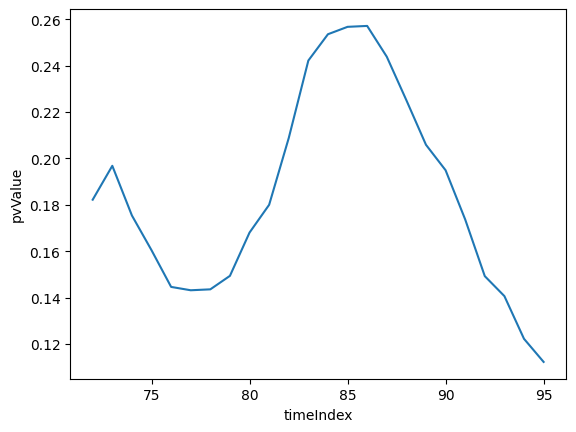

plot for day 4


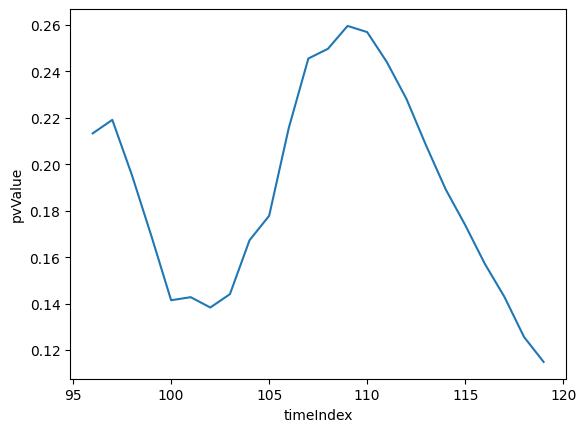

plot for day 5


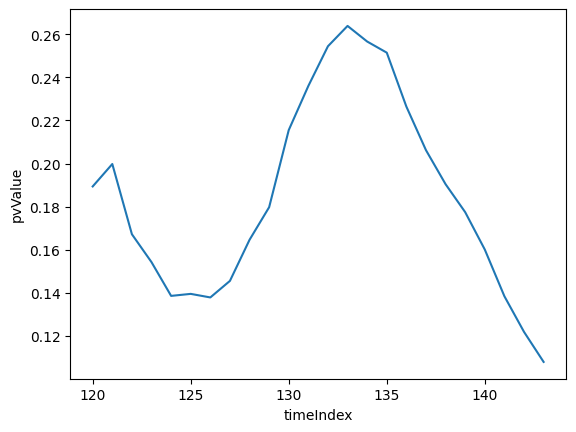

plot for day 6


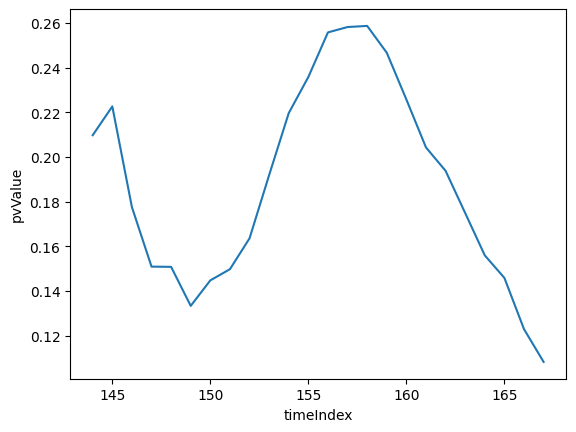

plot for agent 23
plot for day 0


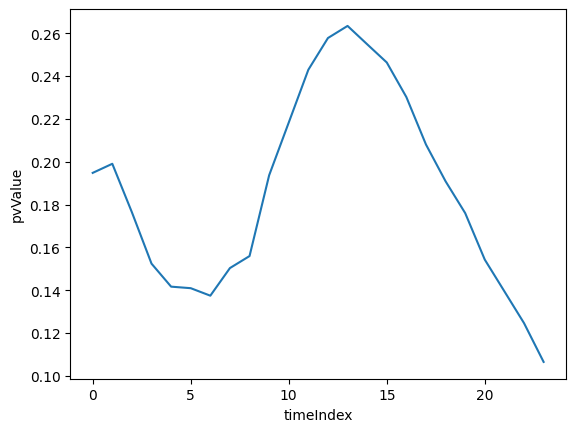

plot for day 1


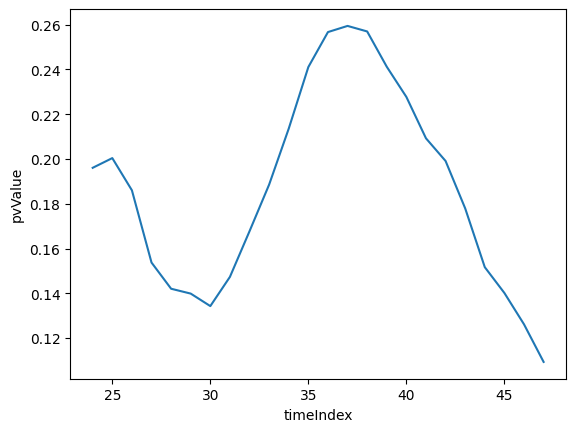

plot for day 2


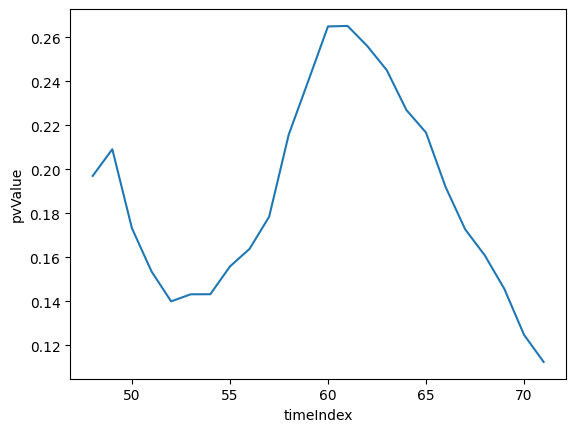

plot for day 3


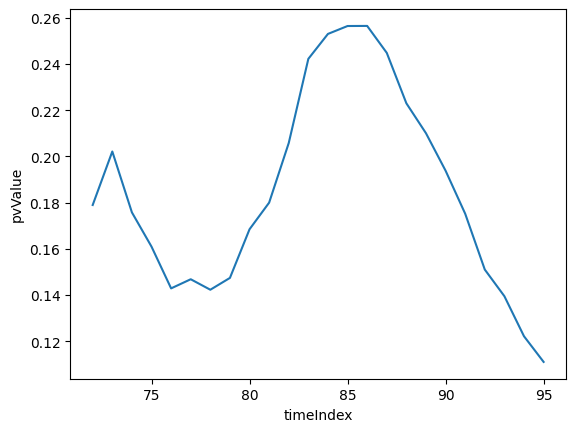

plot for day 4


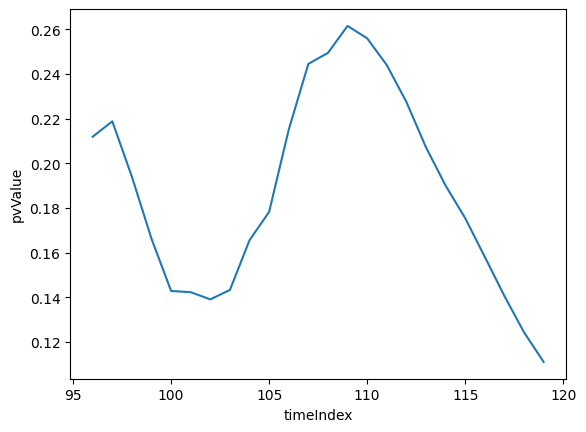

plot for day 5


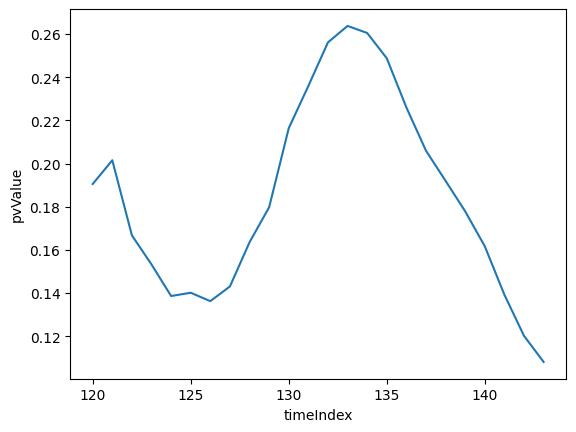

plot for day 6


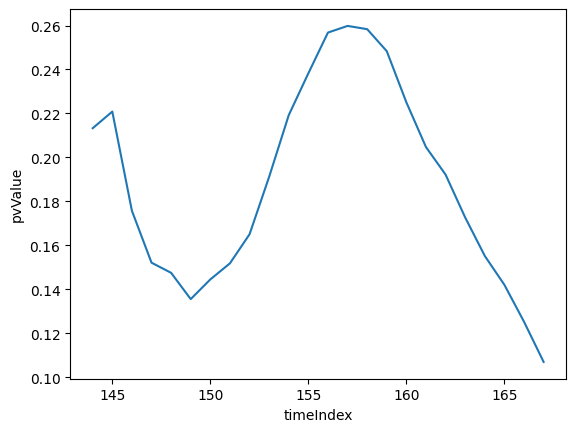

plot for agent 24
plot for day 0


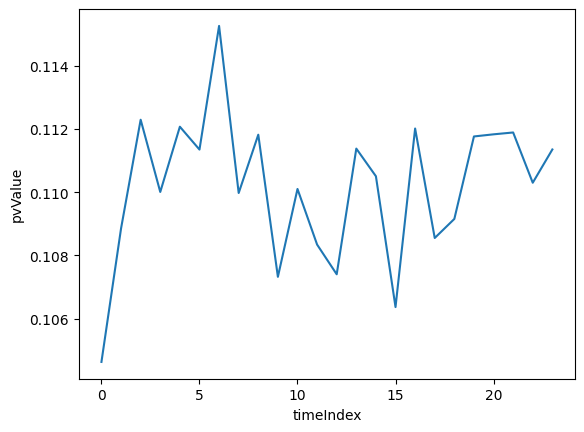

plot for day 1


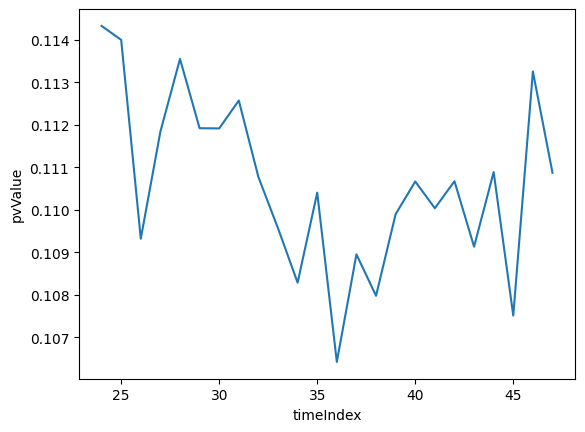

plot for day 2


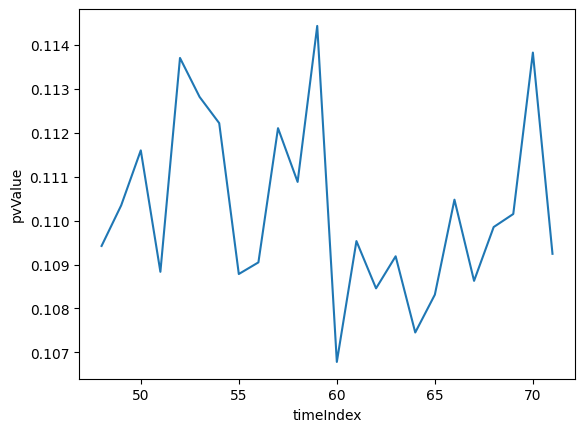

plot for day 3


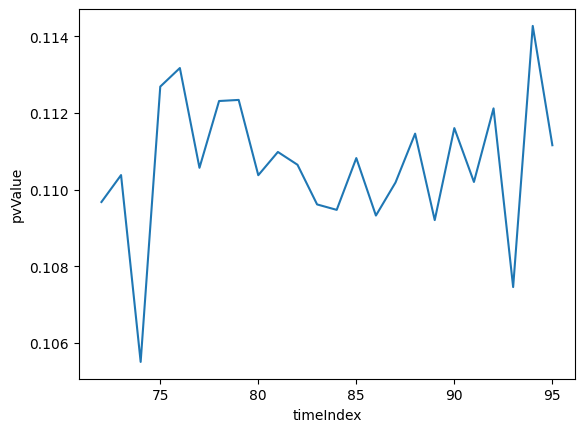

plot for day 4


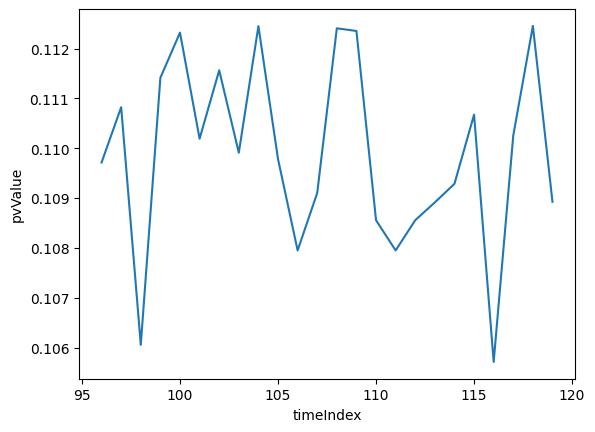

plot for day 5


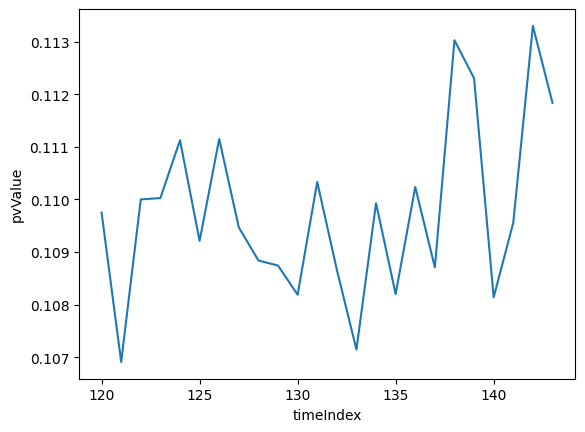

plot for day 6


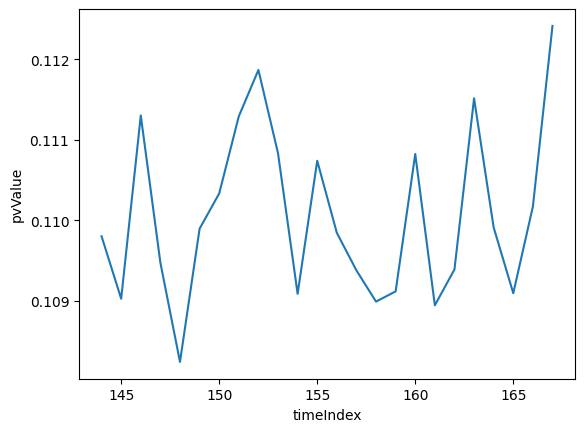

plot for agent 25
plot for day 0


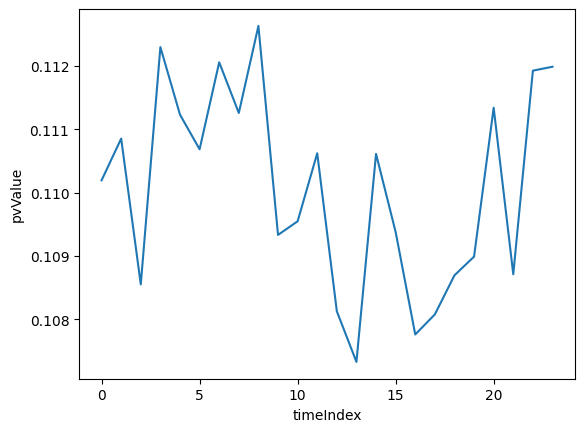

plot for day 1


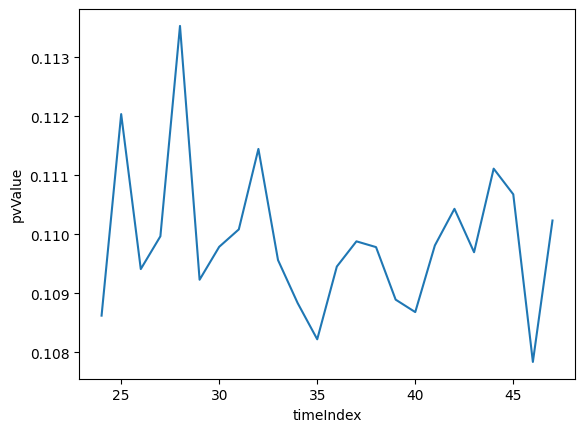

plot for day 2


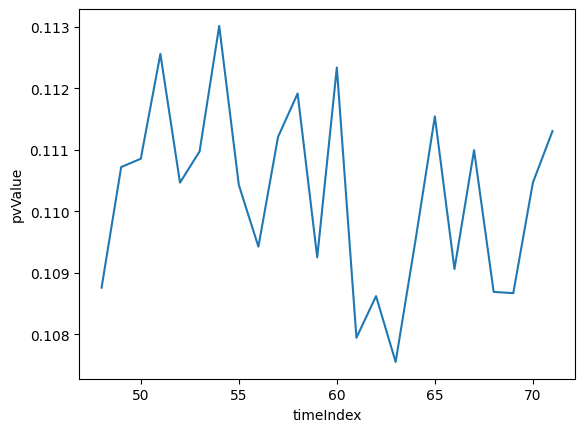

plot for day 3


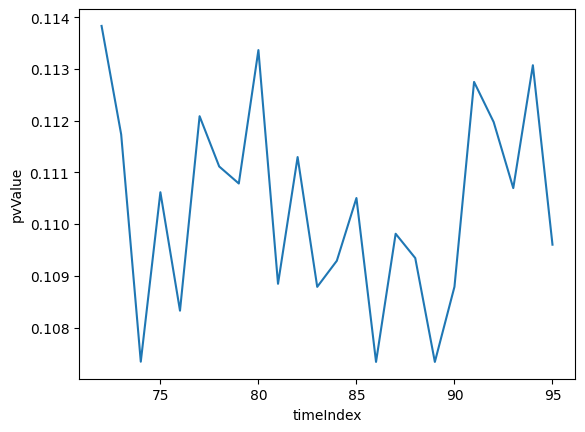

plot for day 4


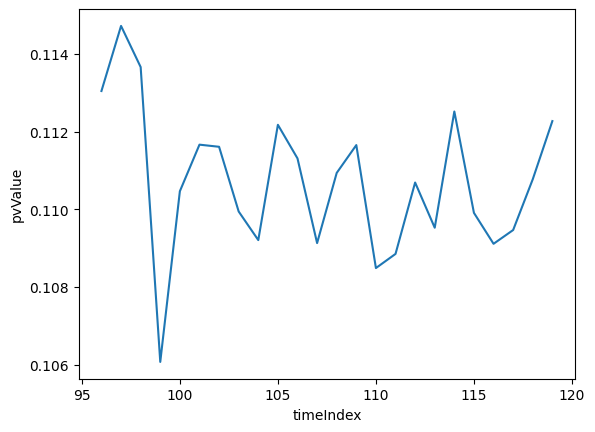

plot for day 5


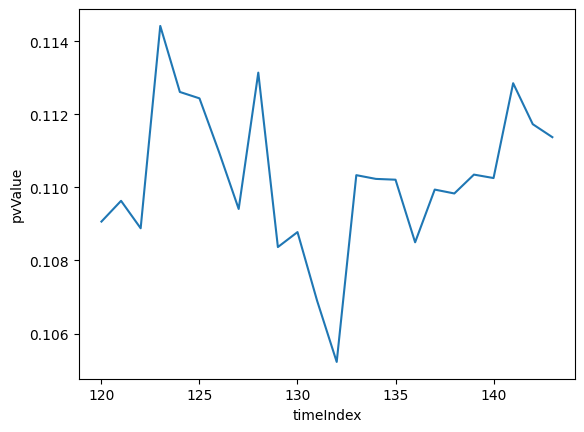

plot for day 6


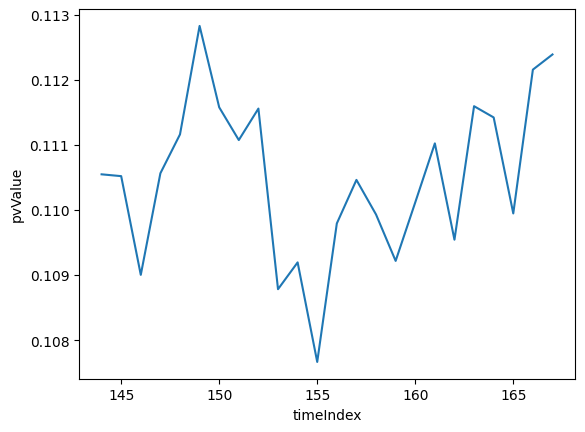

plot for agent 26
plot for day 0


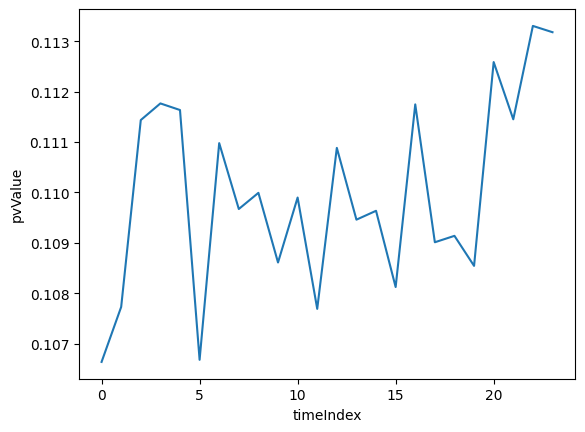

plot for day 1


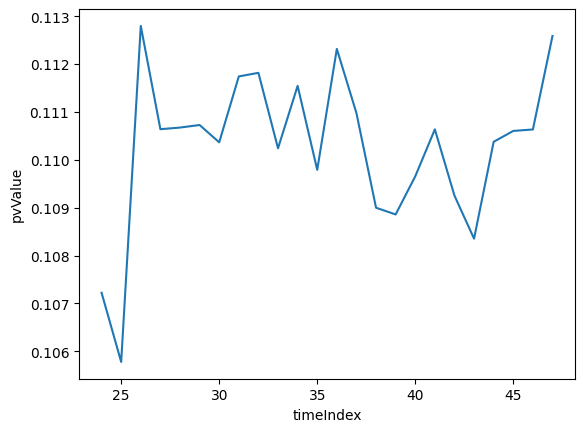

plot for day 2


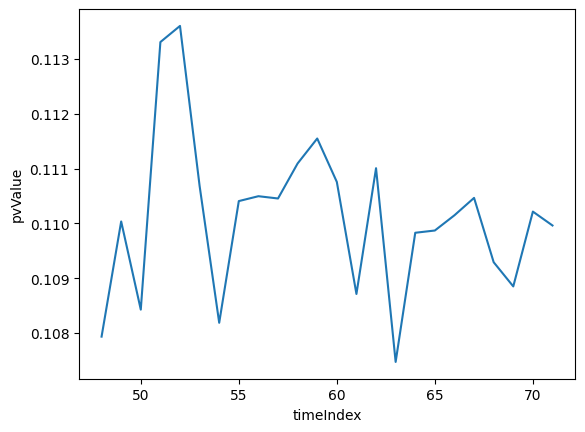

plot for day 3


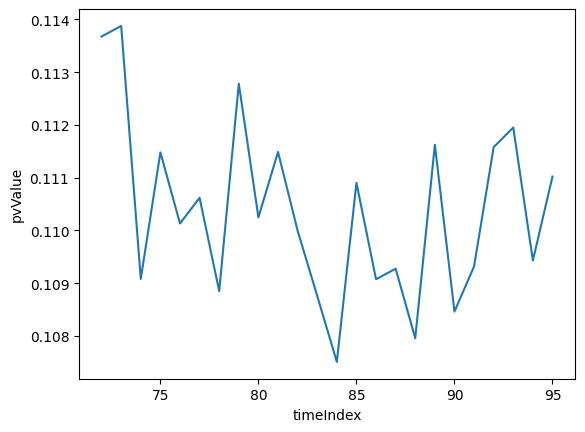

plot for day 4


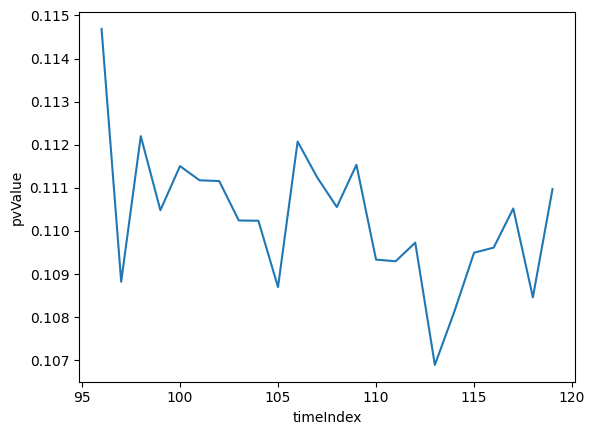

plot for day 5


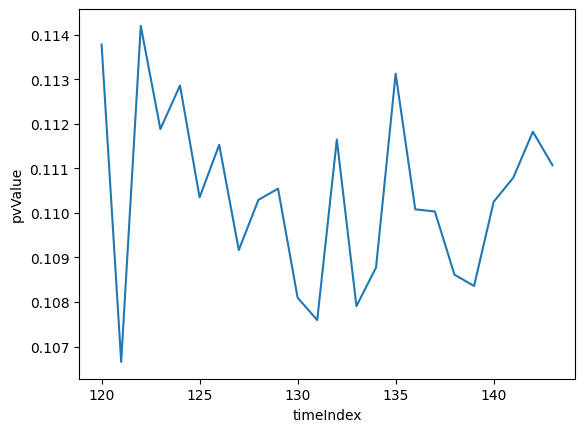

plot for day 6


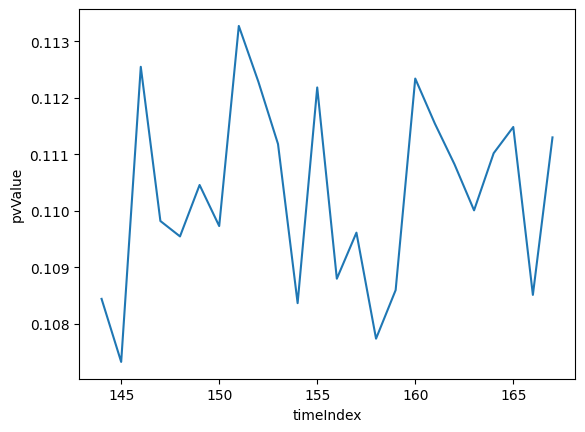

plot for agent 27
plot for day 0


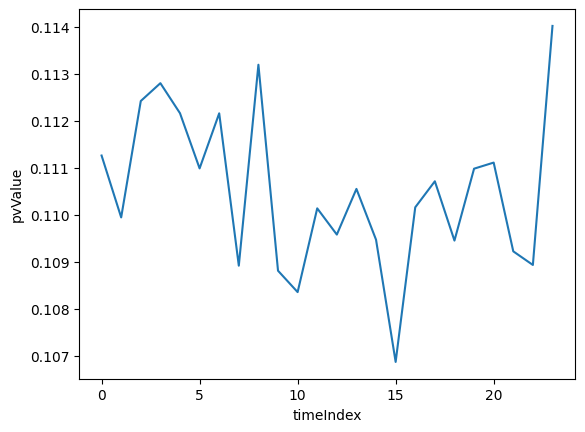

plot for day 1


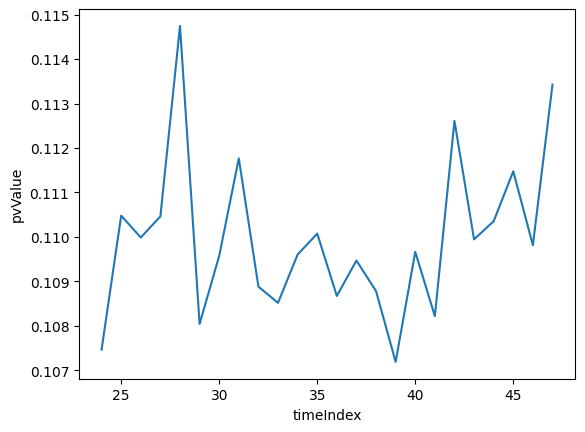

plot for day 2


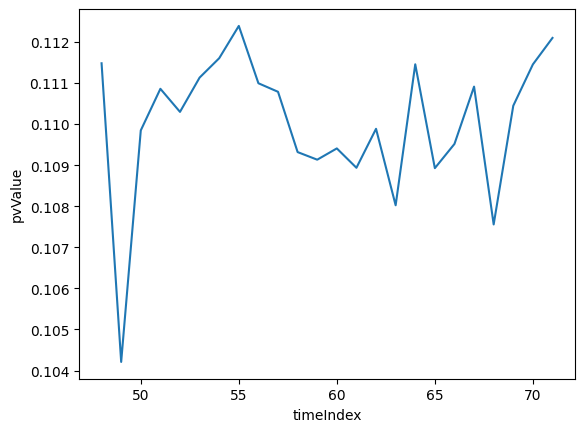

plot for day 3


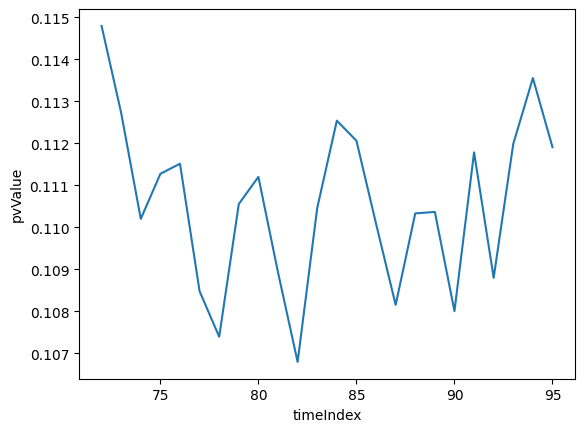

plot for day 4


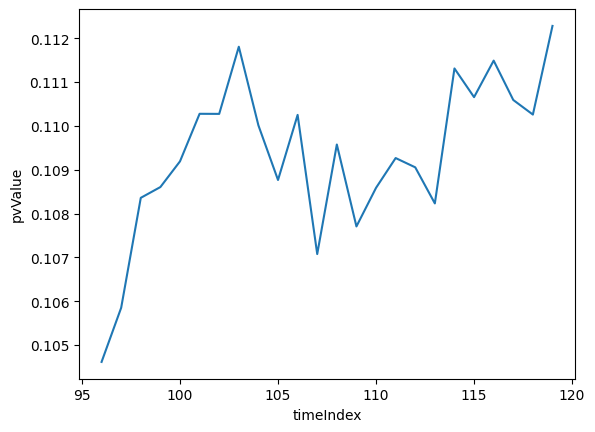

plot for day 5


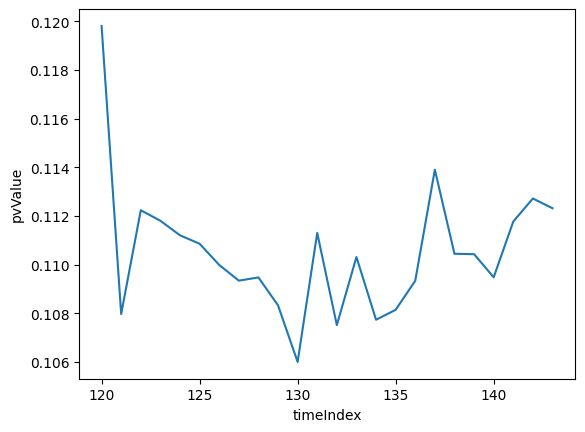

plot for day 6


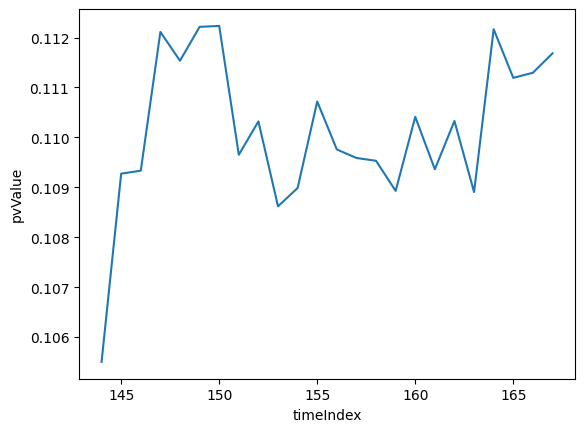

plot for agent 28
plot for day 0


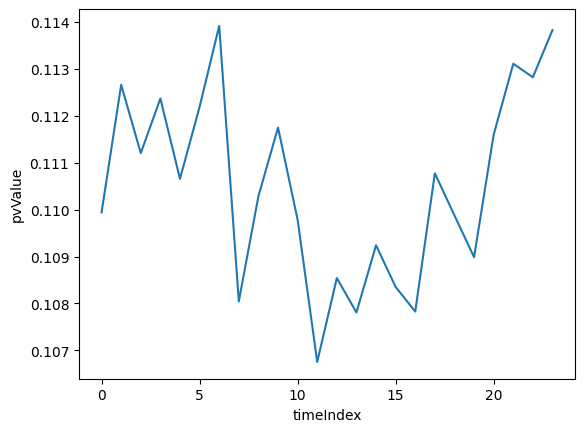

plot for day 1


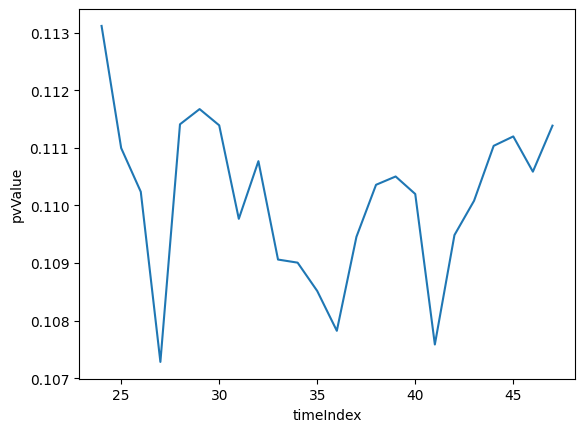

plot for day 2


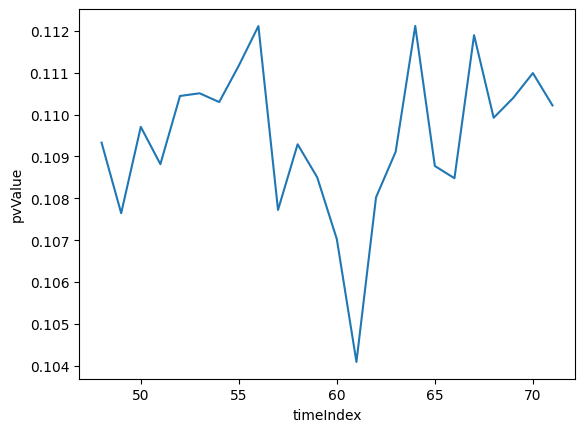

plot for day 3


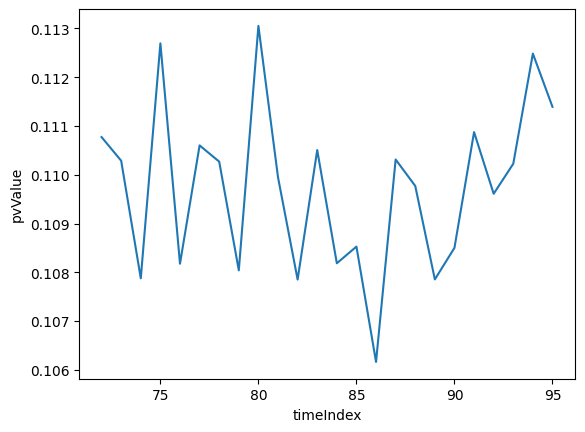

plot for day 4


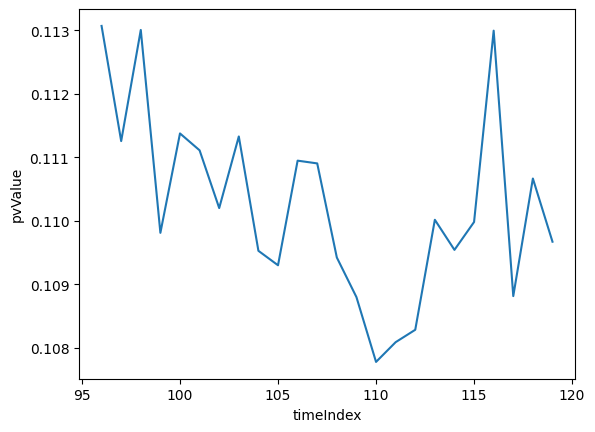

plot for day 5


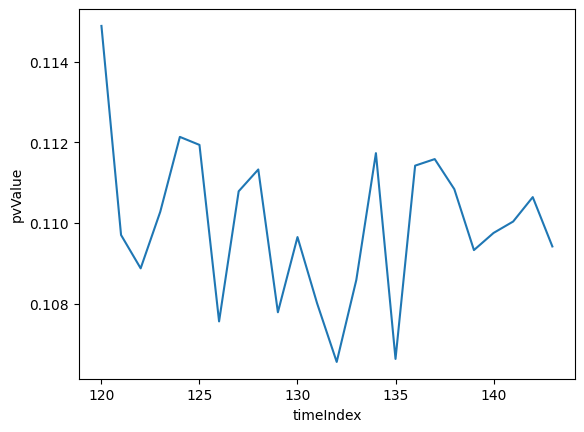

plot for day 6


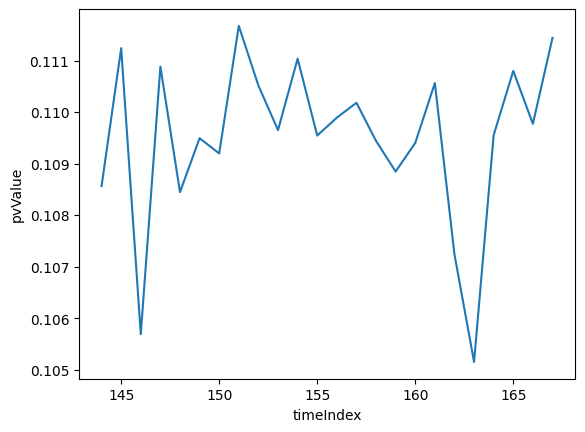

plot for agent 29
plot for day 0


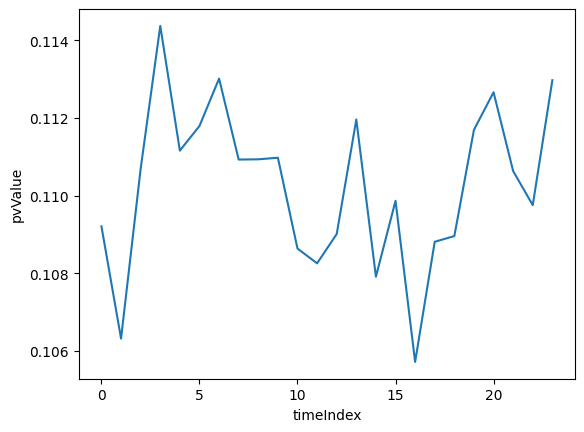

plot for day 1


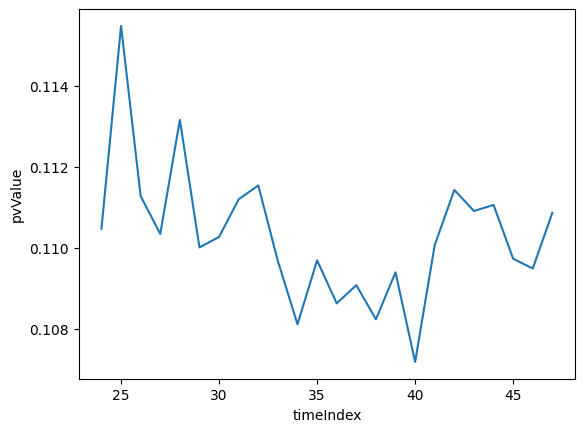

plot for day 2


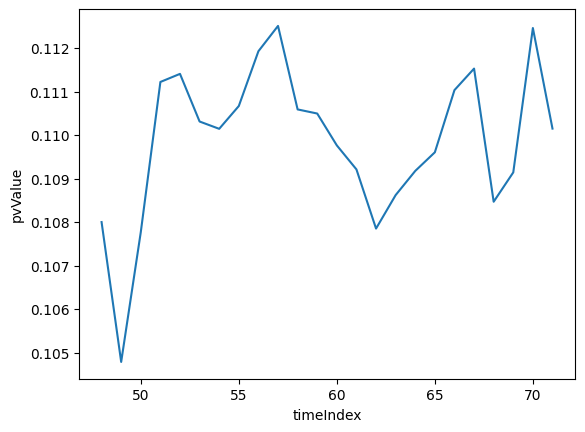

plot for day 3


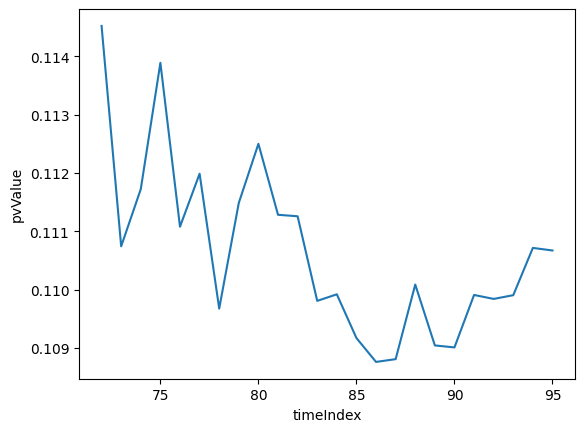

plot for day 4


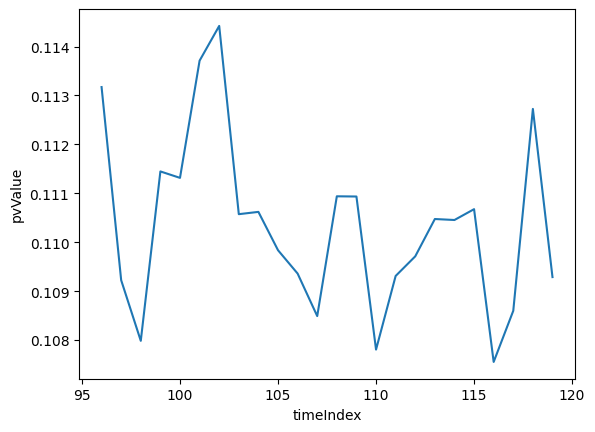

plot for day 5


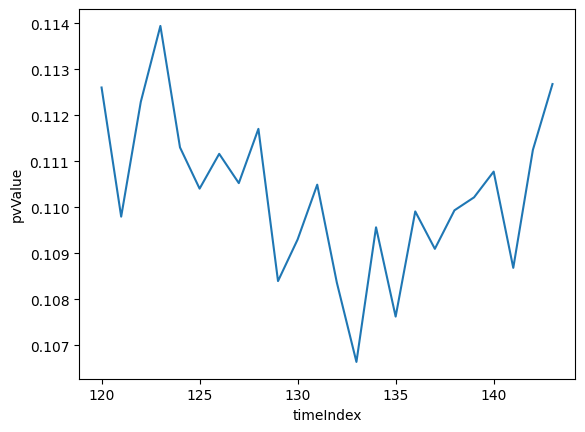

plot for day 6


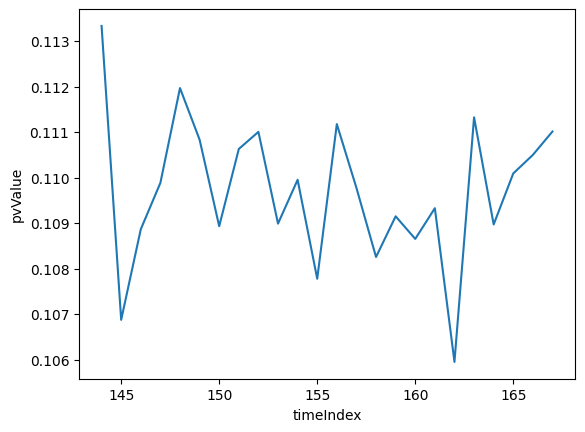

In [300]:
plot2(field="pvValue")